## Imports and settings


In [1]:
# !pip install m3_learning
# 

In [1]:
import sys
import glob
import os
sys.path.append('./../')
sys.path.append('./../../src/')
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch
import h5py
from ipywidgets import interact
from pprint import pprint
from tqdm import tqdm


# import nn
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.Movies import make_movie
from m3_learning.util.file_IO import download_and_unzip

from m3_learning.nn.STEM_AE_multimodal.Dataset import STEM_EELS_Dataset
from m3_learning.nn.STEM_AE_multimodal.Viz import Viz_Multimodal
from m3_learning.nn.STEM_AE_multimodal import STEM_AE as stem

2024-08-01 15:18:04.871655: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 15:18:04.907230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 15:18:04.907255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 15:18:04.909254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 15:18:04.916031: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 15:18:04.916622: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Specify the filename and the path to save the file
save_path = './../../../../Northwestern_link/Northwestern_Multimodal'
fig_path = save_path + "_Figures/"

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png'])

# Set the style of the plots
set_style("printing")

# Set the random seed for reproducibility
random_seed(seed=42)

In [ ]:
%matplotlib inline

## Domains 

### Loads the Dataset

save in format (save_folder)/particles/instrument/composition/SI data (#)/Diffraction SI.dm4 for correct data processing

In [ ]:
# with h5py.File(dset.h5_name,'a') as h:
    # print(h['kernel_sum_8'].attrs.keys())
    # print(h['kernel_sum_8'].attrs['shape_list'])

In [ ]:
dset = STEM_EELS_Dataset(save_path, ['kernel_sum_8','eels'],kernel_size=8,
                 EELS_roi={'LL':[(-31+15.5,276)], 'HL': [(501+15.5,809)]},
                 overwrite_eels=False,
                 overwrite_diff=False,)

fetching metadata...


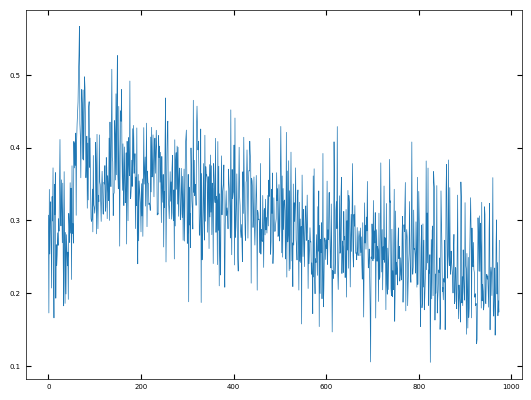

In [ ]:
plt.plot(dset[0][1][1])

In [7]:
len(dset)

452304

In [8]:
# dset = STEM_EELS_Dataset(save_path, 
#                  EELS_roi={'LL':[(-31+15.5,276)], 'HL': [(501+15.5,809)]},
#                  overwrite_eels=False,
#                  overwrite_diff=False,)

In [9]:
# from ipywidgets import interact

# h = dset.open_h5()
# def f(x):
#     i,eels = dset[x]
#     fig, ax = plt.subplots(3)  # Creates two subplots
#     # ax[0].imshow(diff.squeeze())
#     ax[1].plot(eels[0])
#     ax[2].plot(eels[1])
        
# interact(f,x=(0,len(dset)-1))

In [10]:
# p=0
# s = dset.meta['shape_list'][p][1]
# istart = dset.meta['particle_inds'][p]
# iend = dset.meta['particle_inds'][p+1]
# with dset.open_h5() as h:
#     data = h['processed_data']['eels'][istart:iend].reshape(s[0],s[1],2,-1)
# k=4

# def f(x,y):
#     fig, ax = plt.subplots(2,2) 
#     ax = ax.flatten()
#     ax[0].imshow(data[:,:,0].mean(2))
#     ax[0].scatter(x, y, facecolors='none', edgecolors='r', marker='s', s=(k*2+1)**2)
#     ax[1].imshow(data[:,:,1].mean(2))
#     ax[1].scatter(x, y, facecolors='none', edgecolors='r', marker='s', s=(k*2+1)**2)
    
#     ax[2].plot(data[x-k:x+k,y-k:y+k,0].mean((0,1)))
#     ax[3].plot(data[x-k:x+k,y-k:y+k,1].mean((0,1)))

In [11]:
# interact(f,x=(0,140),y=(0,140))

### Visualizes the Raw Data


In [ ]:
# # instantiates the visualization class
# viz = Viz_Multimodal(printer=printing, labelfigs_=True)
# viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm", "channel": -1}

In [ ]:
# # # TODO: fix the bright/darkfield viz, and the avg. By Particle.
# for i in tqdm(range(len(dset.meta['particle_list']))):
#     viz.STEM_raw_and_virtual(
#         dset,i,
#         scalebar_=True,
#     )

## Builds the Neural Network Model


In [ ]:
# bout 1 min 6 sec
channels_1D = dset.shape[1][1] # number of channels
encoder_step_size_1D = dset.shape[1][-1] # length of eels spectrum
encoder_step_size_2D = dset.shape[0][-2:] # original shape of diffraction pattern

pooling_list_1D = [5, 5, 3] # 975 --> 13
pooling_list_2D = [4, 4, 4] # 512,512 --> 8,8

decoder_step_size_1D = 39
decoder_step_size_2D = [8, 8]

upsampling_list_1D = [5,5]
upsampling_list_2D = [8, 8]

embedding_size_1D = 6 # from flattening channels but you can choose whatever you want
embedding_size_2D = 32 # you can shoose whatever you want
embedding_size = 32


conv_size_1D = 128
conv_size_2D = 128
attn_heads = 3

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"


## train 1D and 2D separately

## 1d using SHO

In [ ]:
import m3_learning

In [ ]:

import m3_learning.nn.STEM_AE_multimodal.STEM_AE as stem

In [ ]:
model1D = stem.FitterAutoencoder_1D(function=stem.generate_pseudovoigt_1D,
                                 dset = dset,
                                 input_channels=dset.eels_chs,
                                 num_params=6,
                                 num_fits=64, # change to 64
                                 limits=[1,975,200,1,200,1],
                              #    limits=[1,975,150,1,150,1],
                                 device='cuda:0',
                                 flatten_from = 1,
                                 learning_rate = 1e-7
                            )

In [ ]:
model1D.num_fits

64

In [ ]:
model1D.load_weights(
    '/home/m3learning/Northwestern/m3_learning/m3_learning/papers/Multimodal/Combined_1D_PV_kernel_sum/(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl'
    
    
    
    )

Generated available
[Errno 2] Unable to open file (unable to open file: name = './Combined_all_samples_1D_PV/generated_1D.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Generated not opened


In [ ]:
## TODO: get rid of translation
## TODO: should I add weights for the relative contributions of spectra and diffraction?
model1D.Train(
    dset,
    coef_1=0,
    coef_2=0,
    epochs=100,
    with_scheduler=False,
    folder_path="Combined_1D_PV_kernel_sum_broad",
    batch_size=64, # max 16 on h100
)

100%|██████████| 7068/7068 [53:06<00:00,  2.22it/s]


Epoch: 000/100 | Train Loss: 19.7411
.............................


100%|██████████| 7068/7068 [52:55<00:00,  2.23it/s]


Epoch: 001/100 | Train Loss: 17.9135
.............................


  0%|          | 27/7068 [00:11<51:25,  2.28it/s]


KeyboardInterrupt: 

In [11]:
# Fitter = stem.Multiscale1DFitter(function=stem.generate_pseudovoigt_1D,
#                                  x_data = dset,
#                                  input_channels=dset.eels_chs,
#                                  num_params=6,
#                                  num_fits=12,
#                                  device='cuda:0',
#                                  flatten_from = 1,
#                             )
# Fitter = Fitter.to(device)

In [28]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dset, batch_size=16, shuffle=True, )


batch = next(iter(dataloader))

In [29]:
test = model1D.Fitter(batch[1].to(device).float()) # return fitted, embedding

In [30]:
test[0].shape,test[1].shape

(torch.Size([32, 64, 6]), torch.Size([16, 2, 975]))

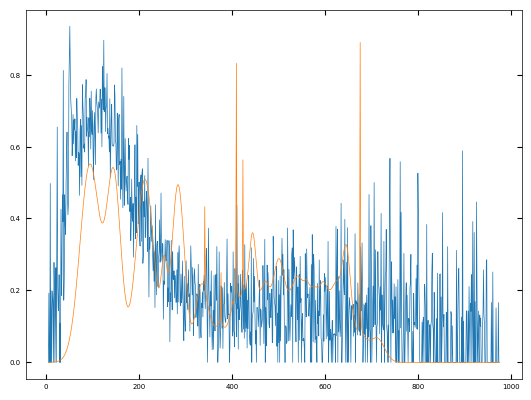

In [31]:
ch=0
plt.plot(np.arange(5,975),batch[1][0][ch][5:].detach().cpu())
plt.plot(np.arange(5,975),test[1][0][ch][5:].detach().cpu())

In [37]:
# conv = torch.nn.Conv1d(2,2,kernel_size=5,padding=2,dtype=float)
# smooth = conv(batch[1])
# # smooth = conv(smooth)

In [17]:
# ch=1
# plt.plot(np.arange(0,975),batch[1][0][ch].detach().cpu())
# plt.plot(np.arange(0,975),smooth[0][ch].detach().cpu())

In [17]:
model1D.checkpoint = '/home/m3learning/Northwestern/m3_learning/m3_learning/papers/Multimodal/Combined_1D_PV_kernel_sum/(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl'



In [18]:
with h5py.File(model1D.emb_h5_path,'r+') as h:
    # h.create_dataset('embedding_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl',data = h['embedding_'])
    # h.create_dataset('fits_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl', data=h['fits_'])
    # h['embedding_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675'] = h['embedding_']
    # h['fits_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675'] = h['fits_']
    # del h['embedding_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl']
    # del h['fits_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl']
    print(h.keys())

<KeysViewHDF5 ['embedding_', 'embedding_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675', 'fits_', 'fits_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675']>


In [47]:
embeddings = model1D.get_embedding(dset,train=False)
# model1D.embeddings = embeddings

100%|██████████| 14135/14135 [19:57<00:00, 11.80it/s]


In [23]:
dset.meta['shape_list'][0]


((128, 128, 512, 512), (128, 128, 1024), (128, 128, 1024))

In [22]:
dset.meta.keys()

dict_keys(['path_list', 'particle_list', 'shape_list', 'scale', 'particle_inds', 'sample_inds', 'eels_axis_labels'])

In [156]:
dset.raw_x_labels.shape

(1023, 2)

In [157]:
dset.meta['eels_axis_labels']

[(49, 1022, 0), (49, 1022, 1)]

In [50]:
viz.printer.basepath

'./../../../../Northwestern_link/Northwestern_Multimodal_Figures/'

In [64]:
# instantiates the visualization class
viz = Viz_Multimodal(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm", "channel": -1}

In [72]:
f()

TypeError: Viz_Multimodal.fits_Fitter1D_widget() missing 2 required positional arguments: 'p' and 'i'

In [21]:
from functools import partial
from ipywidgets import interact

meta = {}
with h5py.File(dset.h5_name, 'r+') as h5:
    for key, value in h5[f'{dset.mode[0]}'].attrs.items():
        meta[key] = value
chnm = ['HL: ','LL: ']    
nchs = dset.eels_chs
nfits = model1D.num_fits
x_vals = [dset.raw_x_labels[i0-1:i1+1,l] for i0,i1,l in dset.meta['eels_axis_labels']]

# def f(p,i):
#     viz.fits_Fitter1D_widget(p,i,
#             model=model1D, dset=dset,
#             meta=meta, nchs=nchs,
#             x_vals=x_vals, chnm=chnm,
#             savefolder='embeddings_lab_07-29',
#             channels = viz.channels,
#             scalebar_ = viz.scalebar_,
#             printer = viz.printer)

# for p in range(0,len(meta['shape_list'])):
#     print(model1D.dset.meta['particle_list'][p])
#     for i in tqdm(range(0,model1D.num_fits-1)):
#         f(p,i)

 96%|█████████▋| 27/28 [11:59<00:26, 26.64s/it]


IndexError: index 28 is out of bounds for axis 0 with size 28

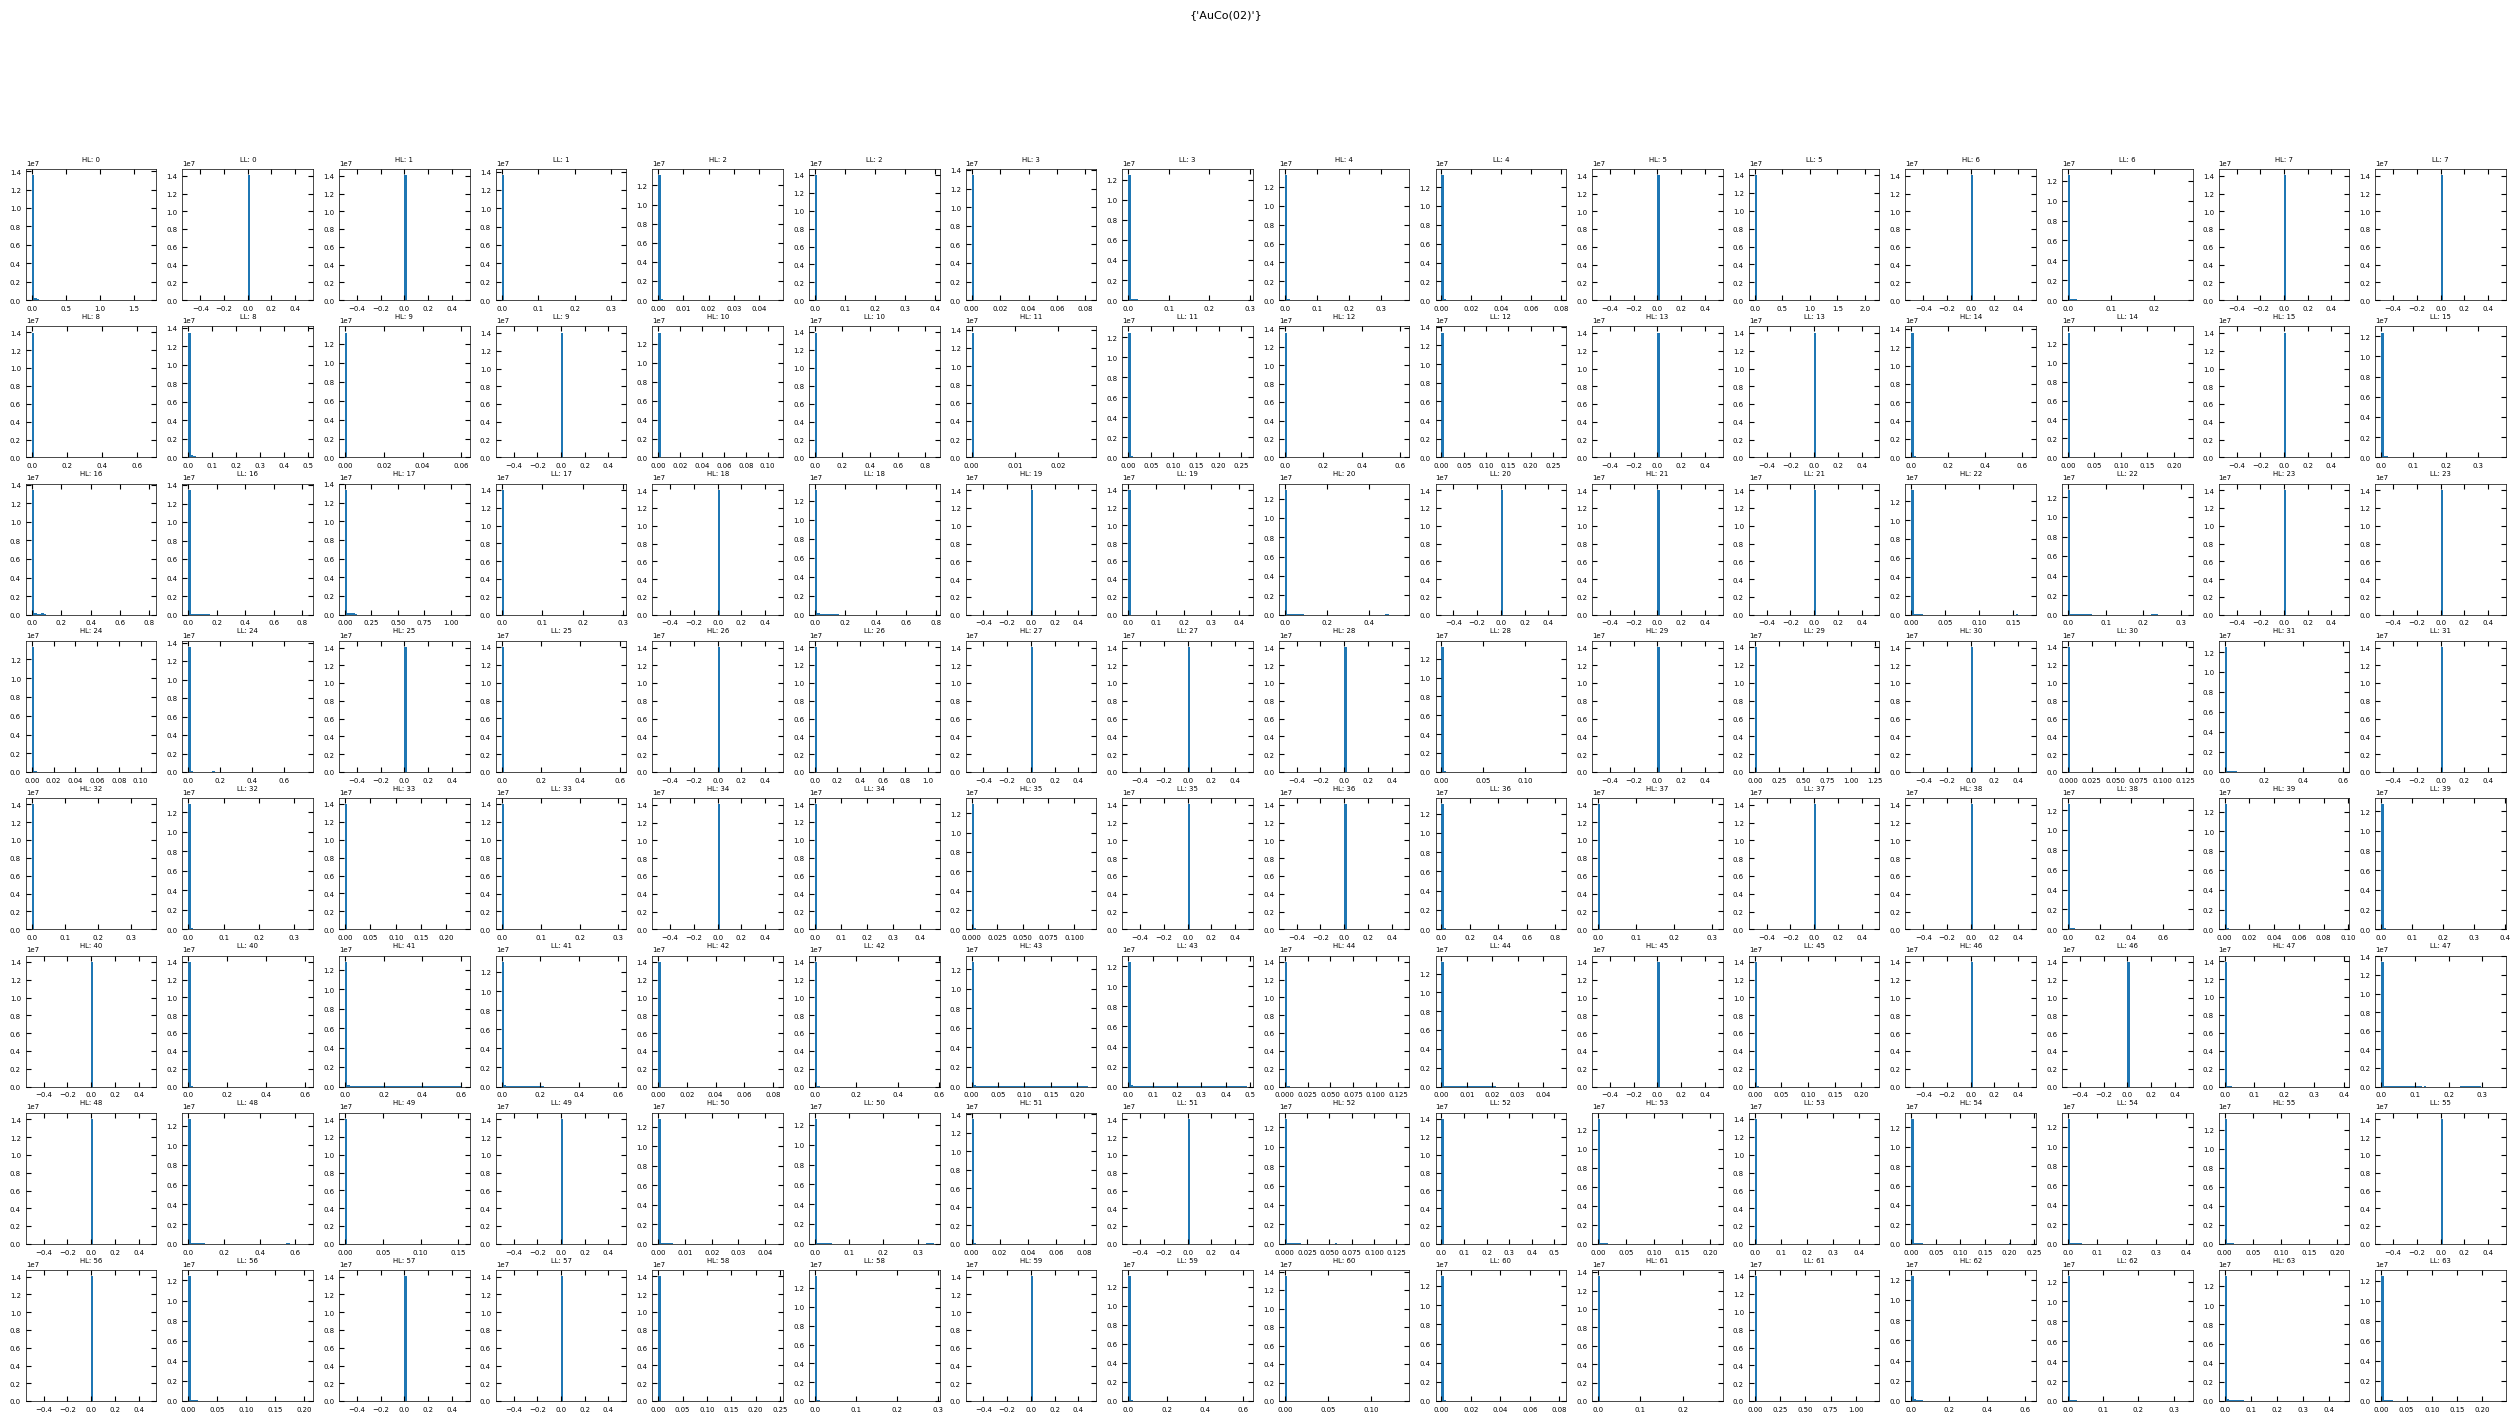

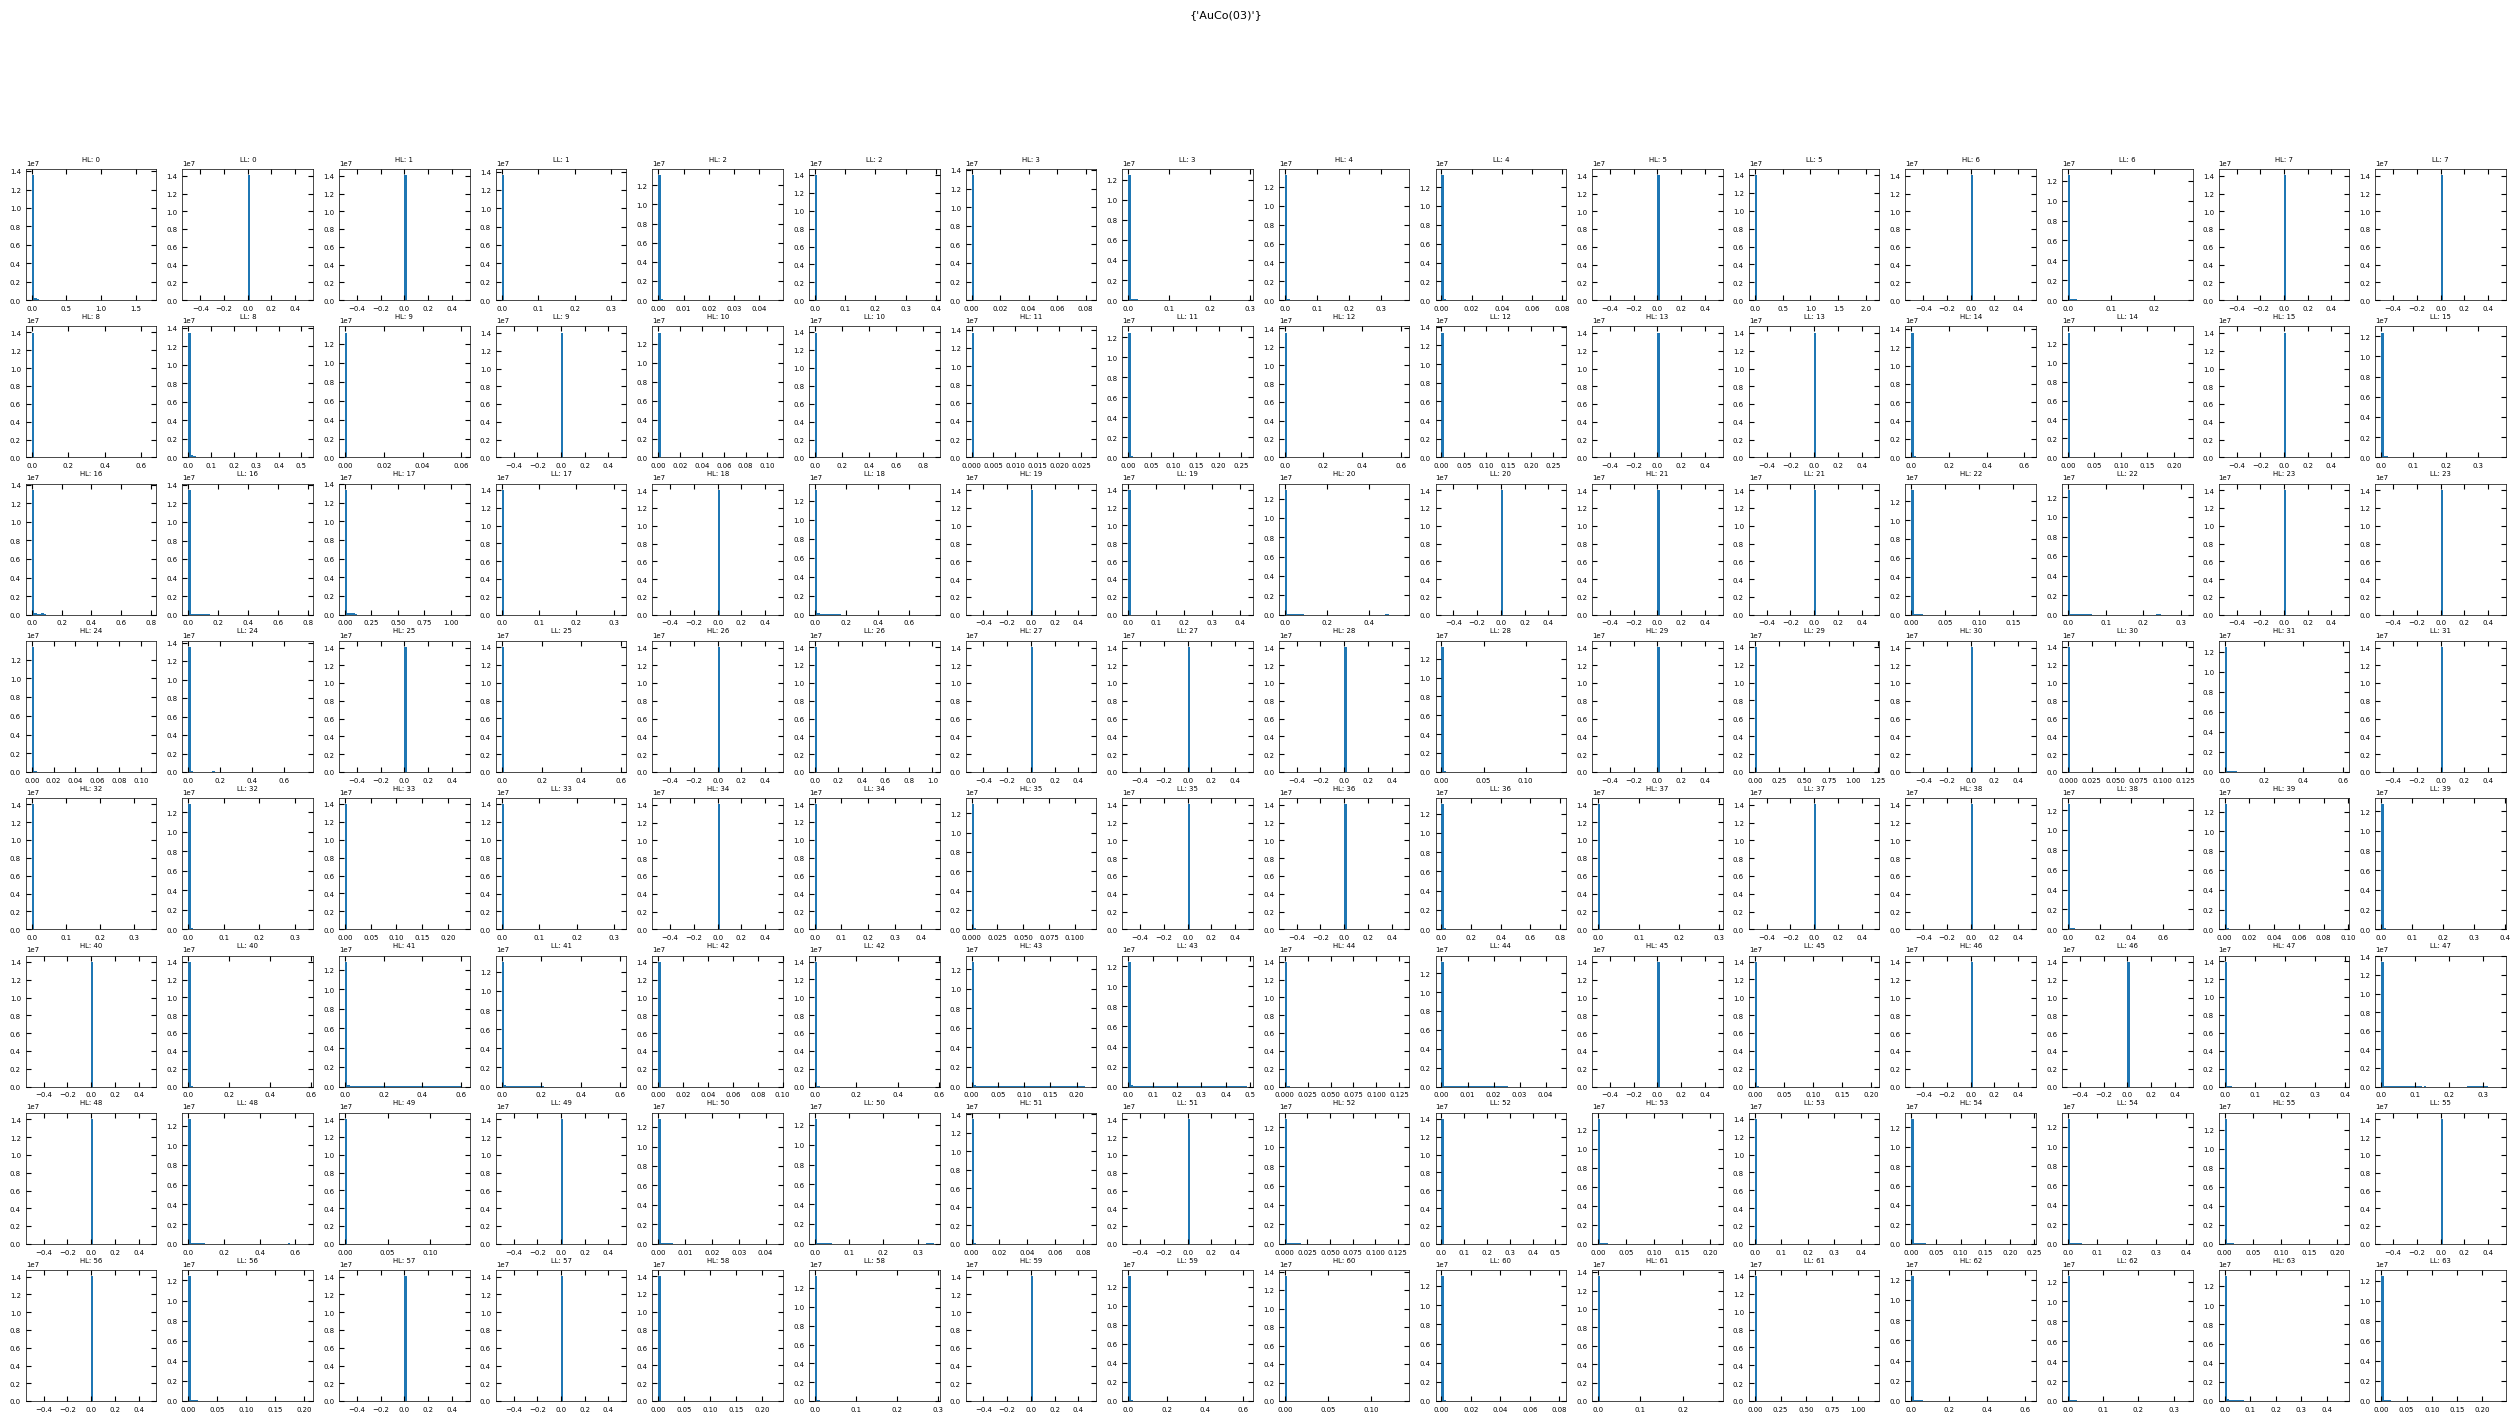

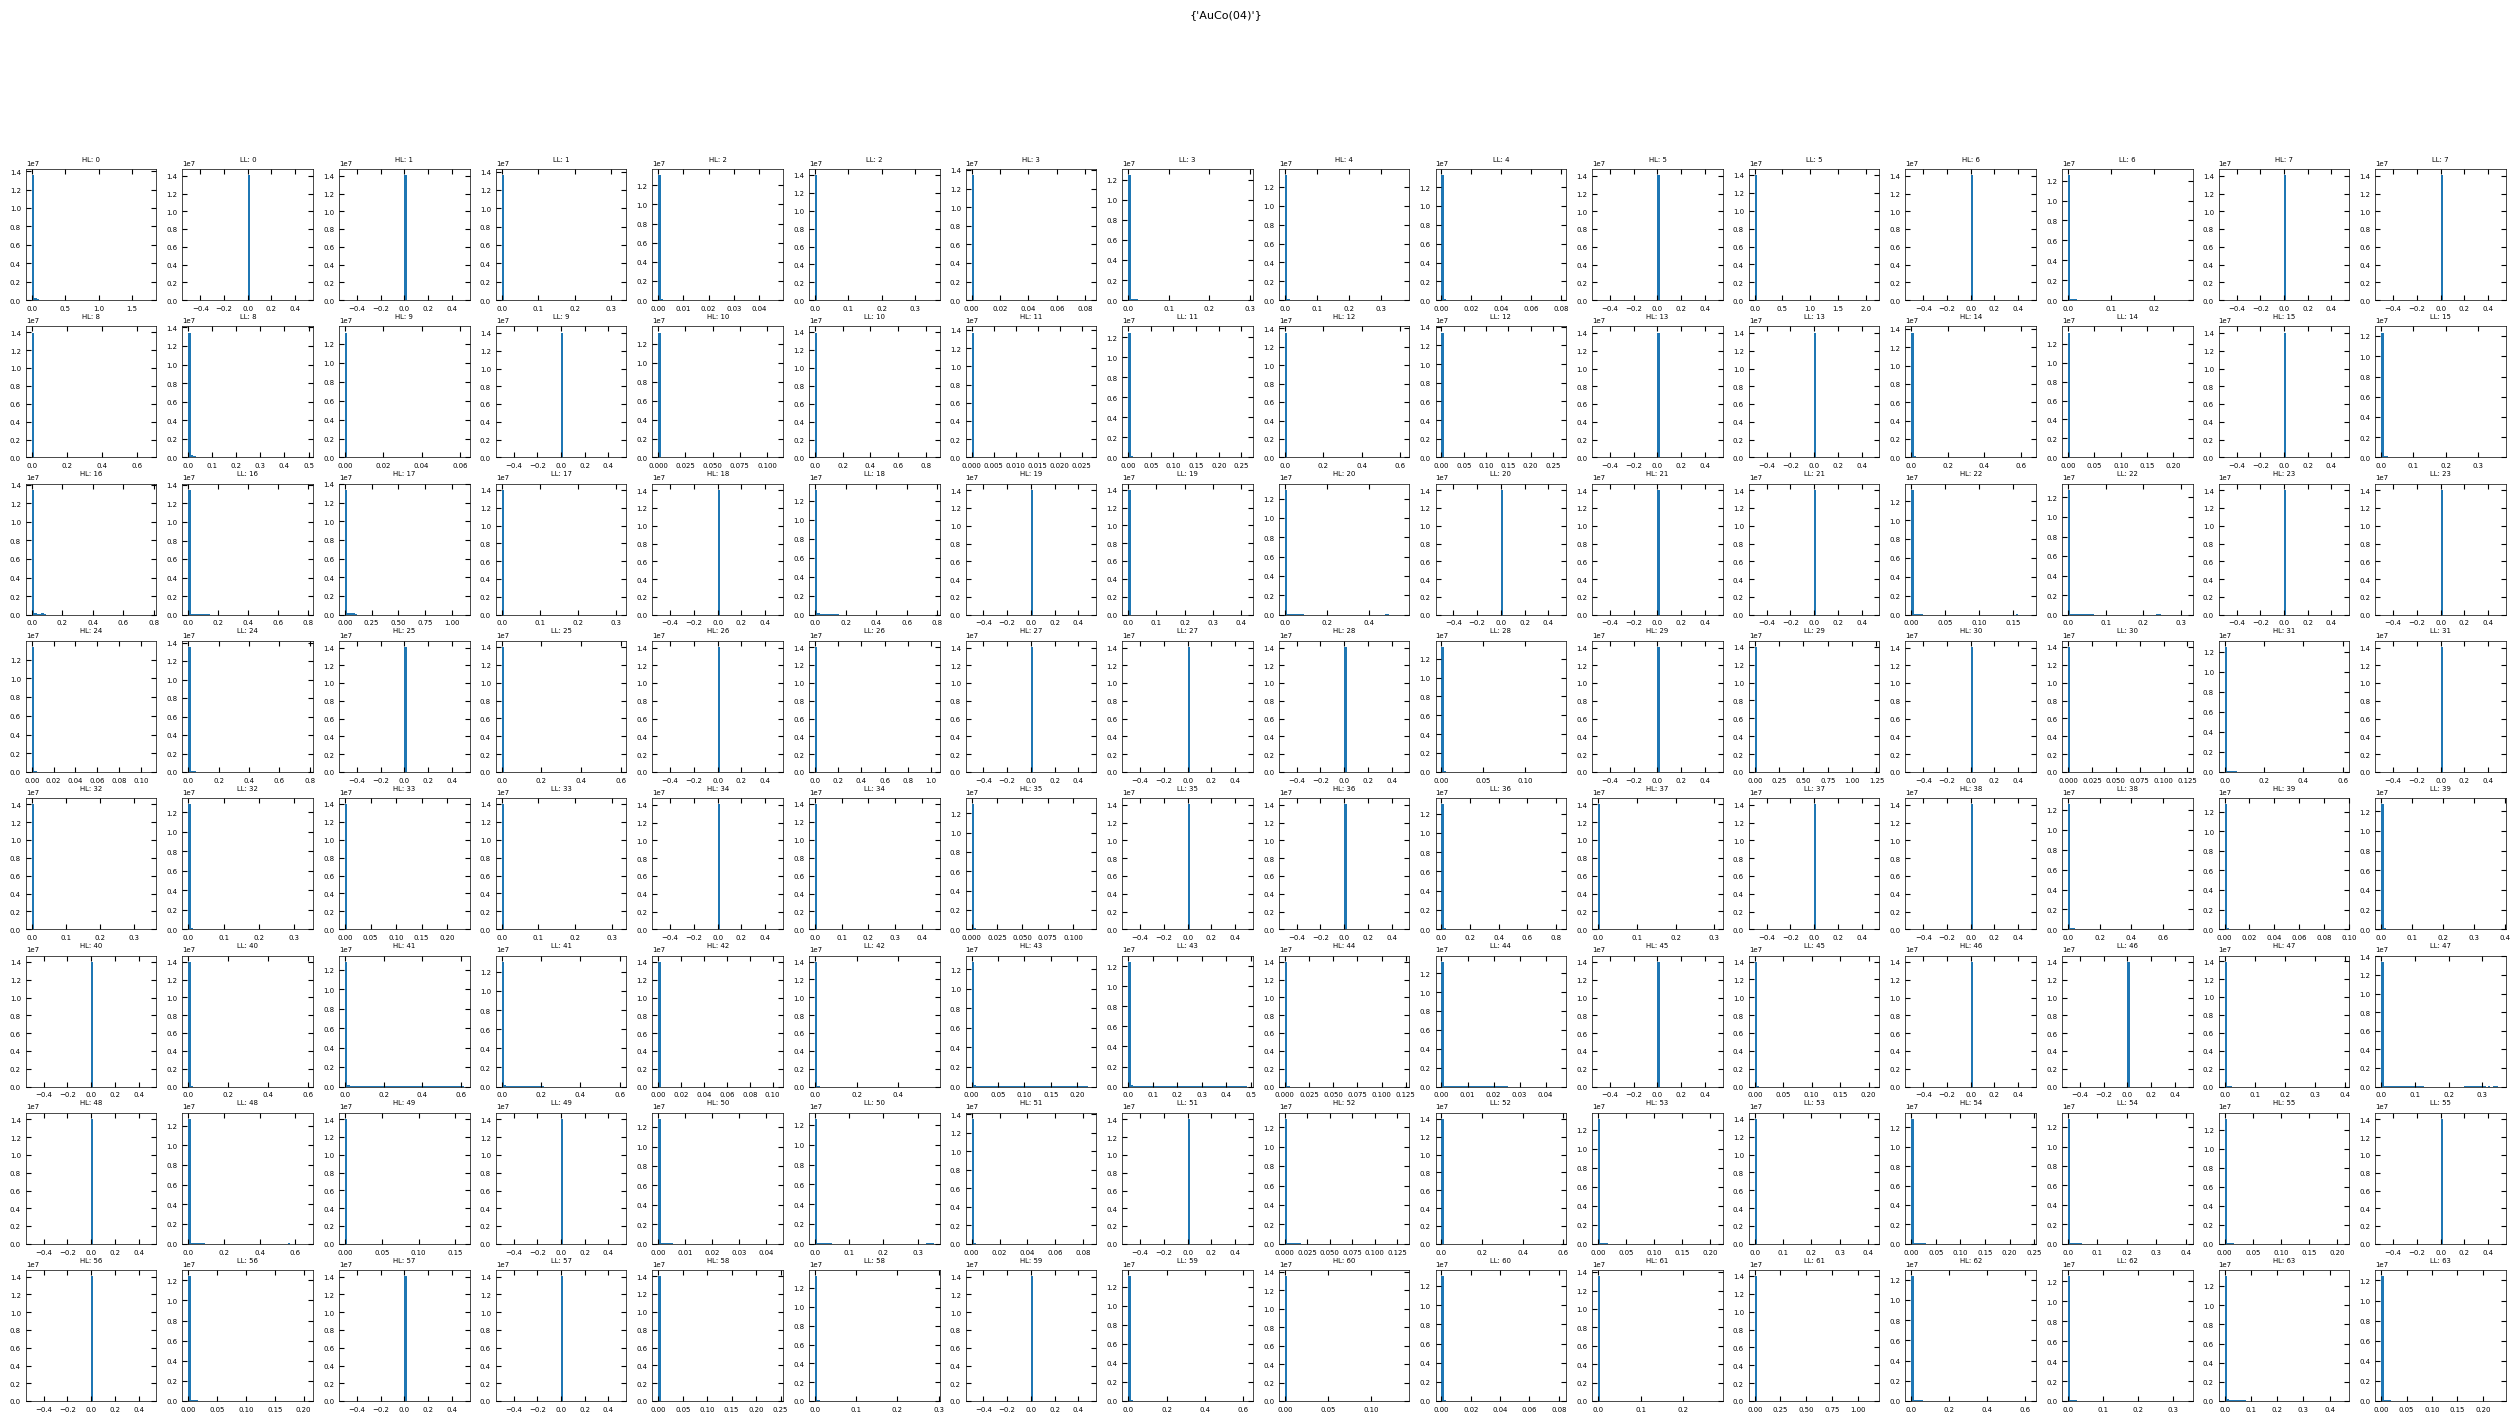

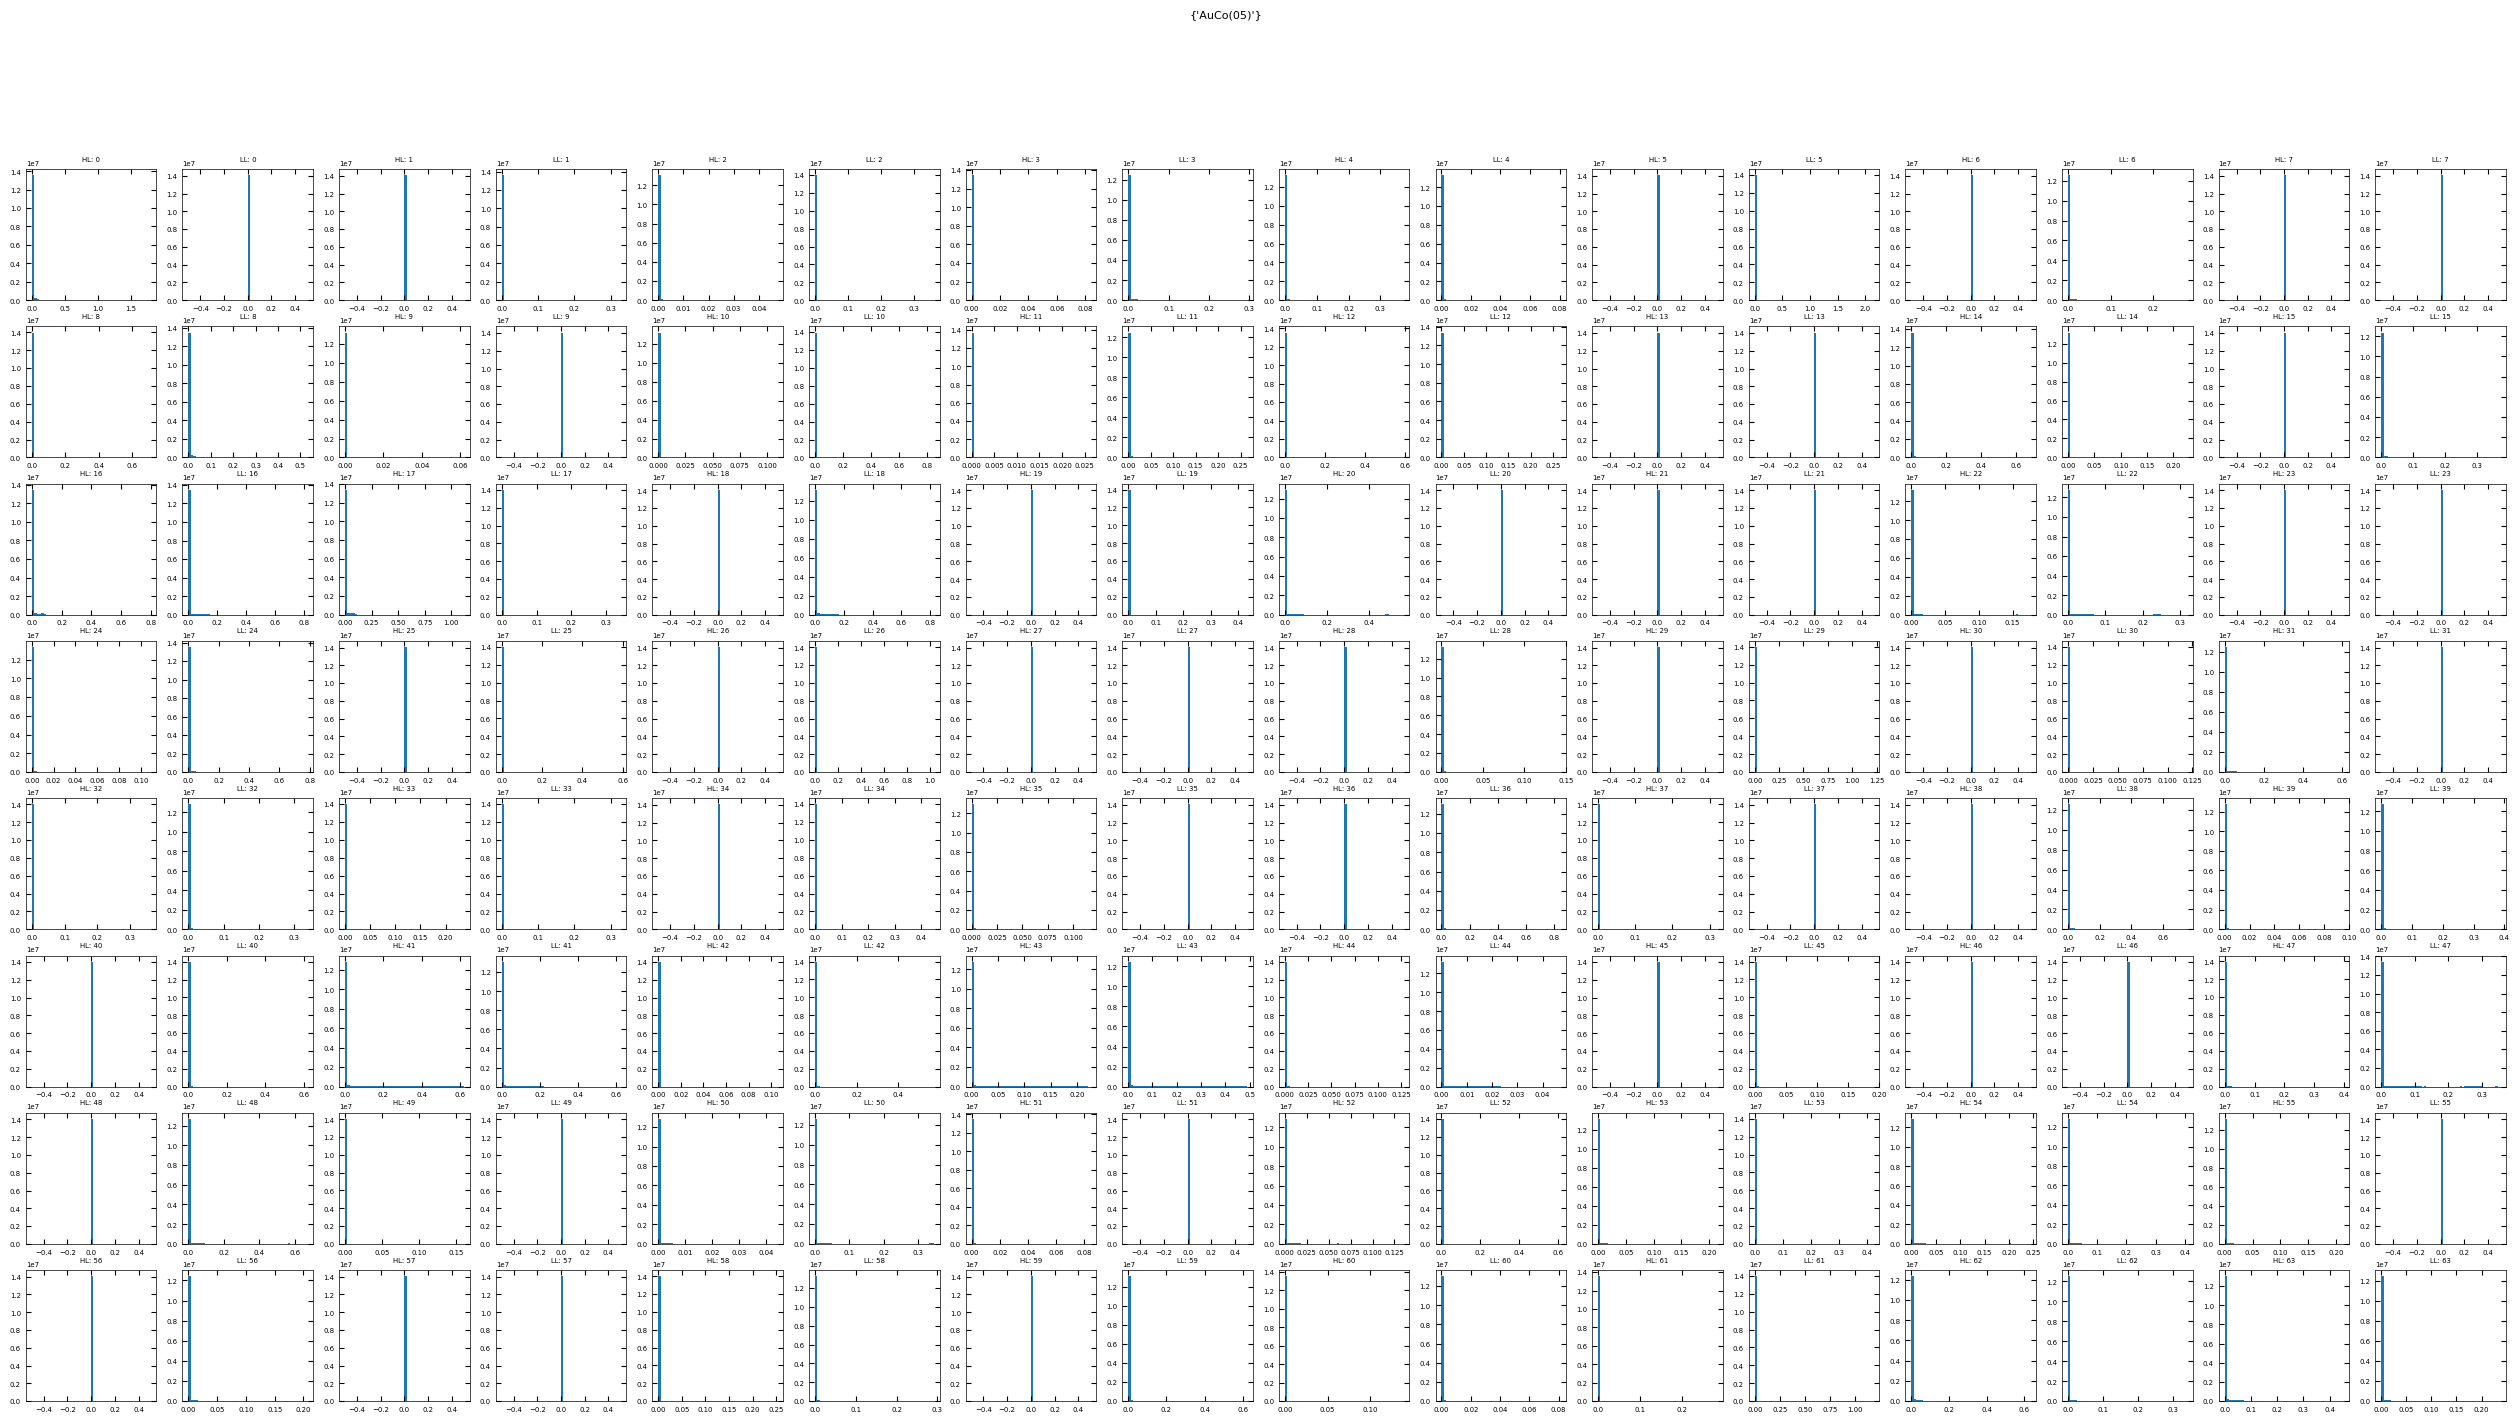

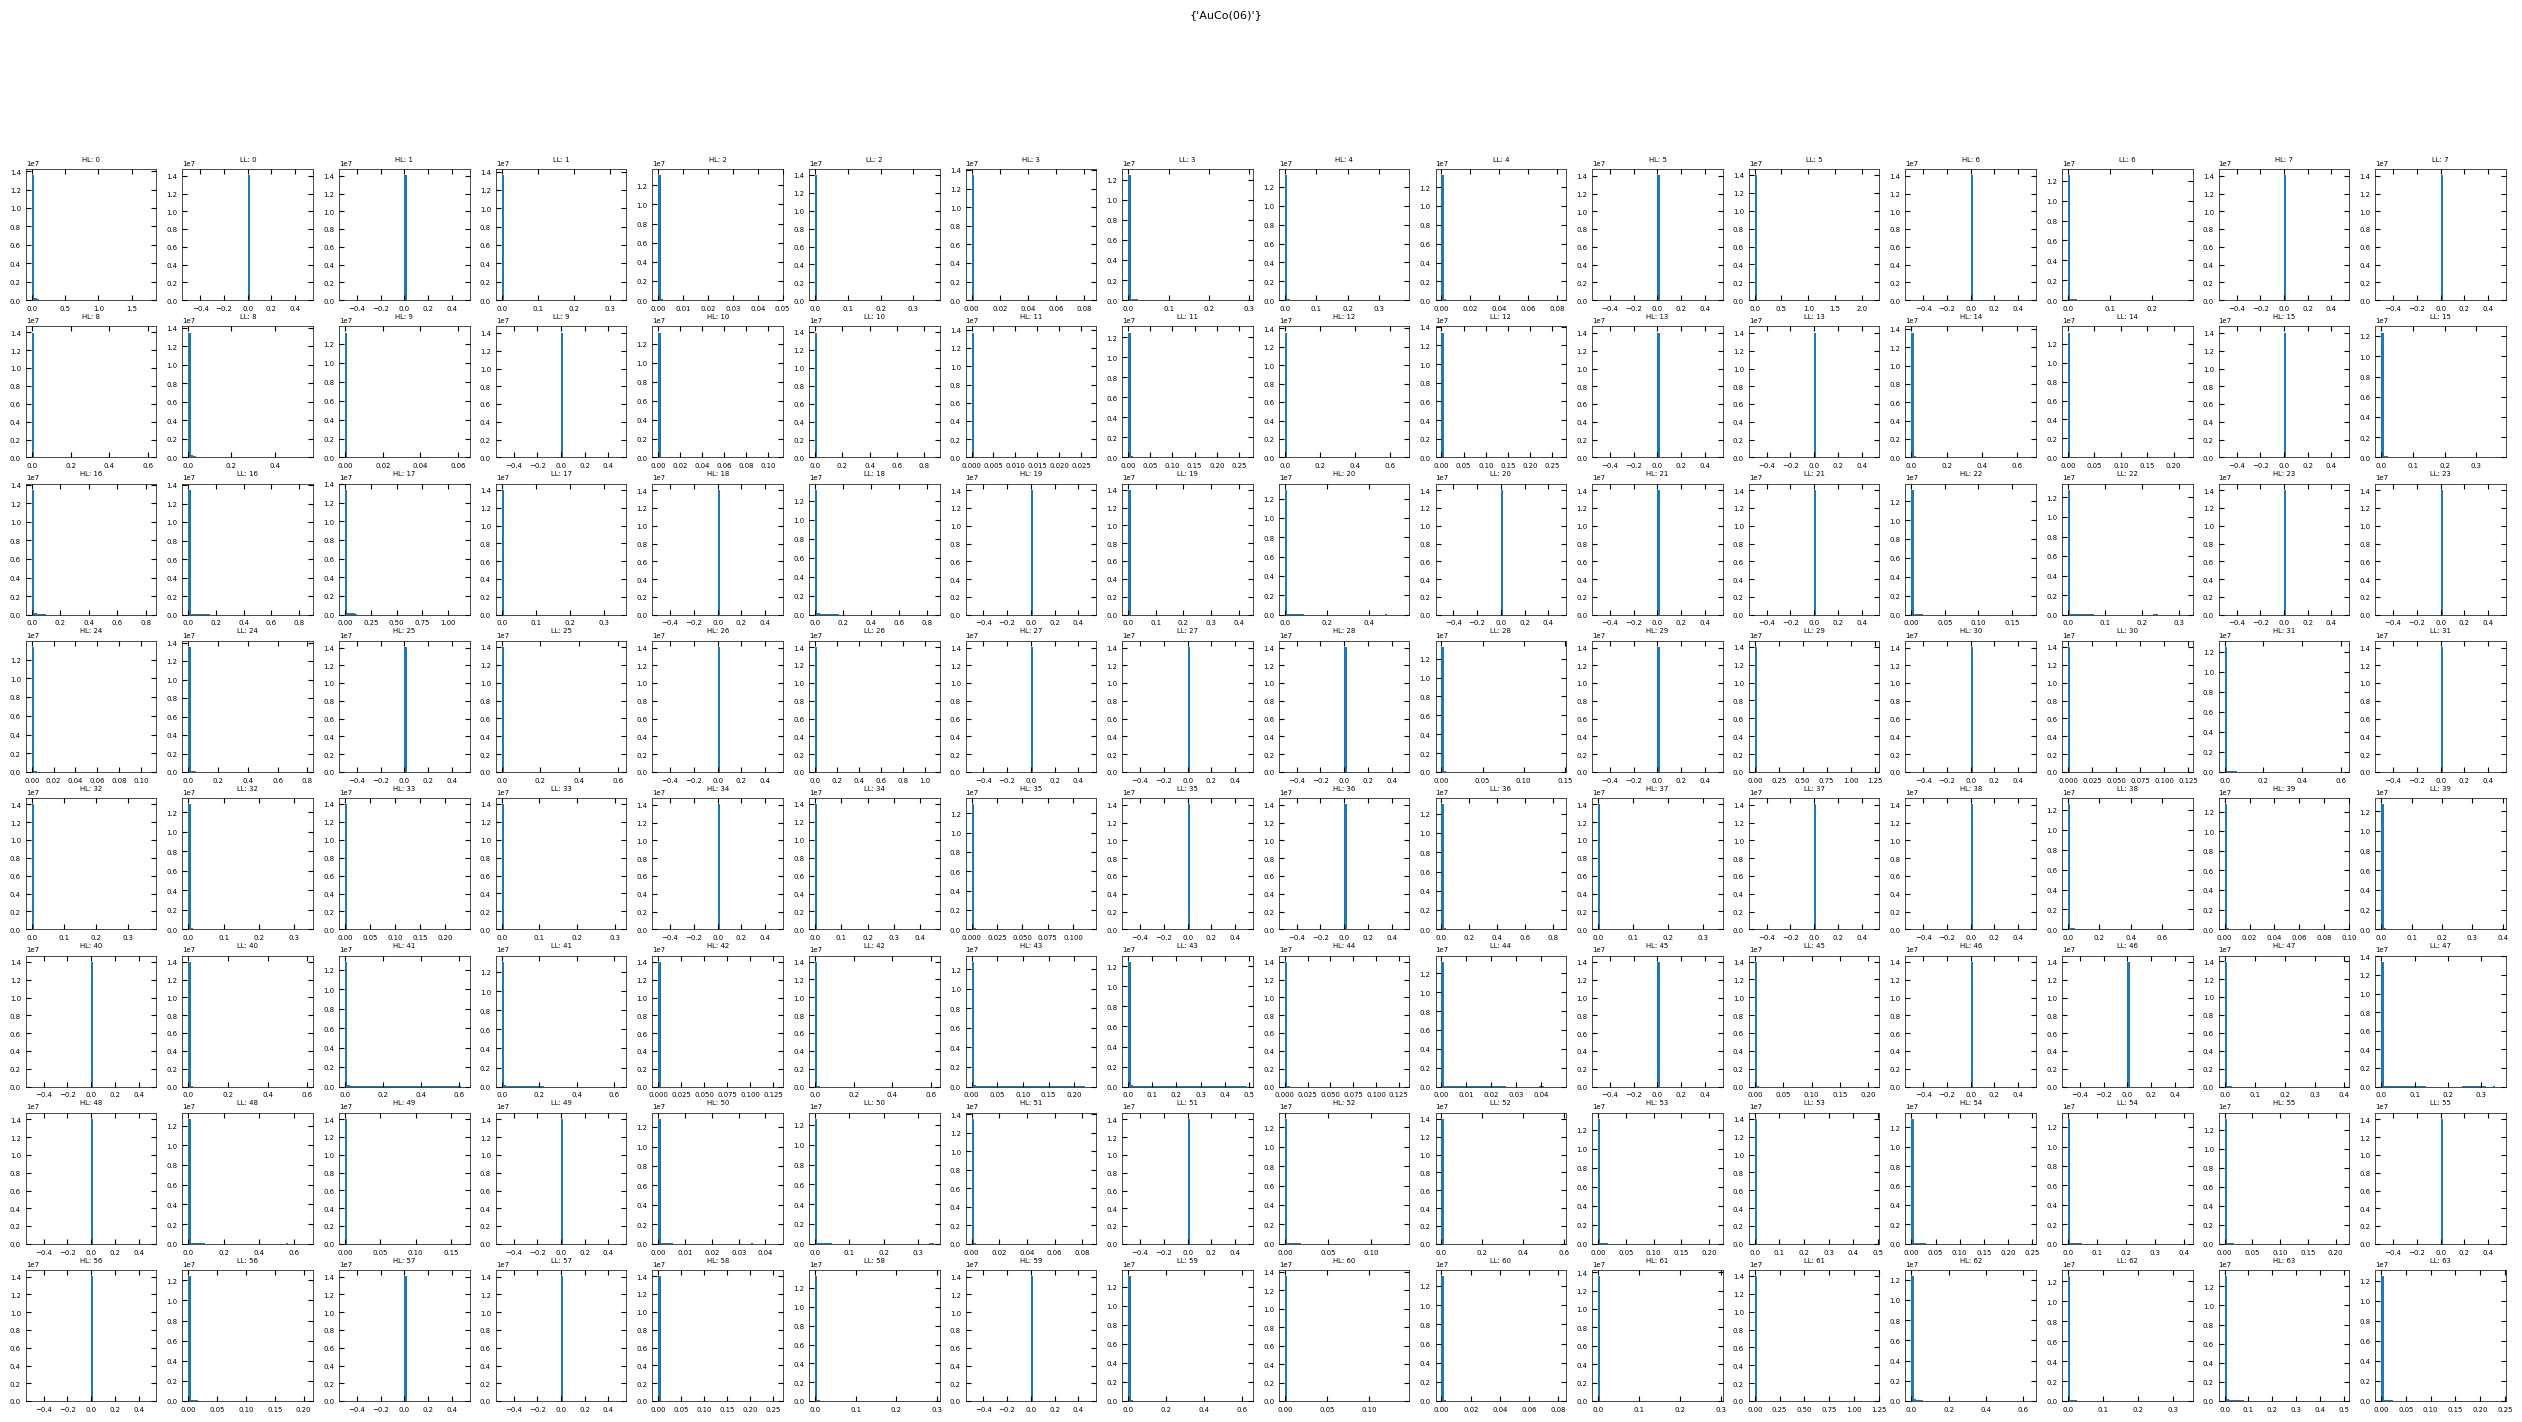

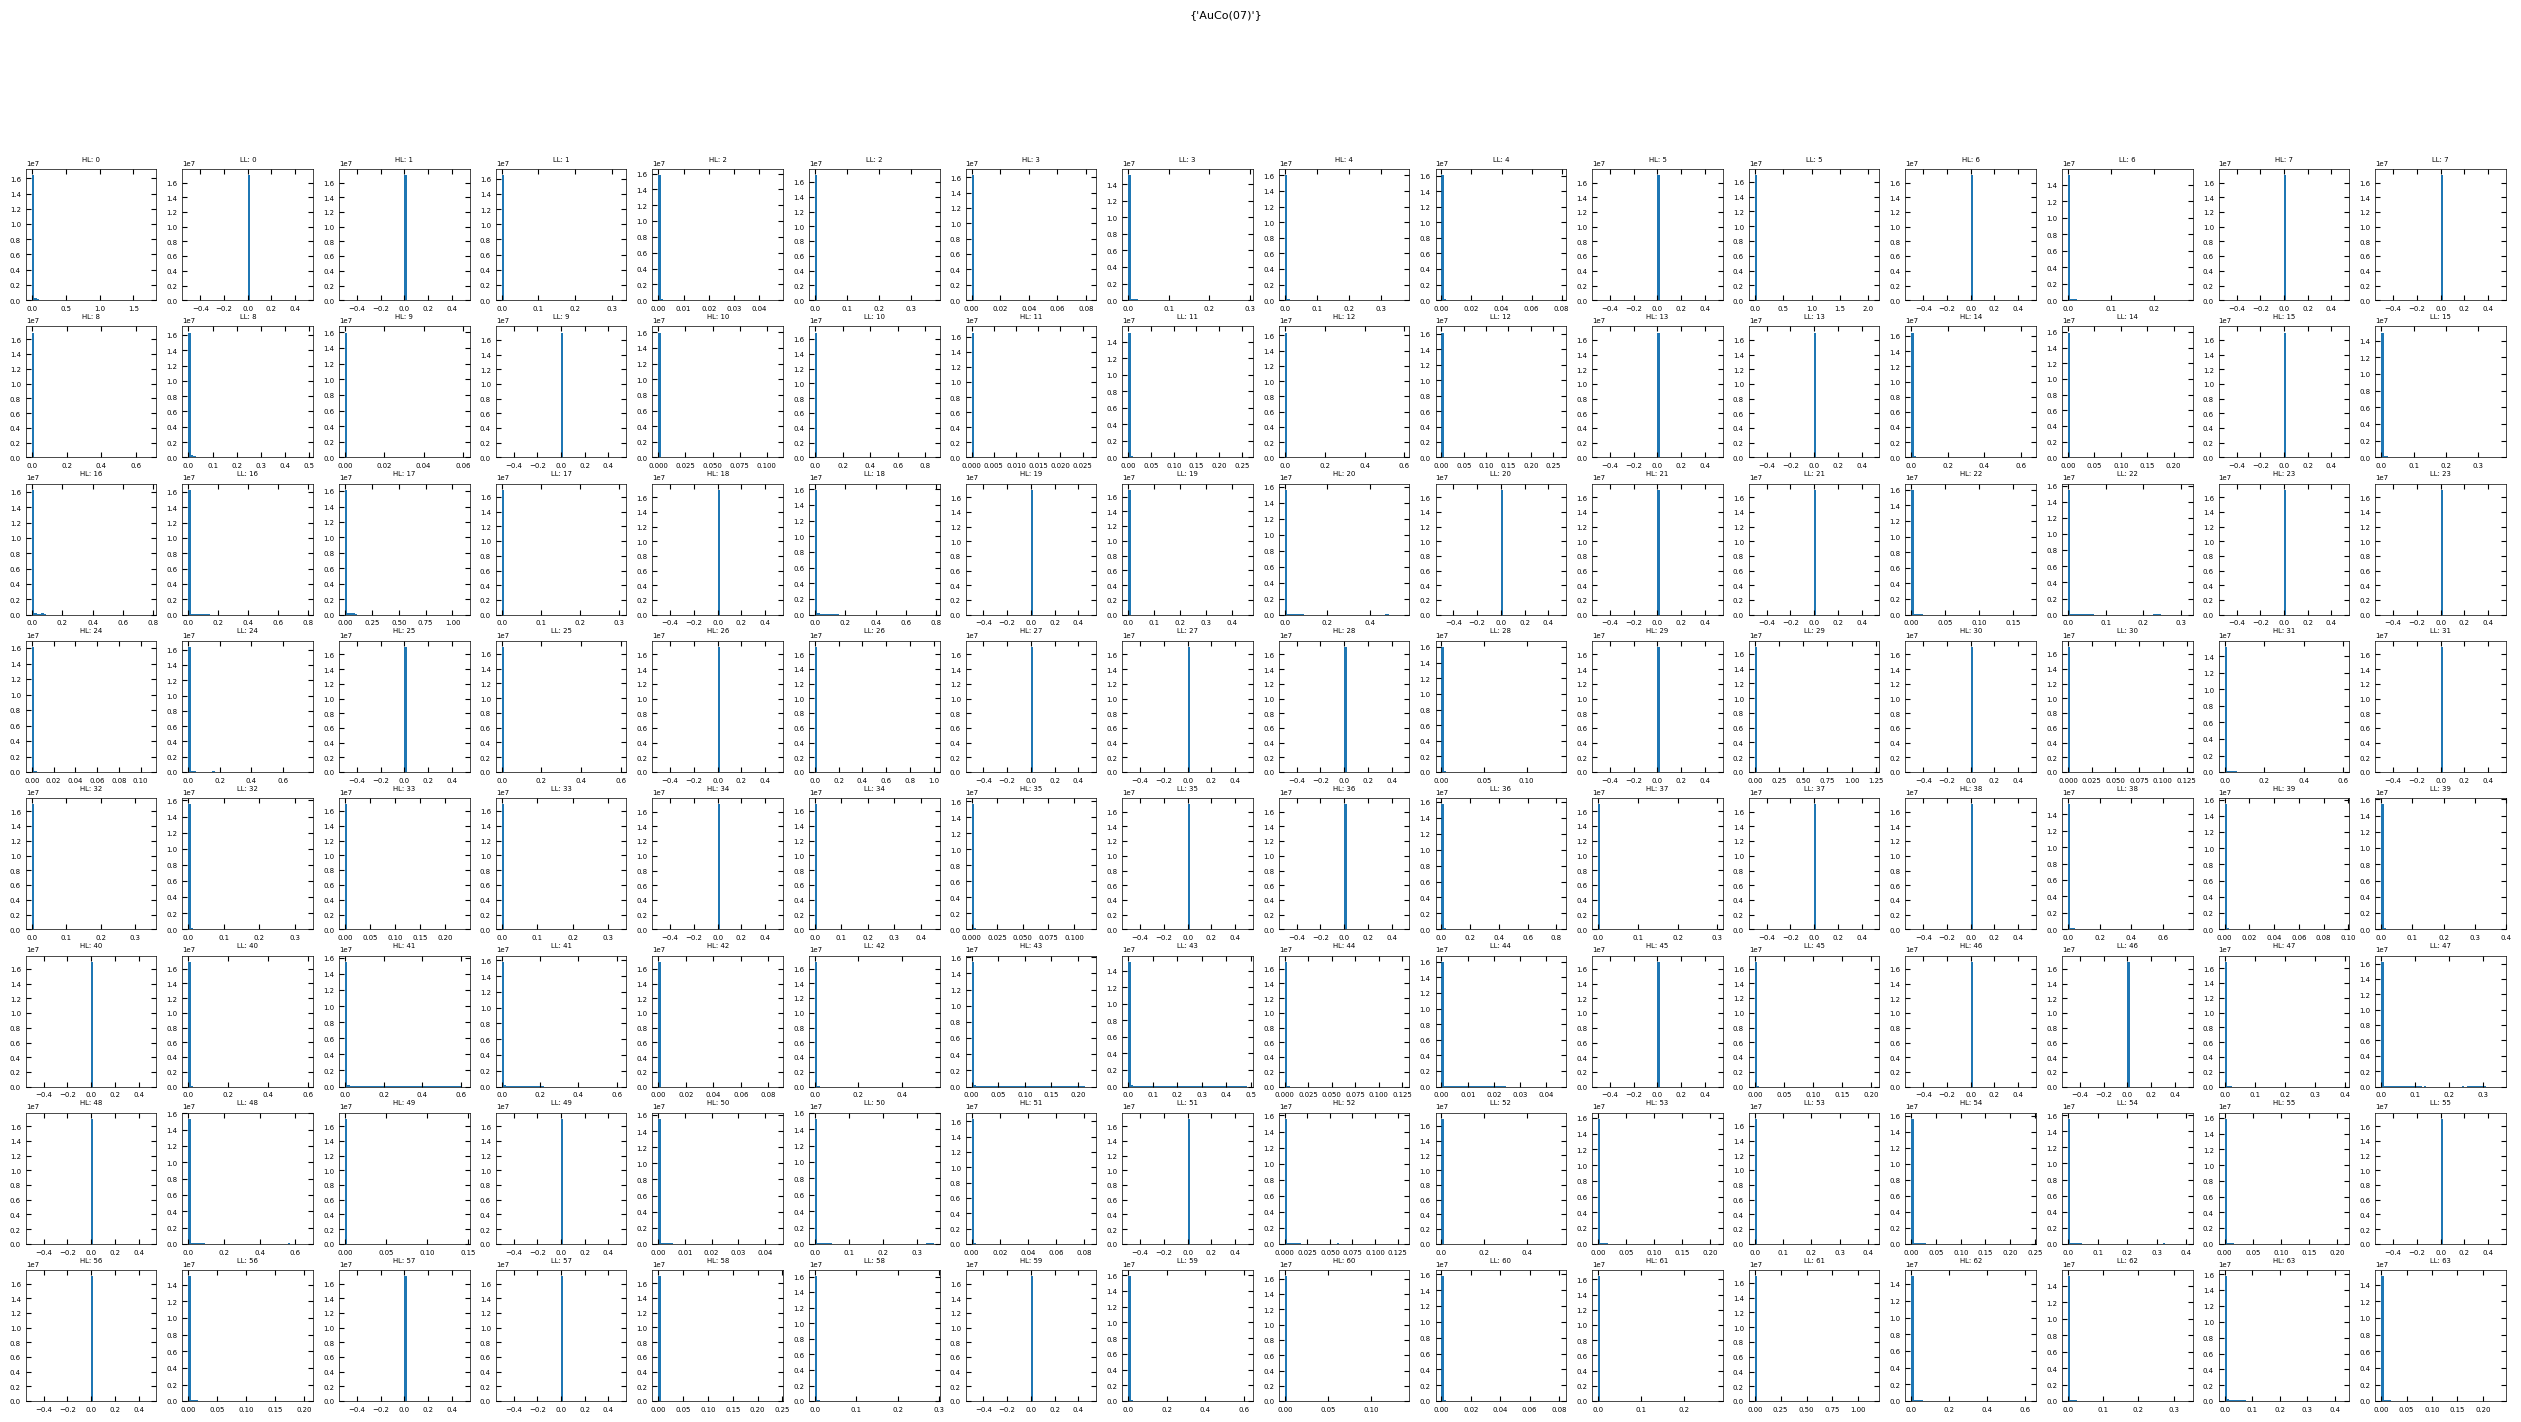

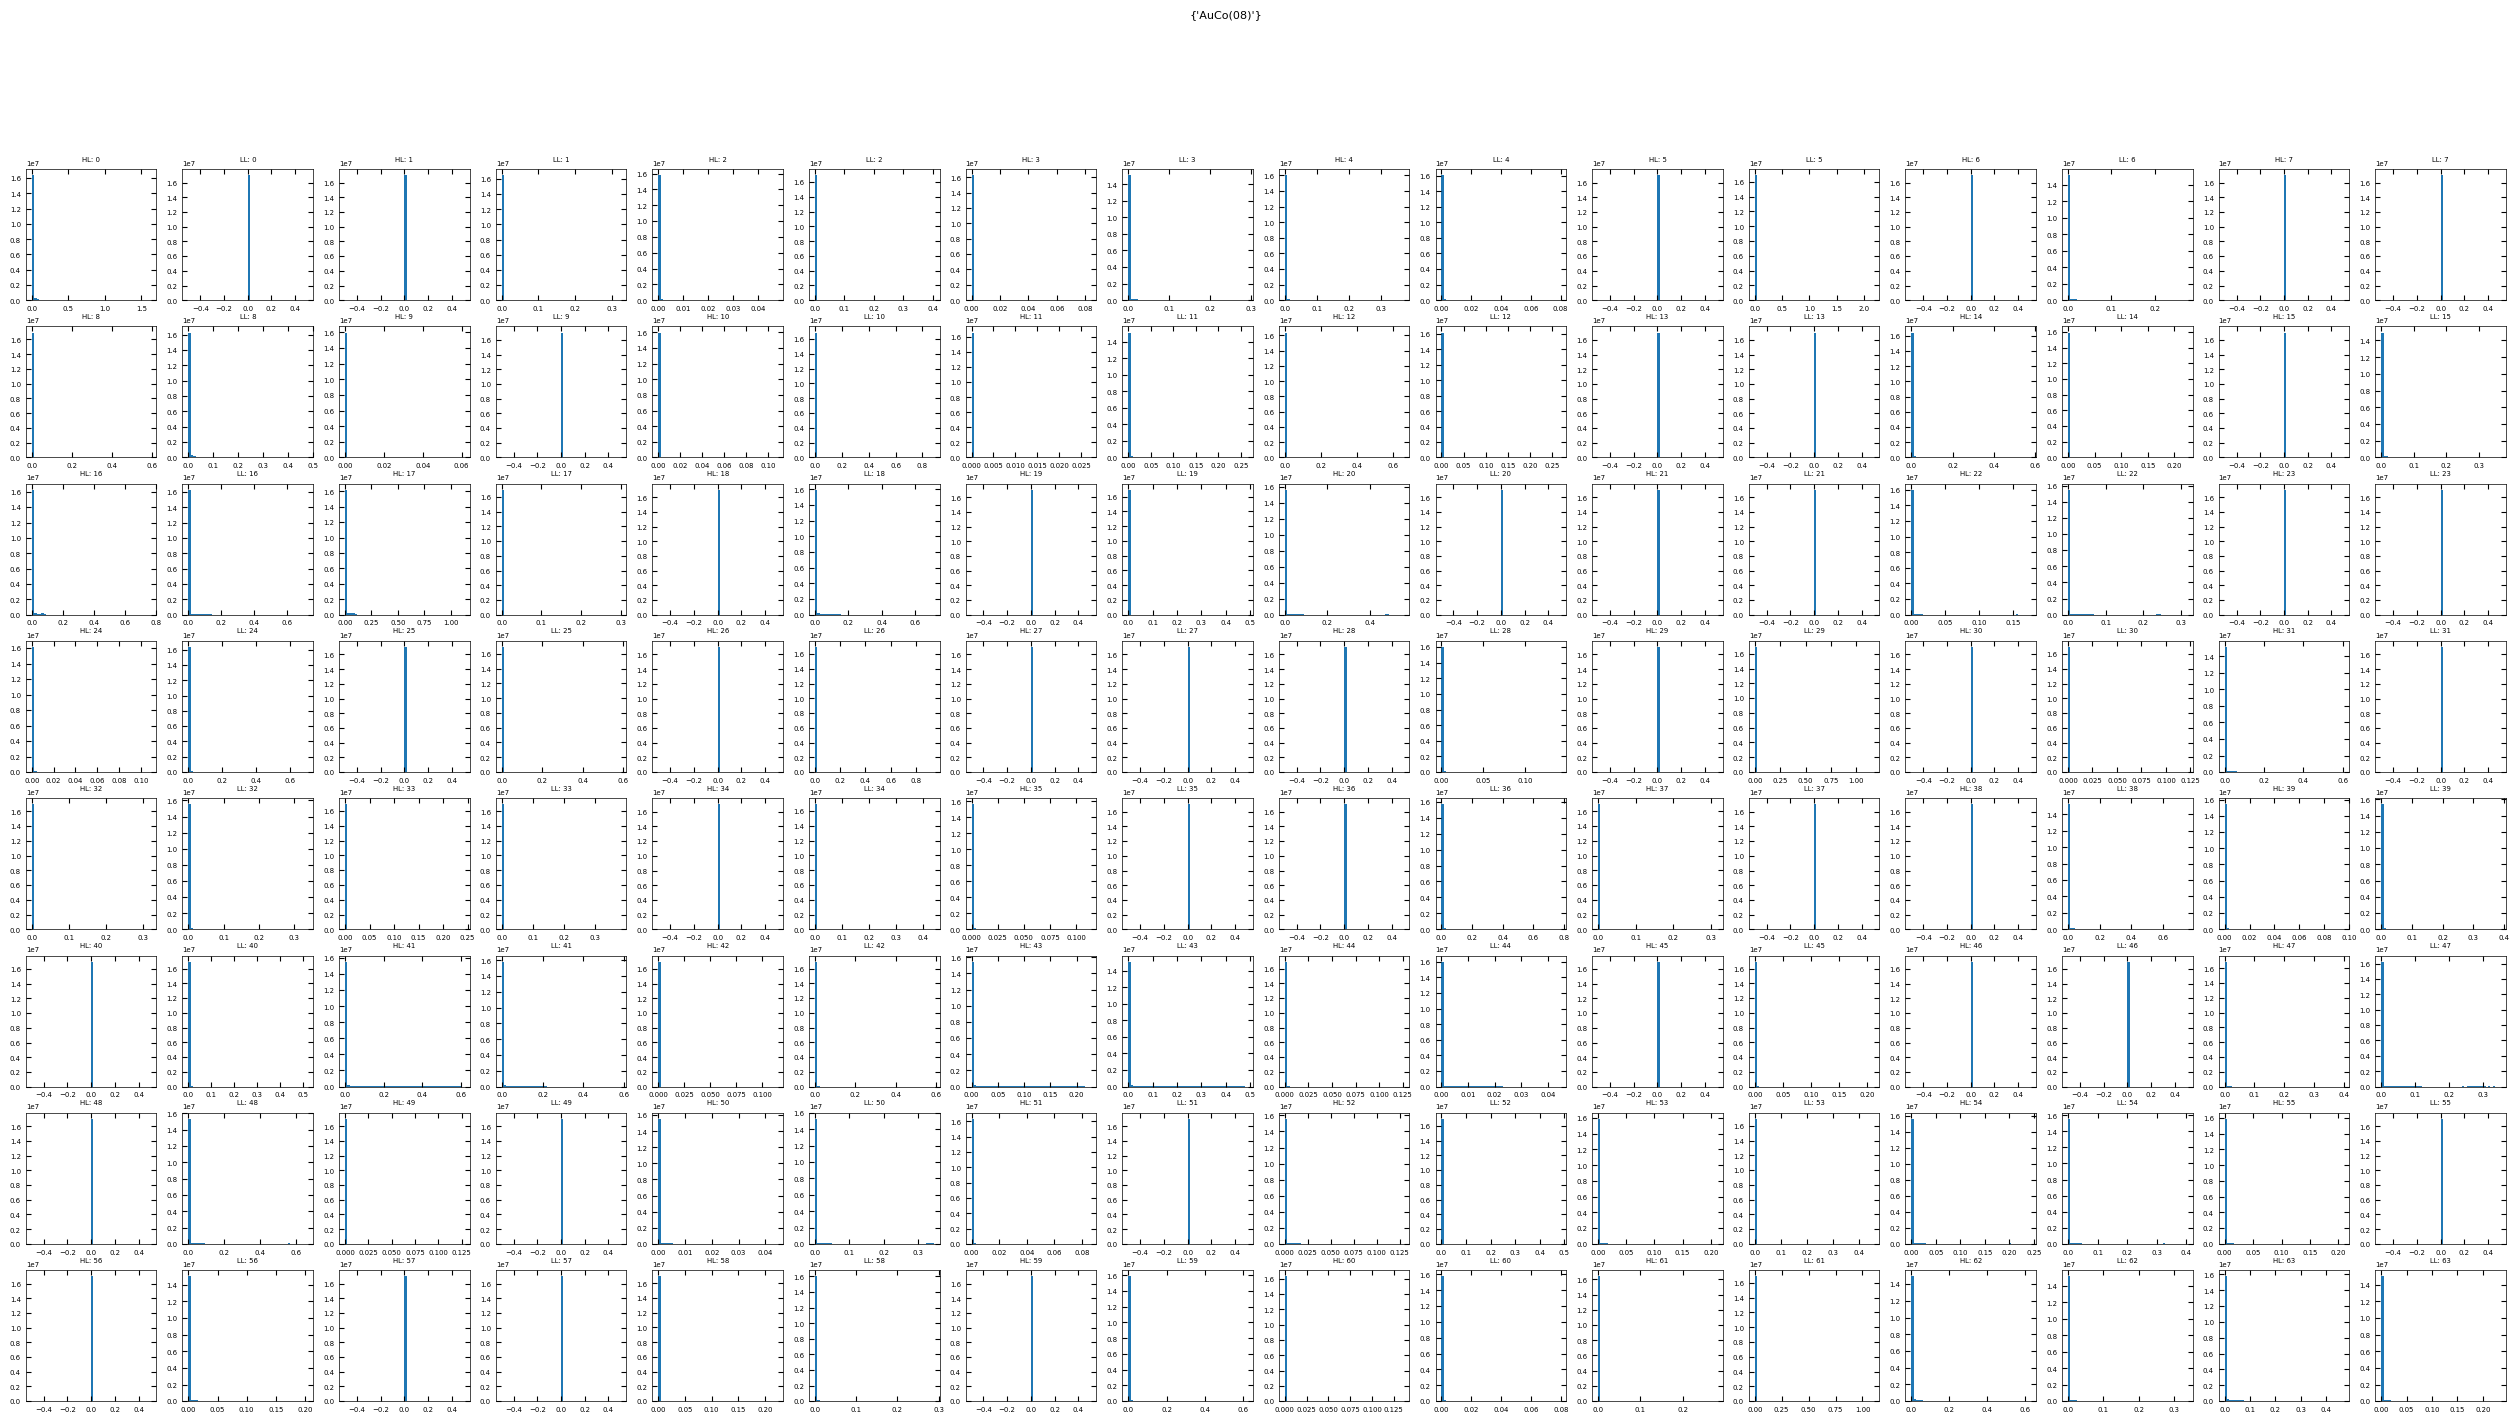

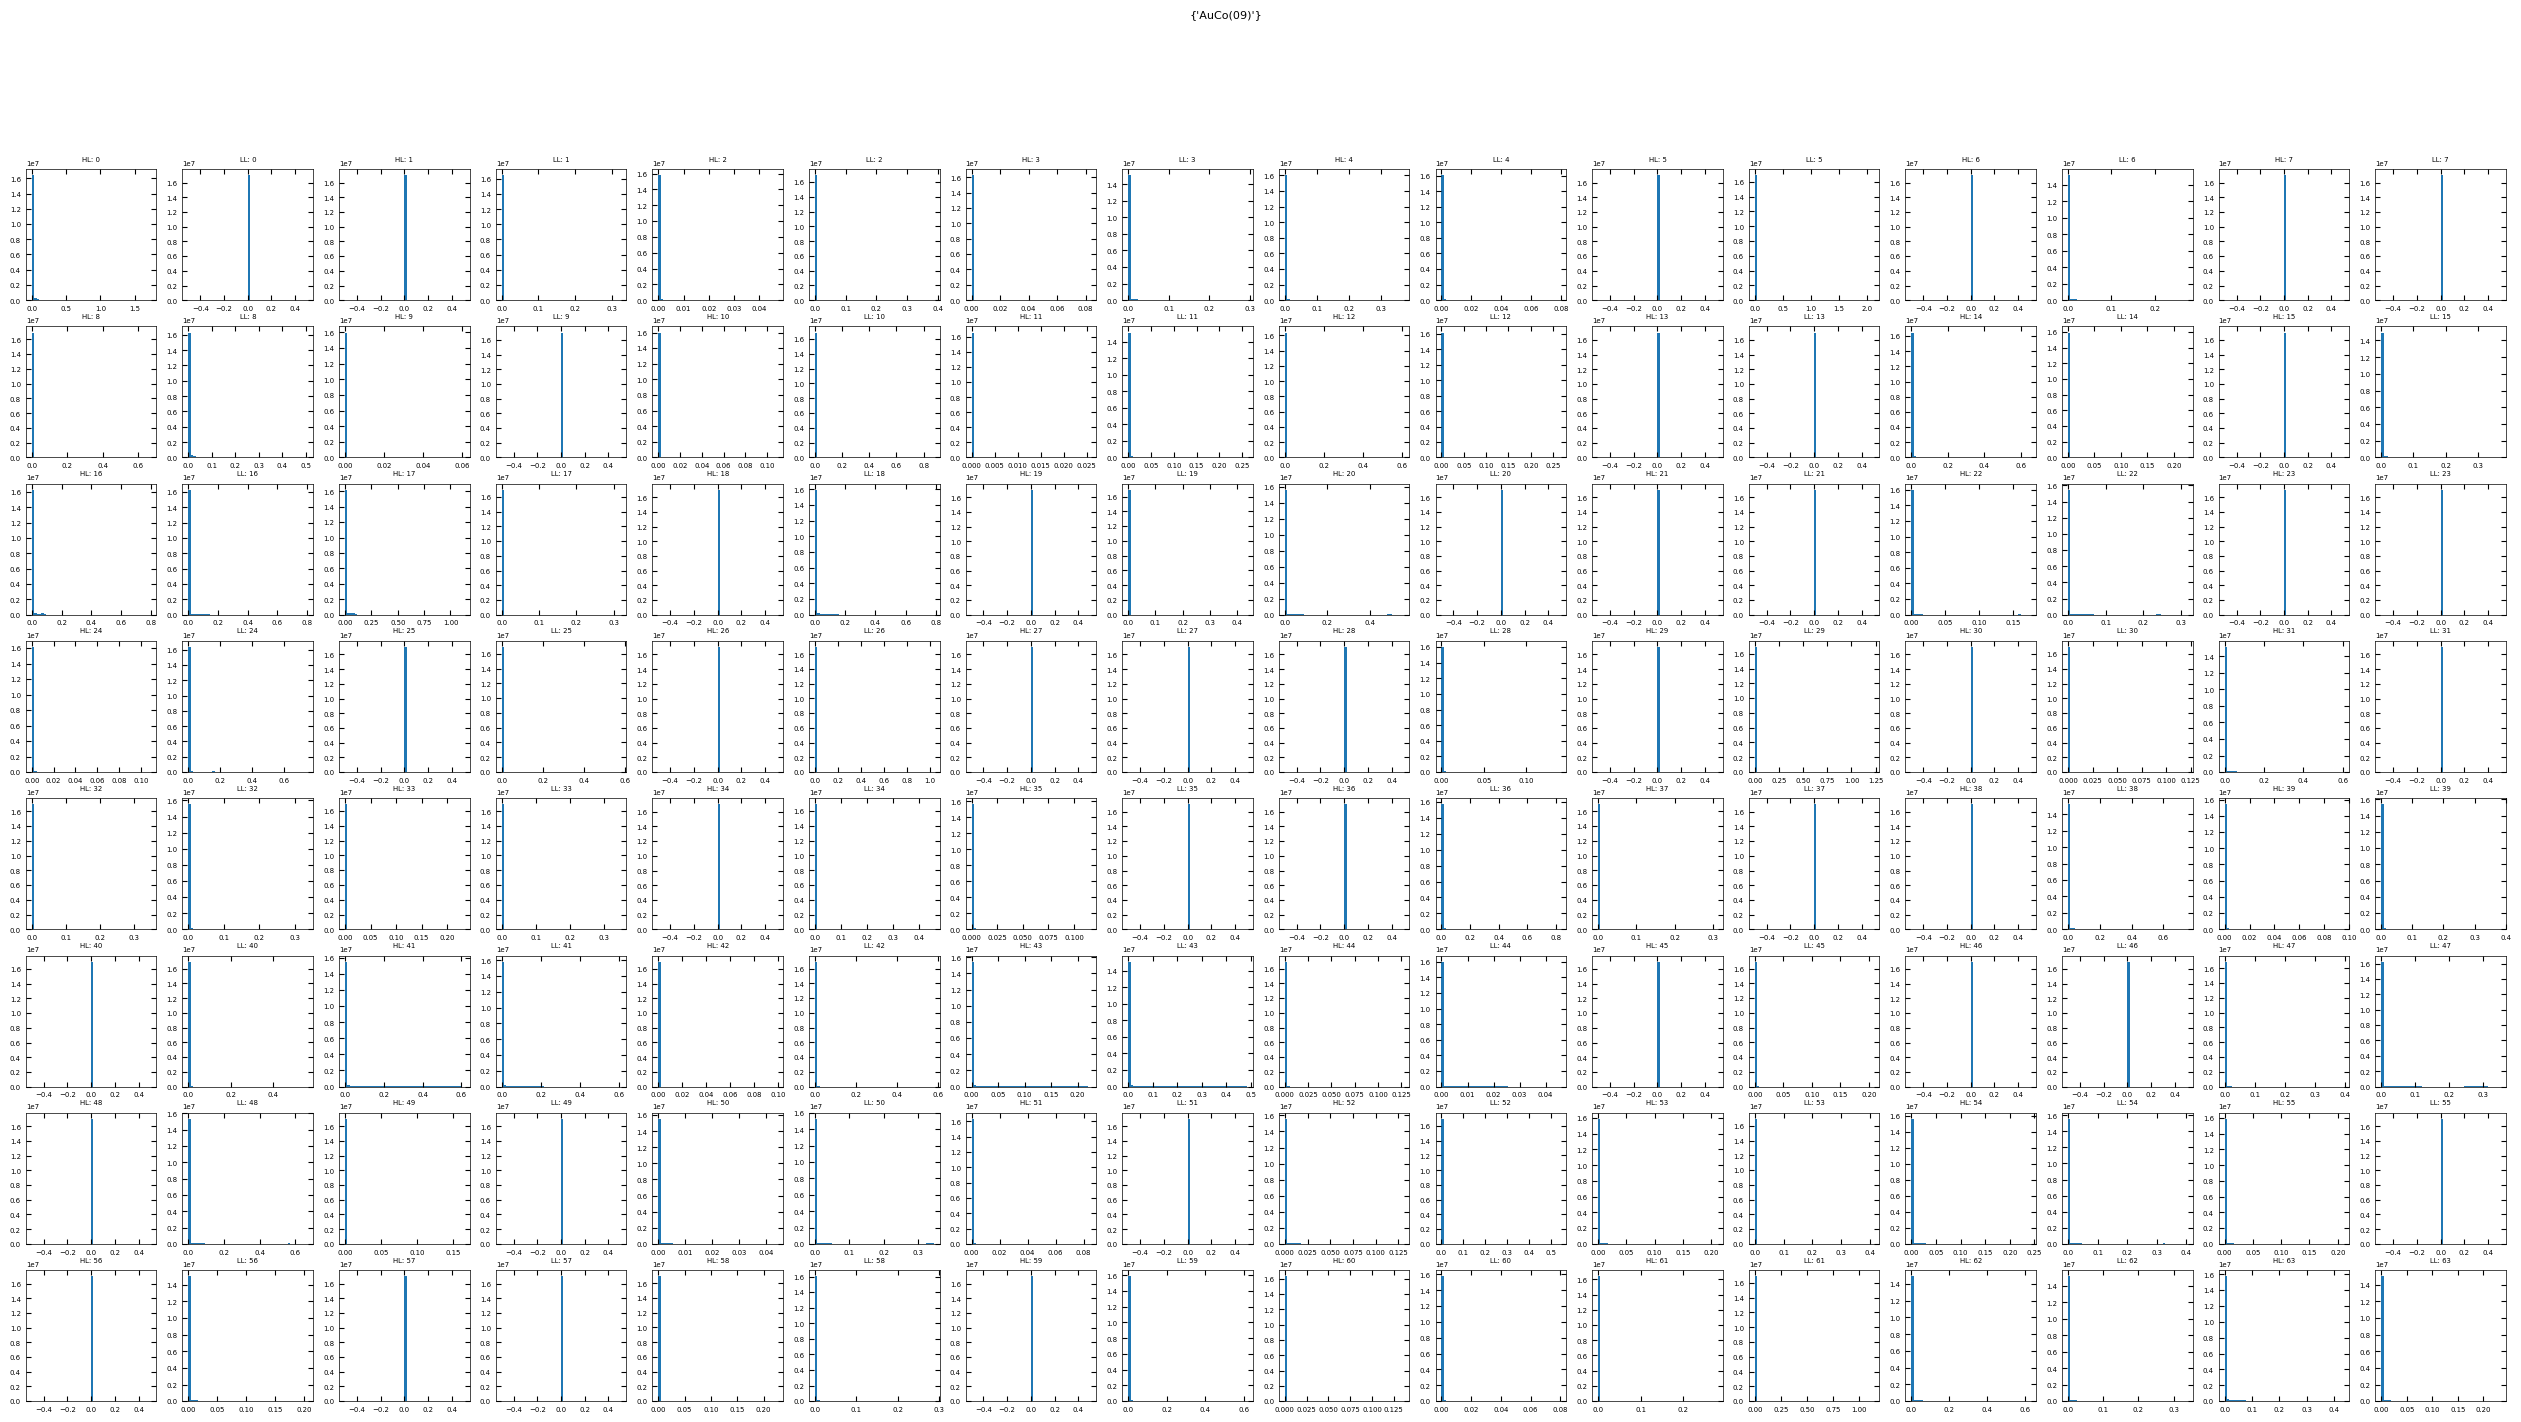

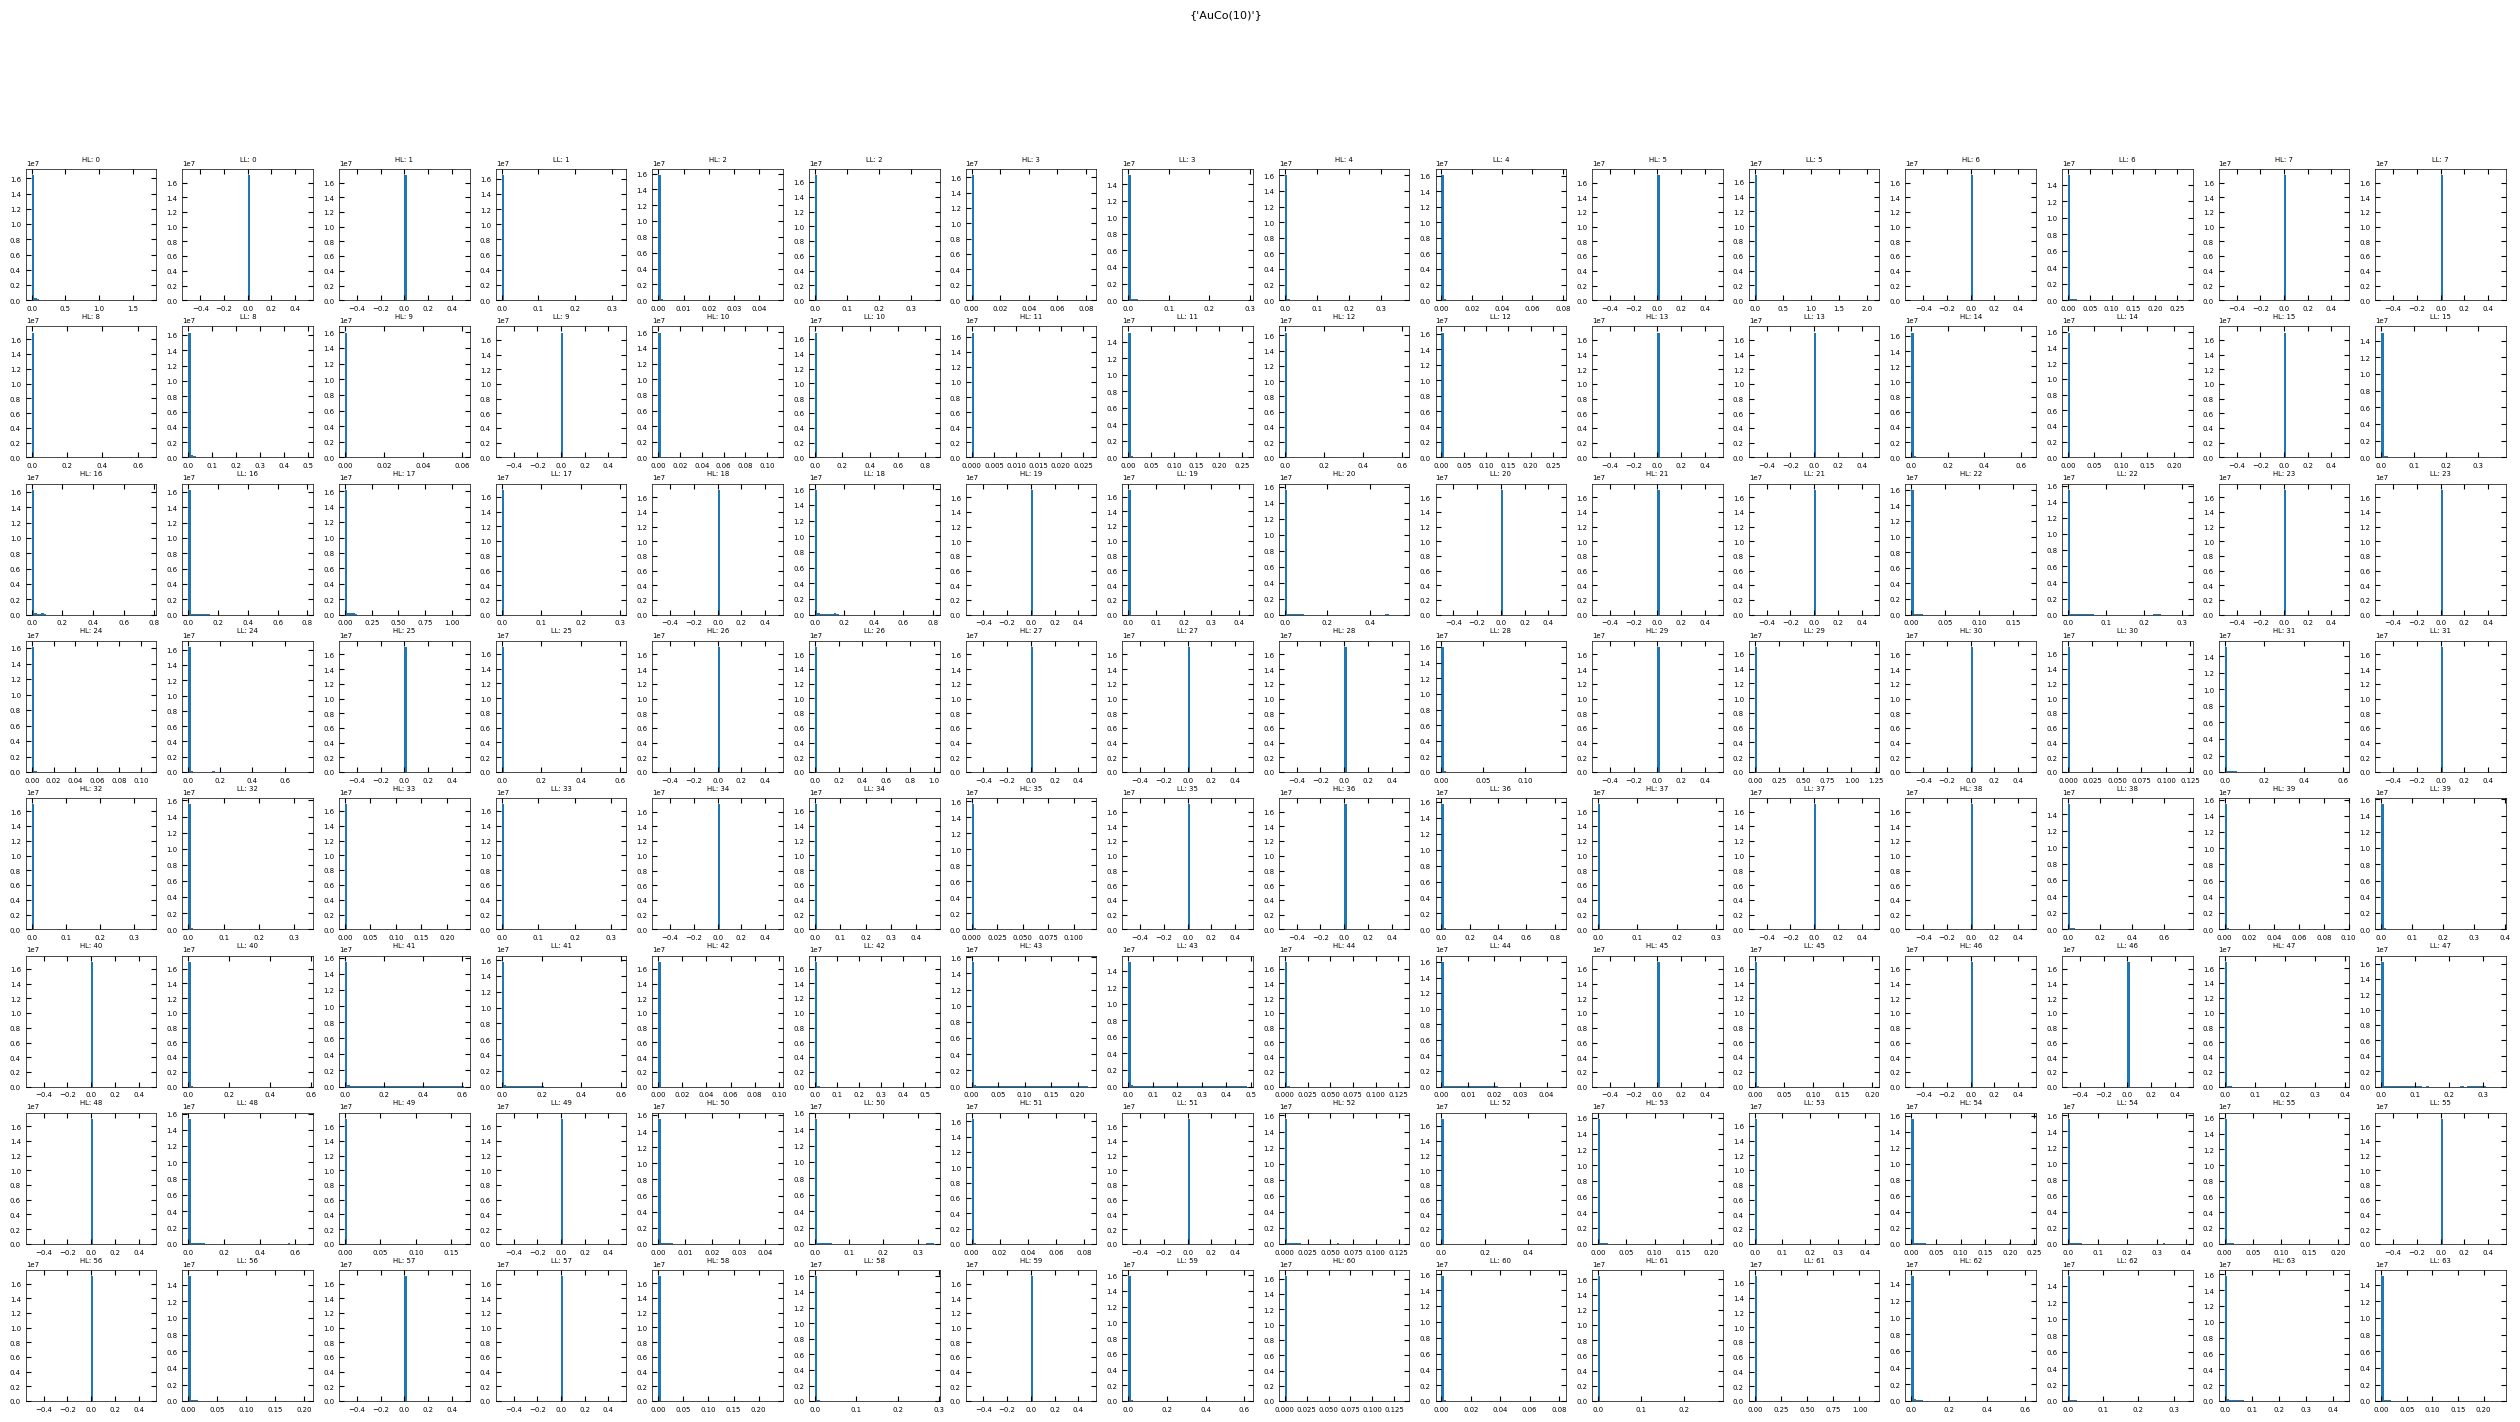

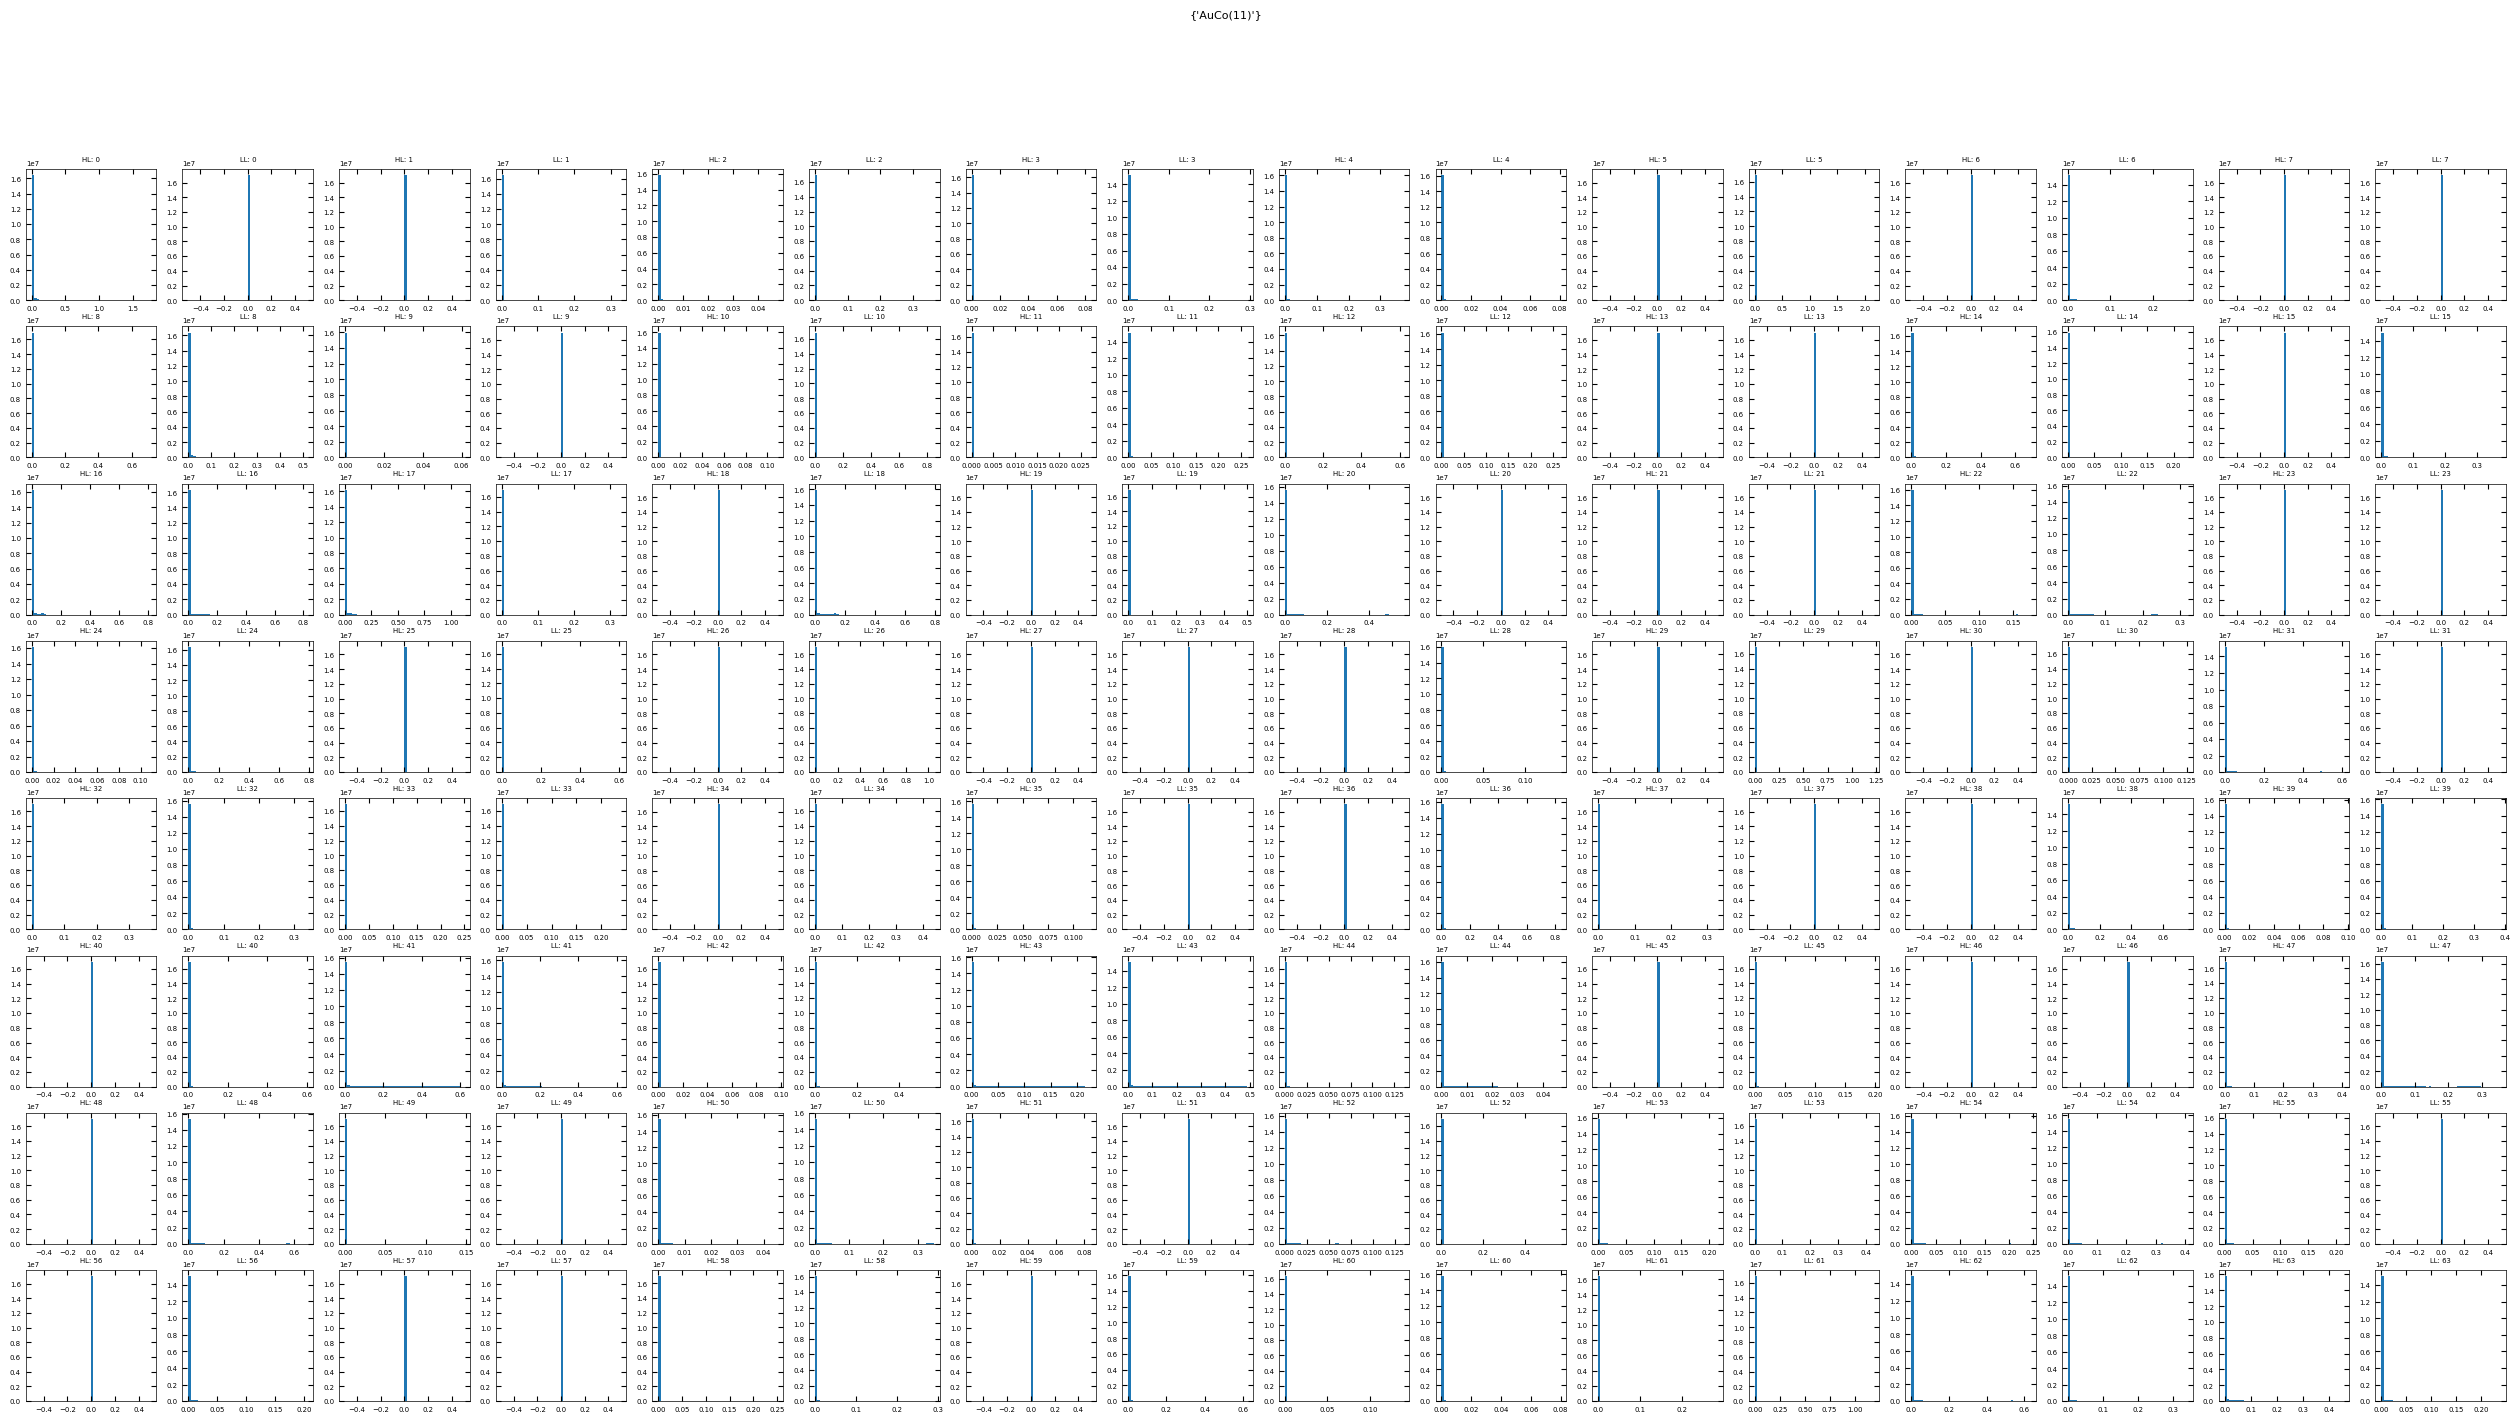

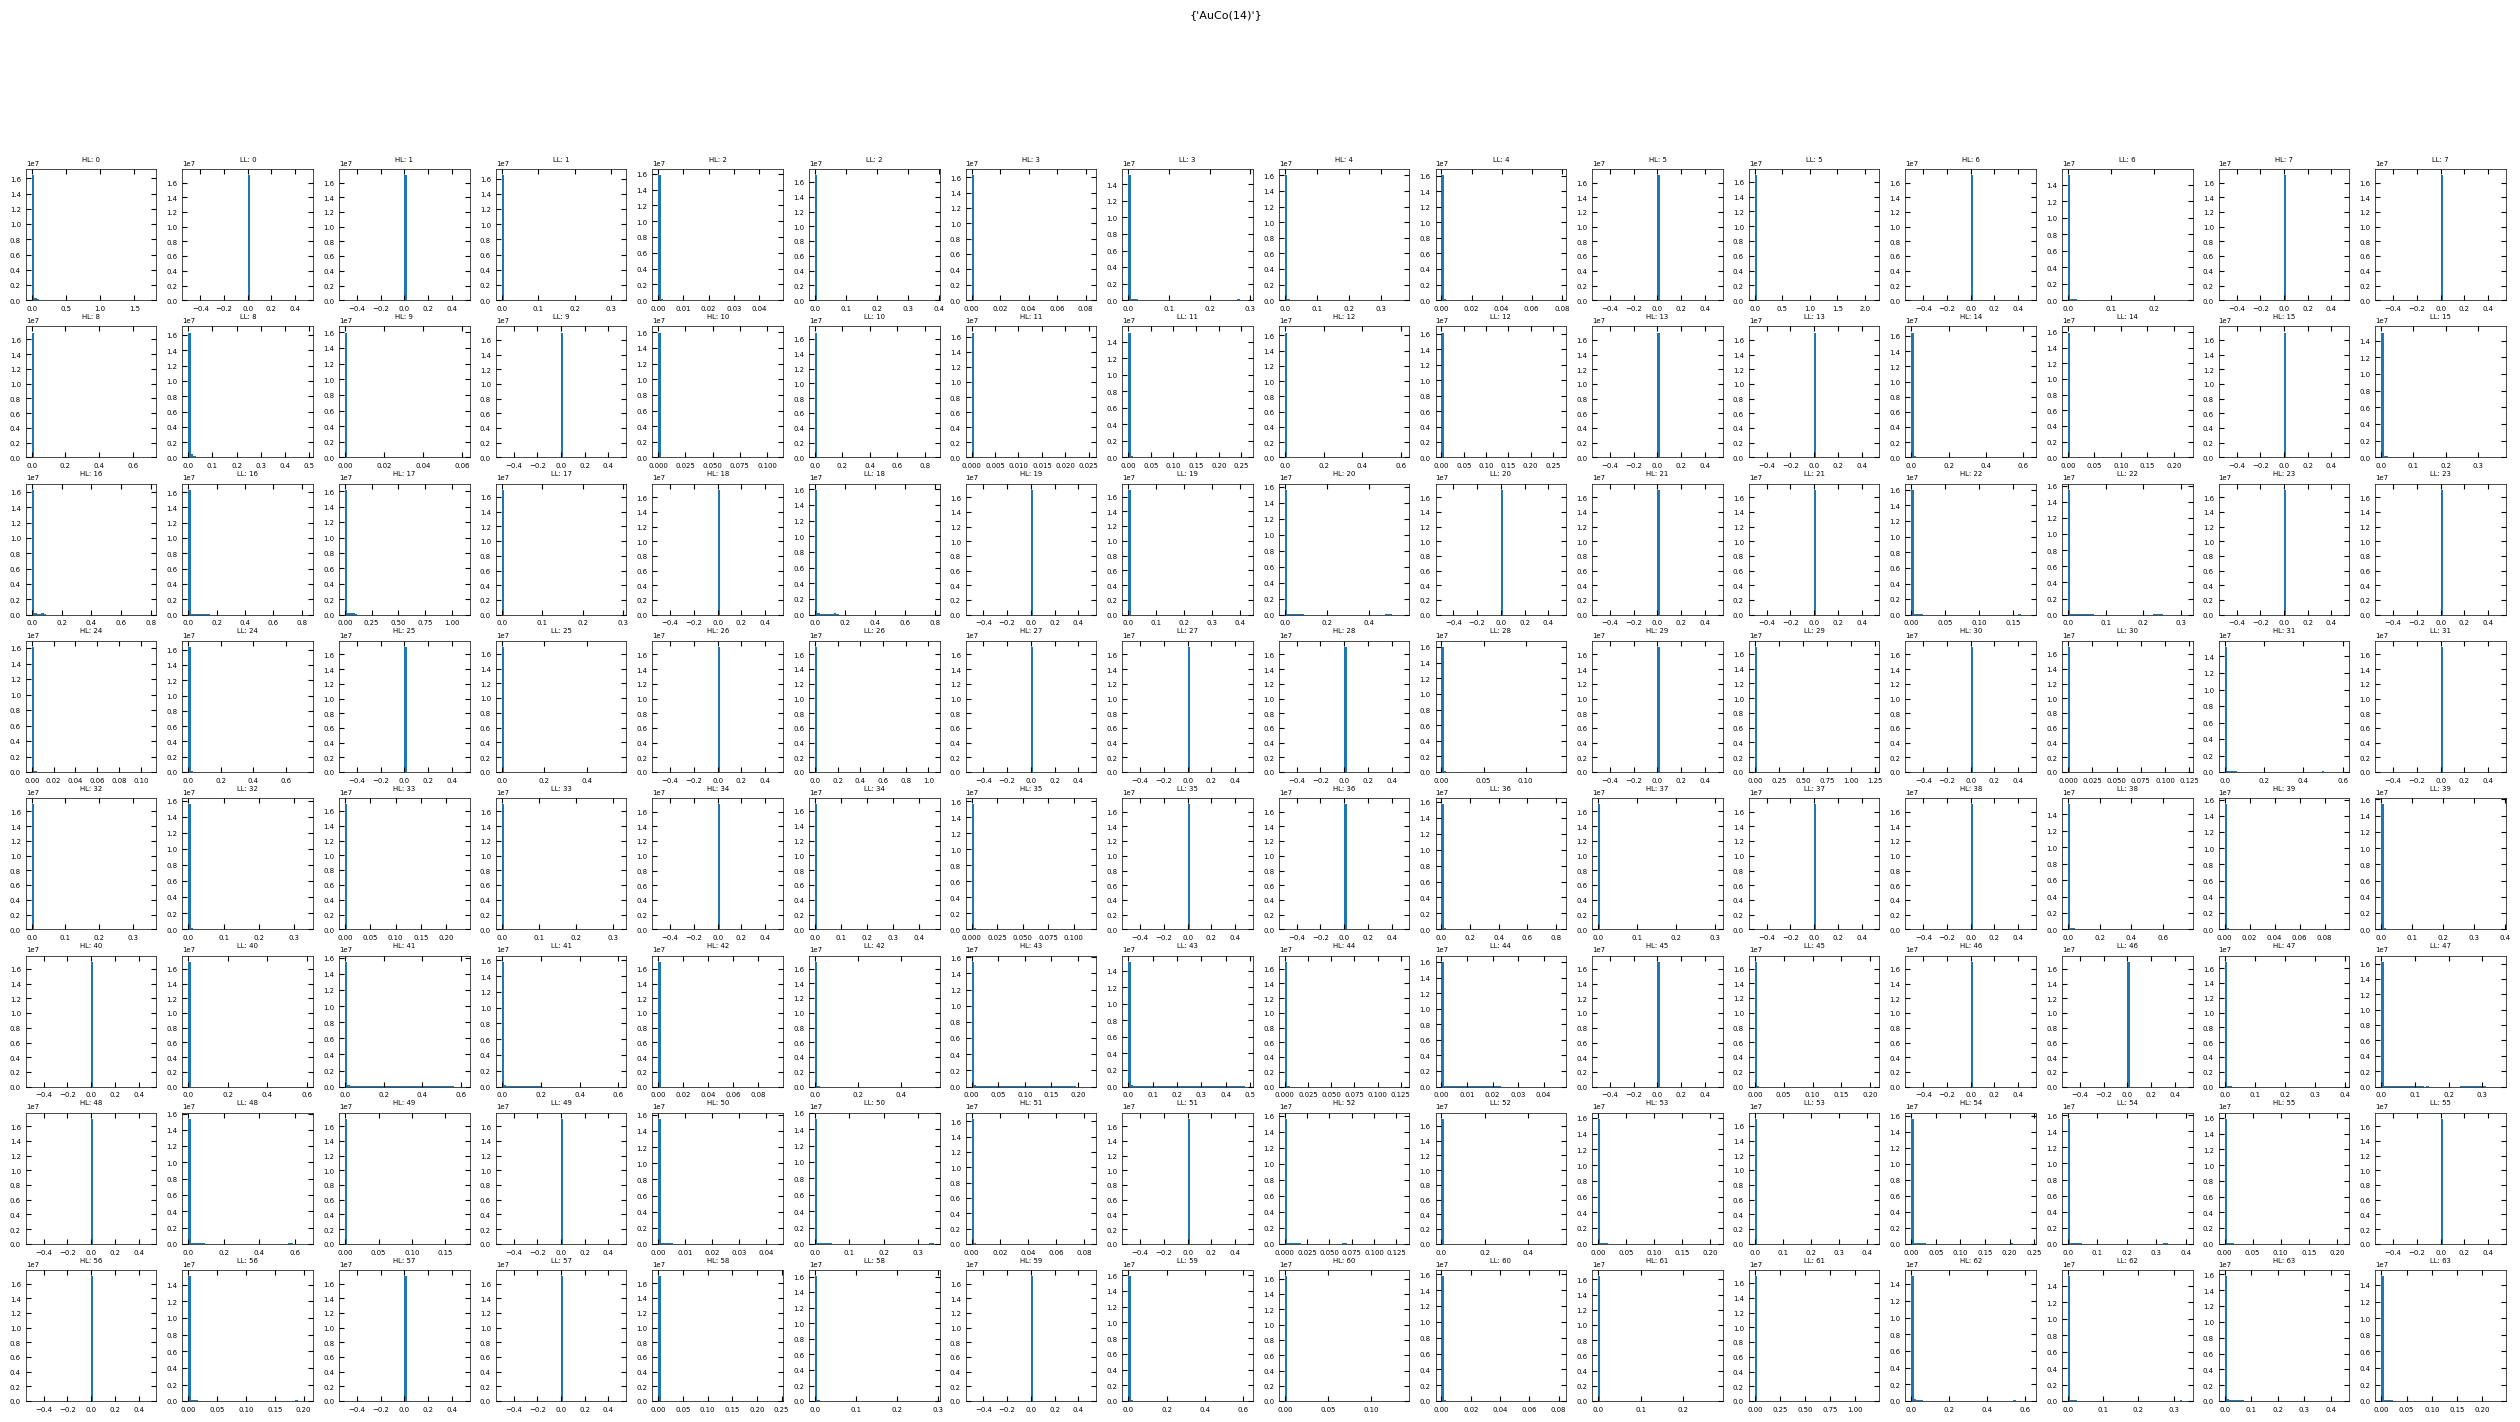

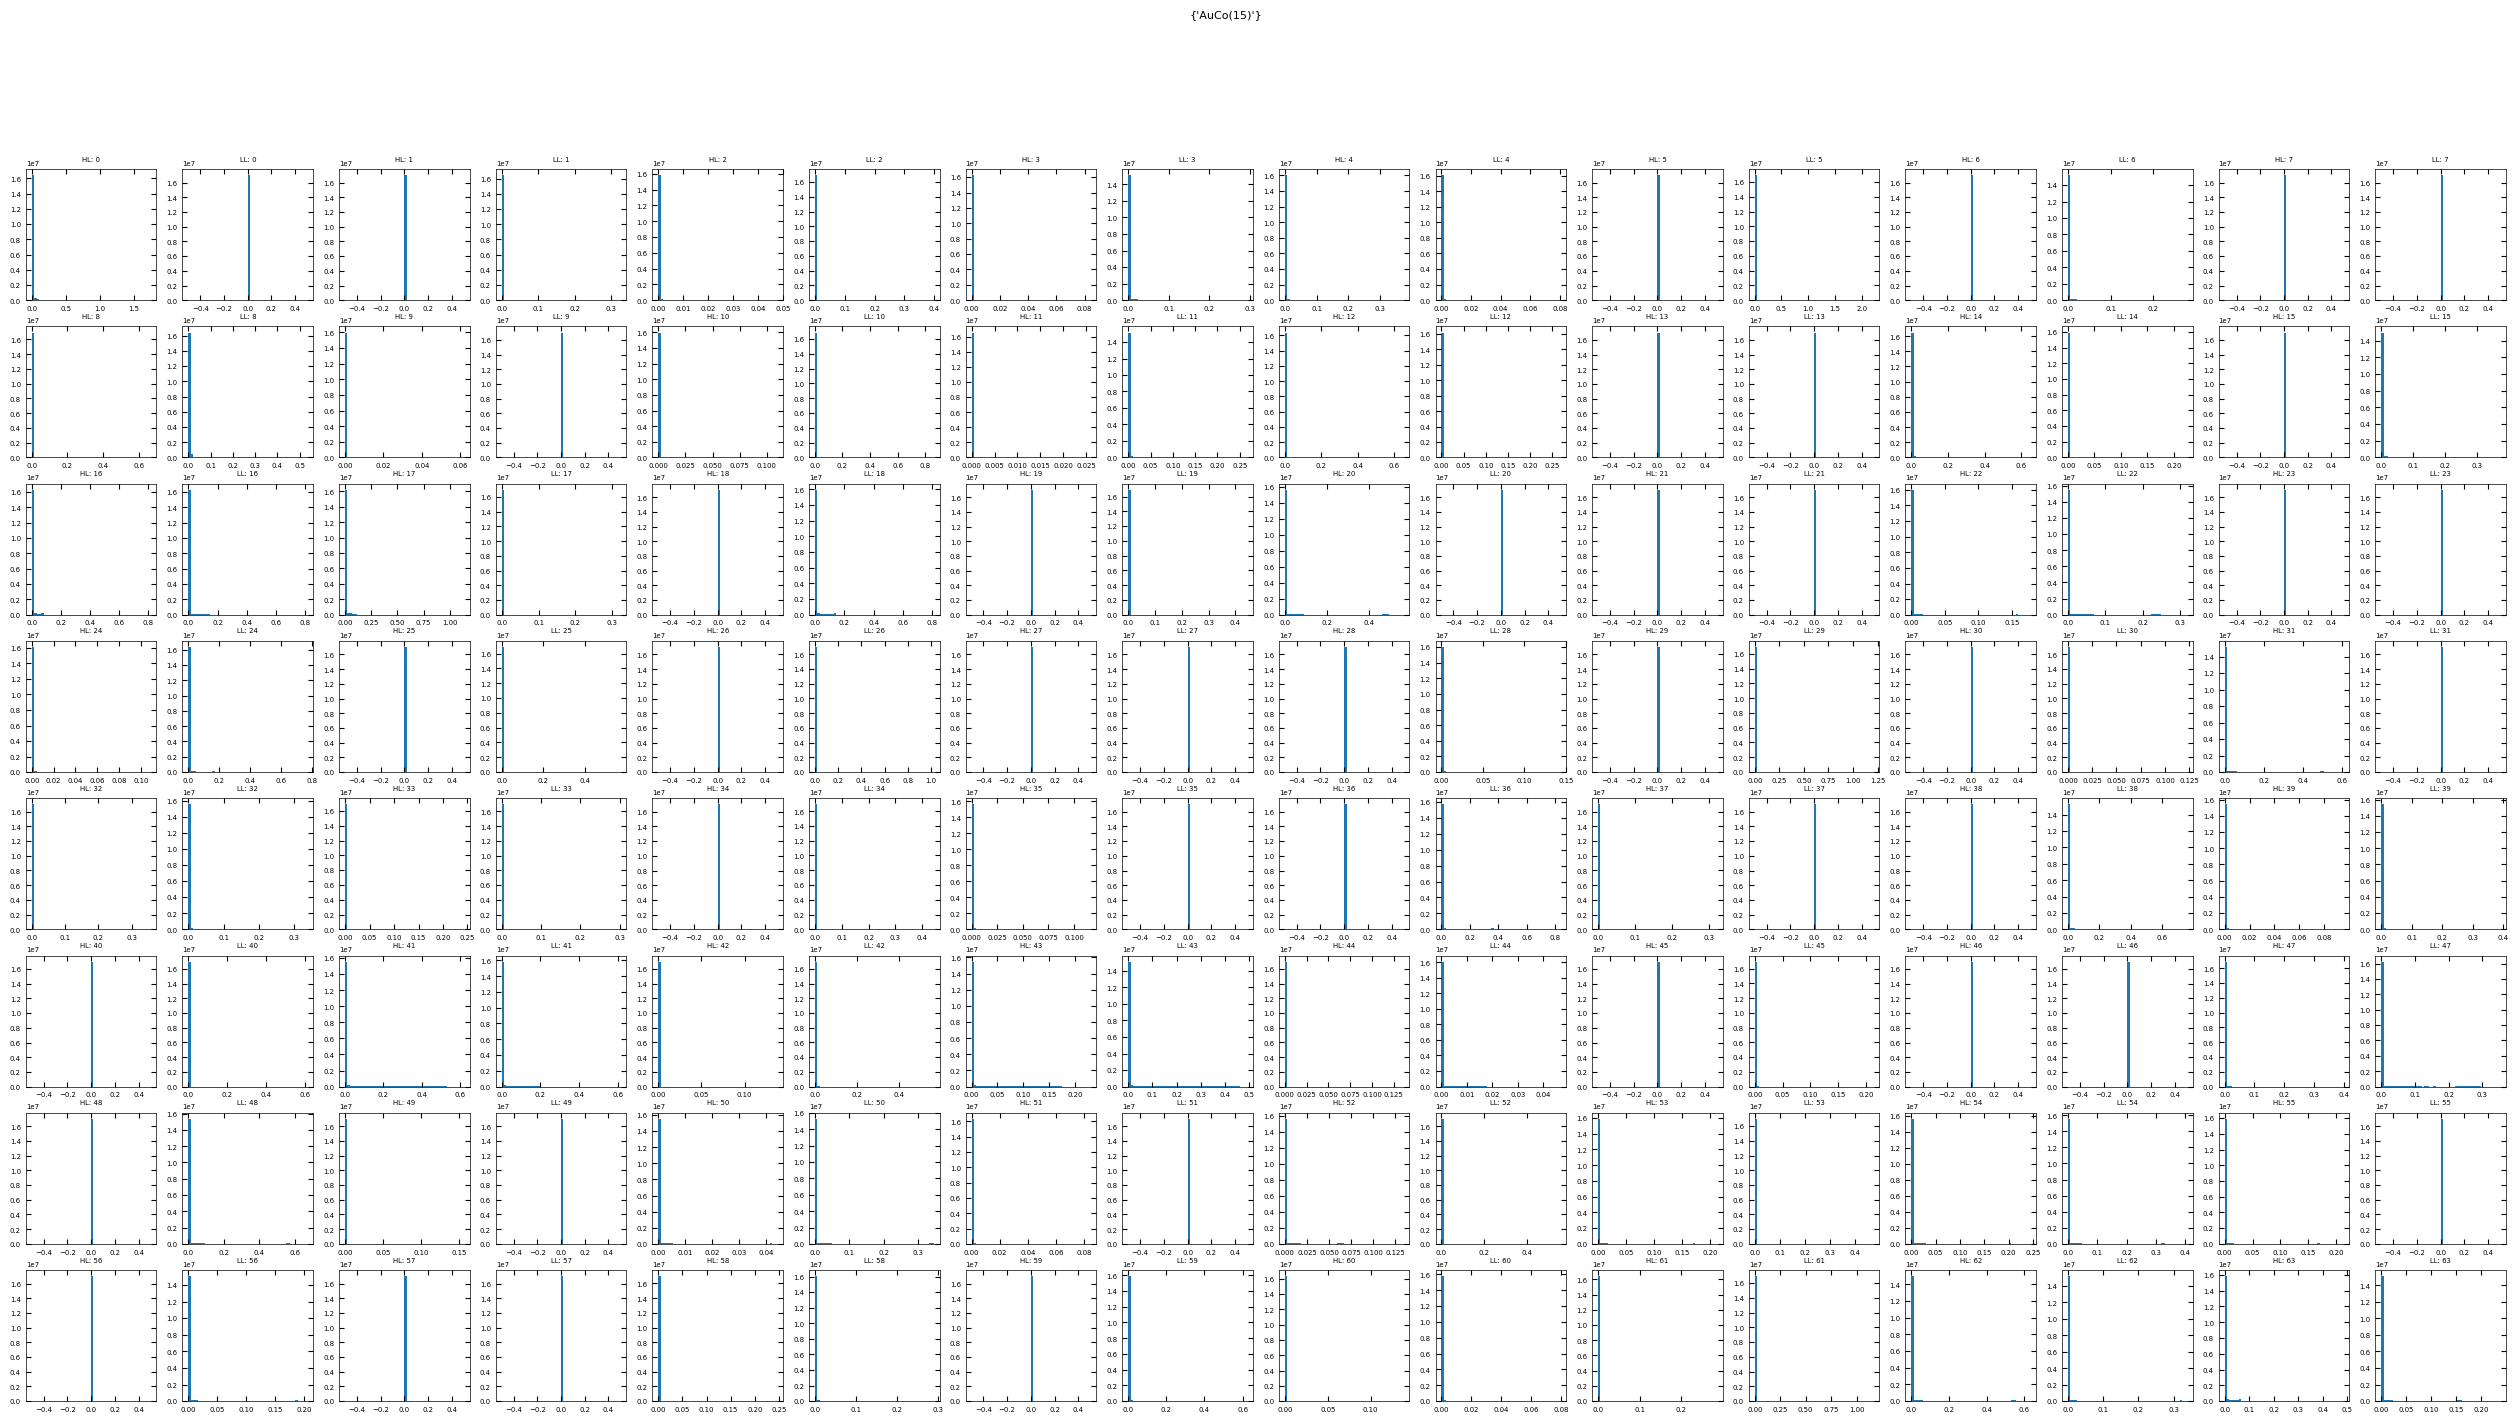

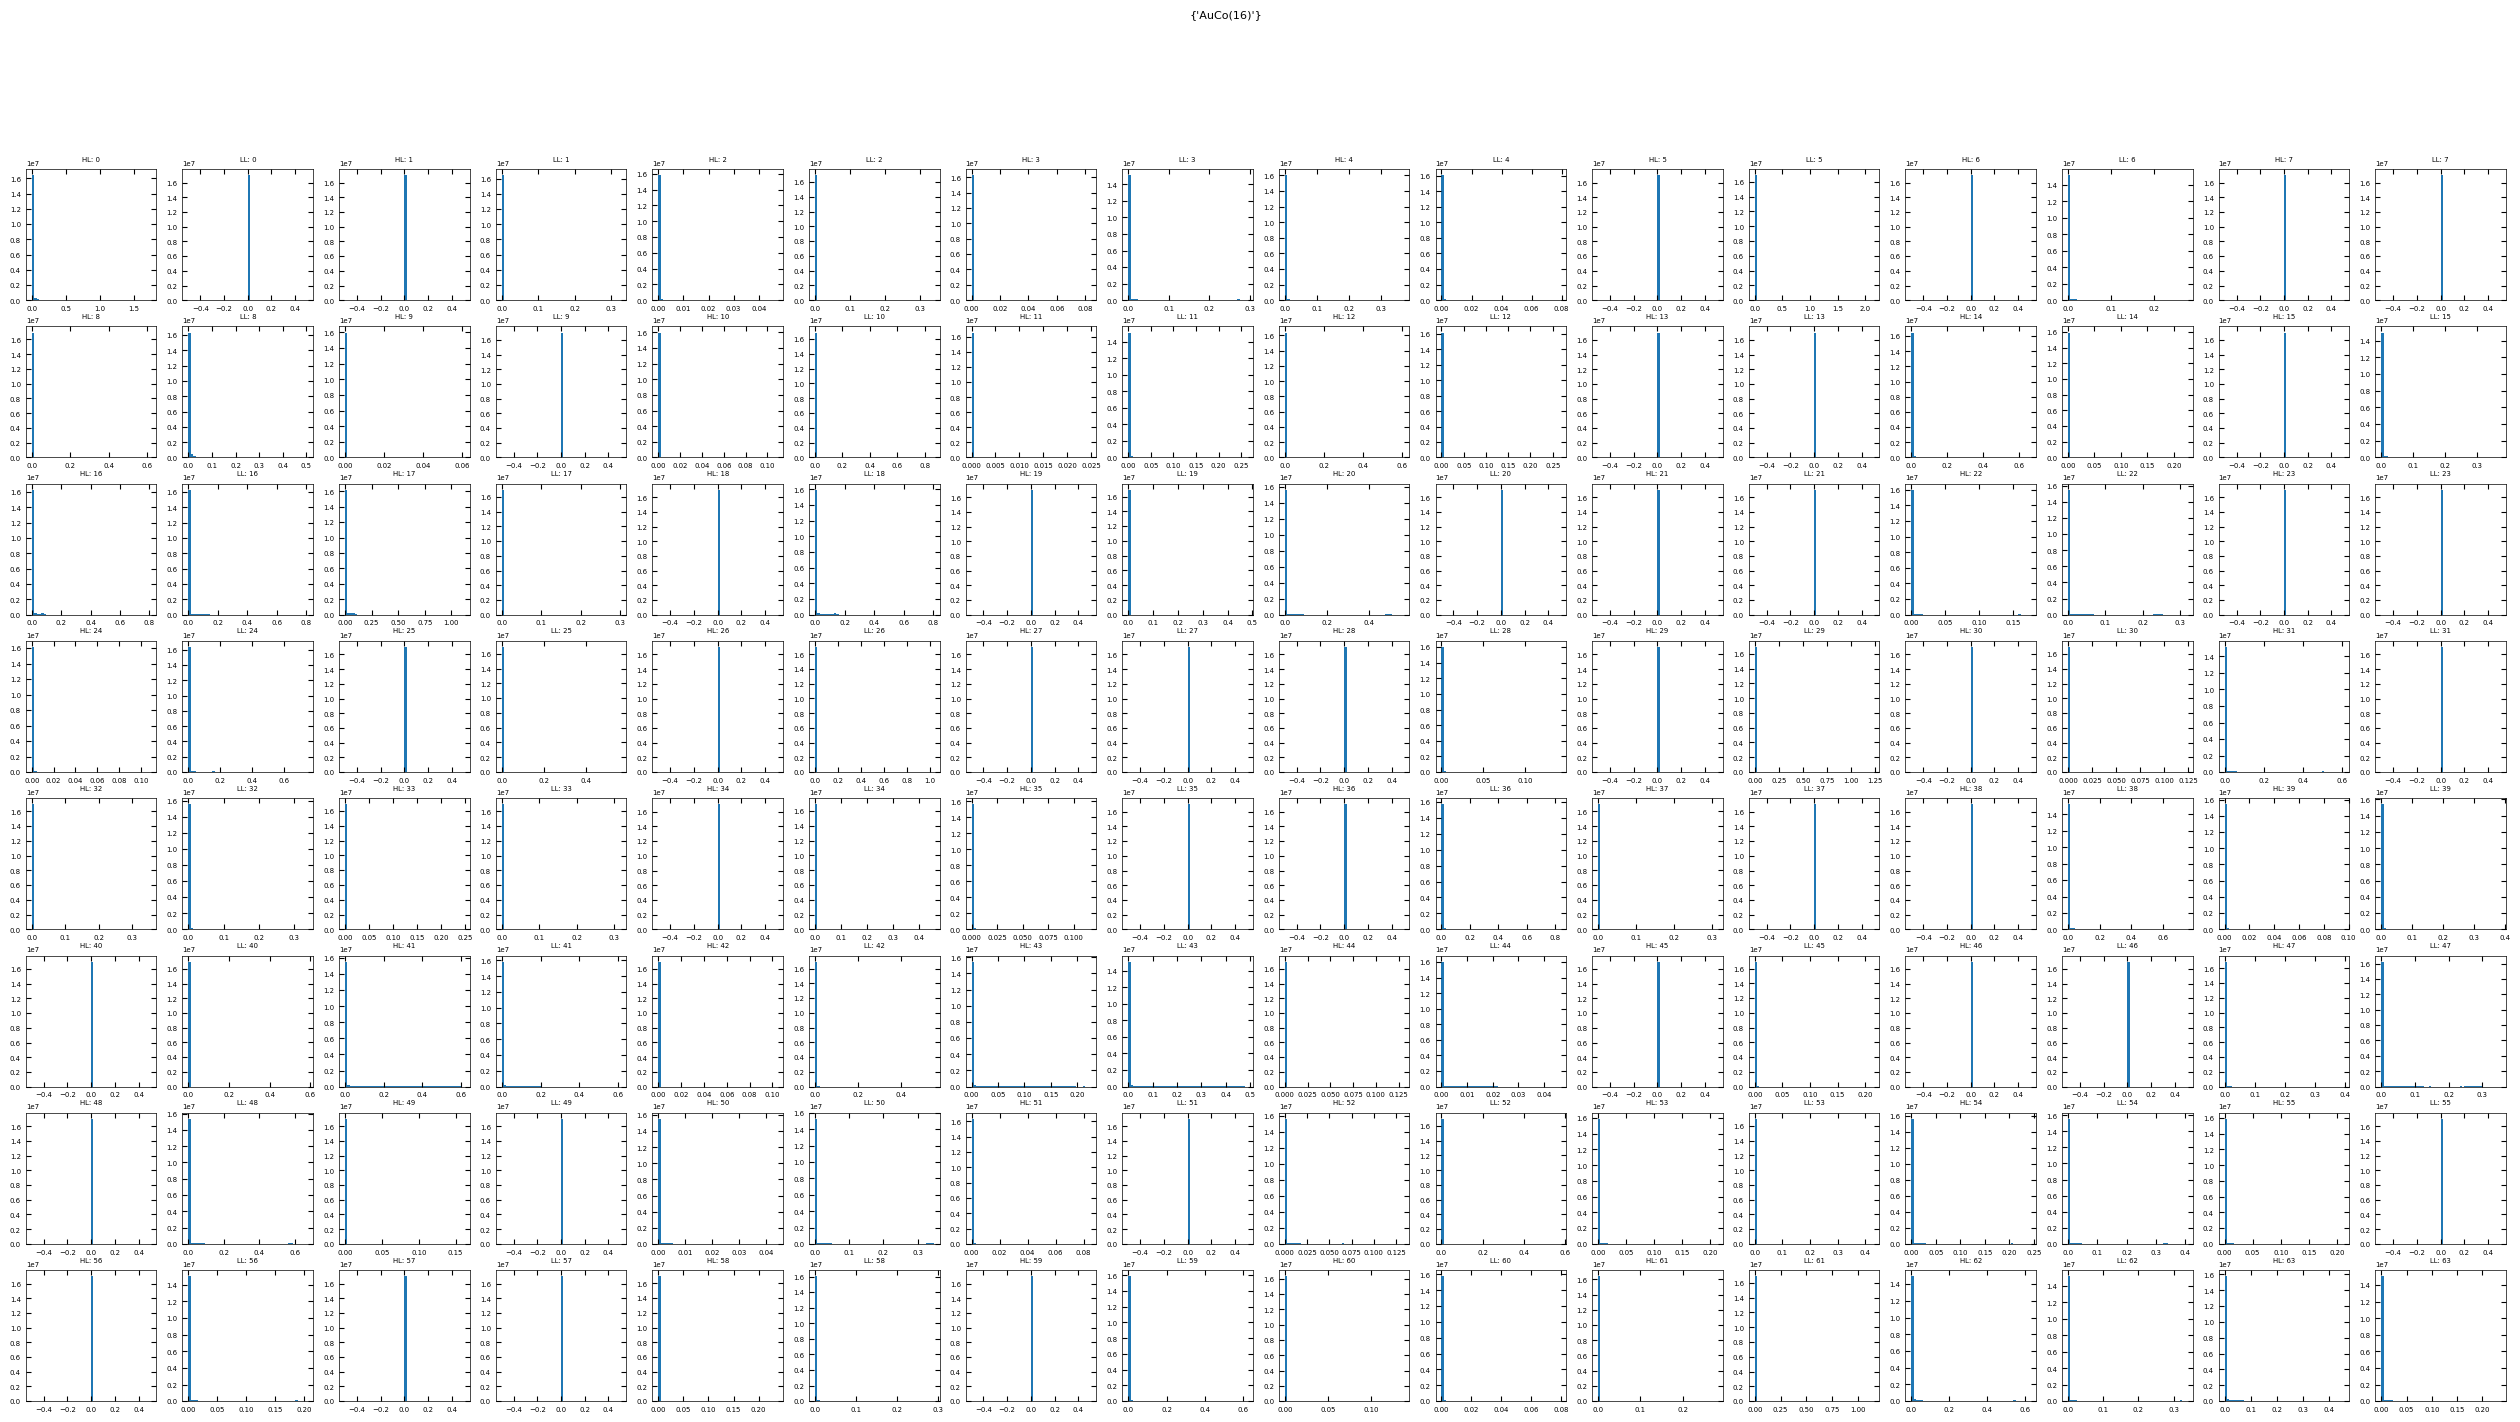

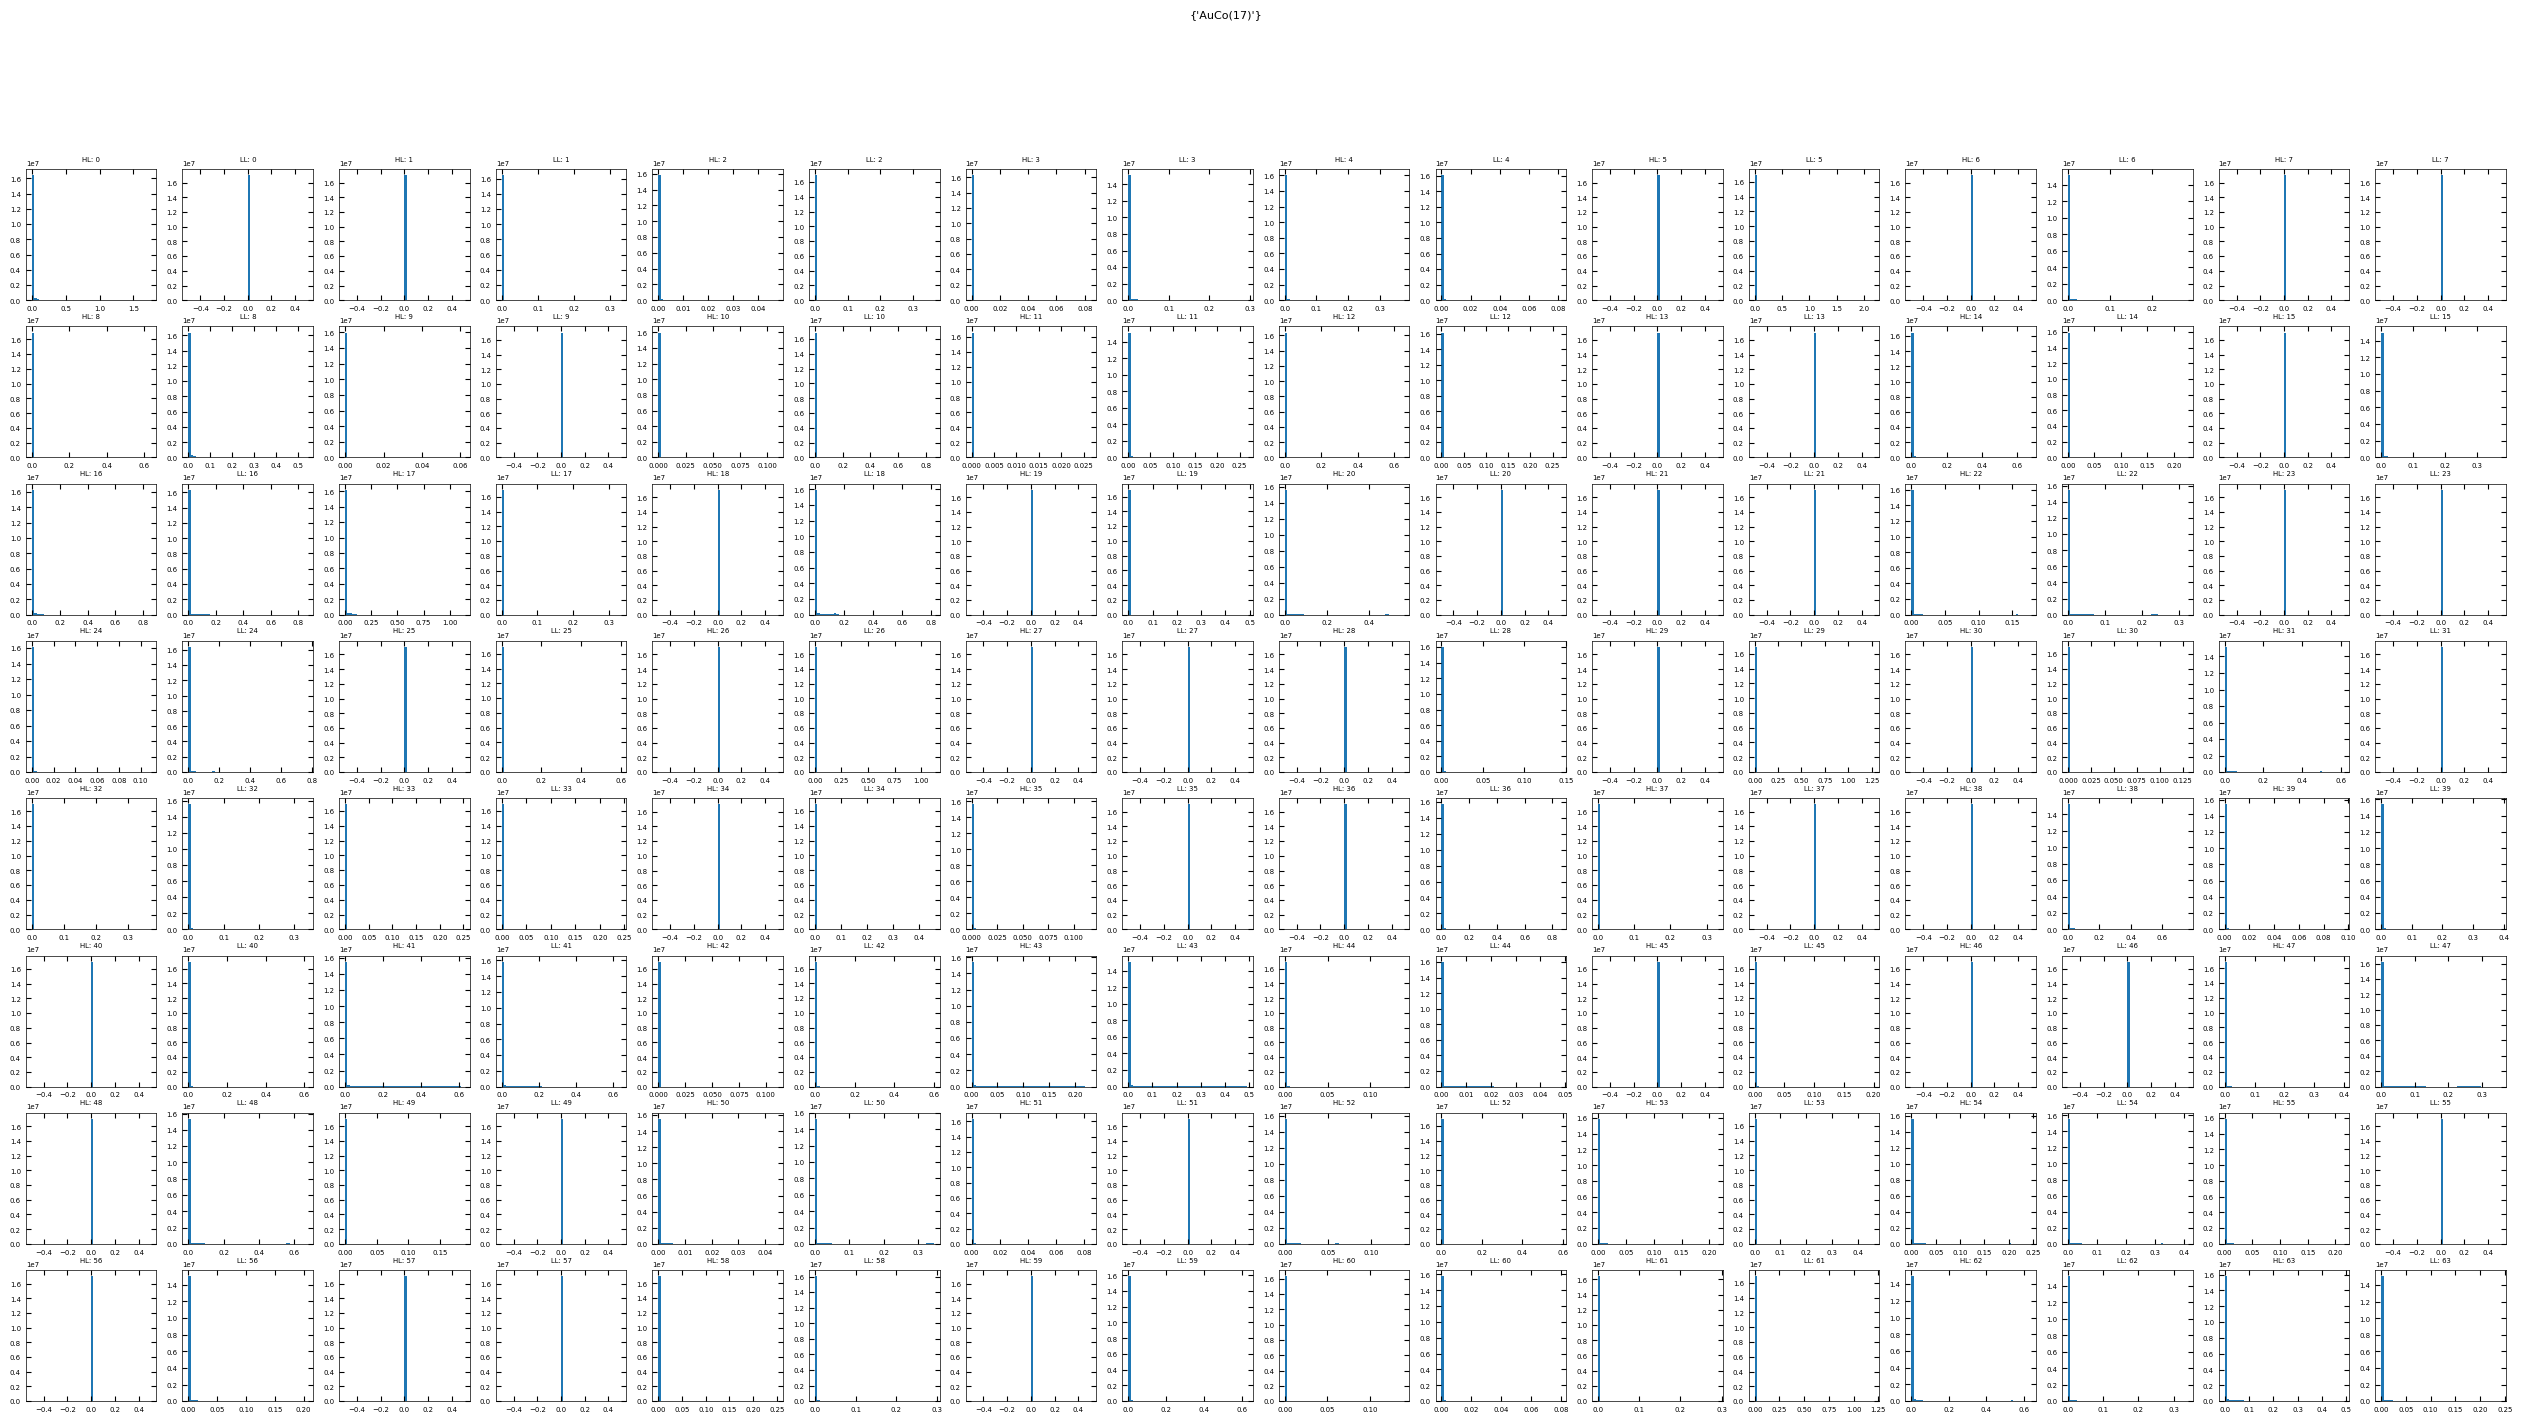

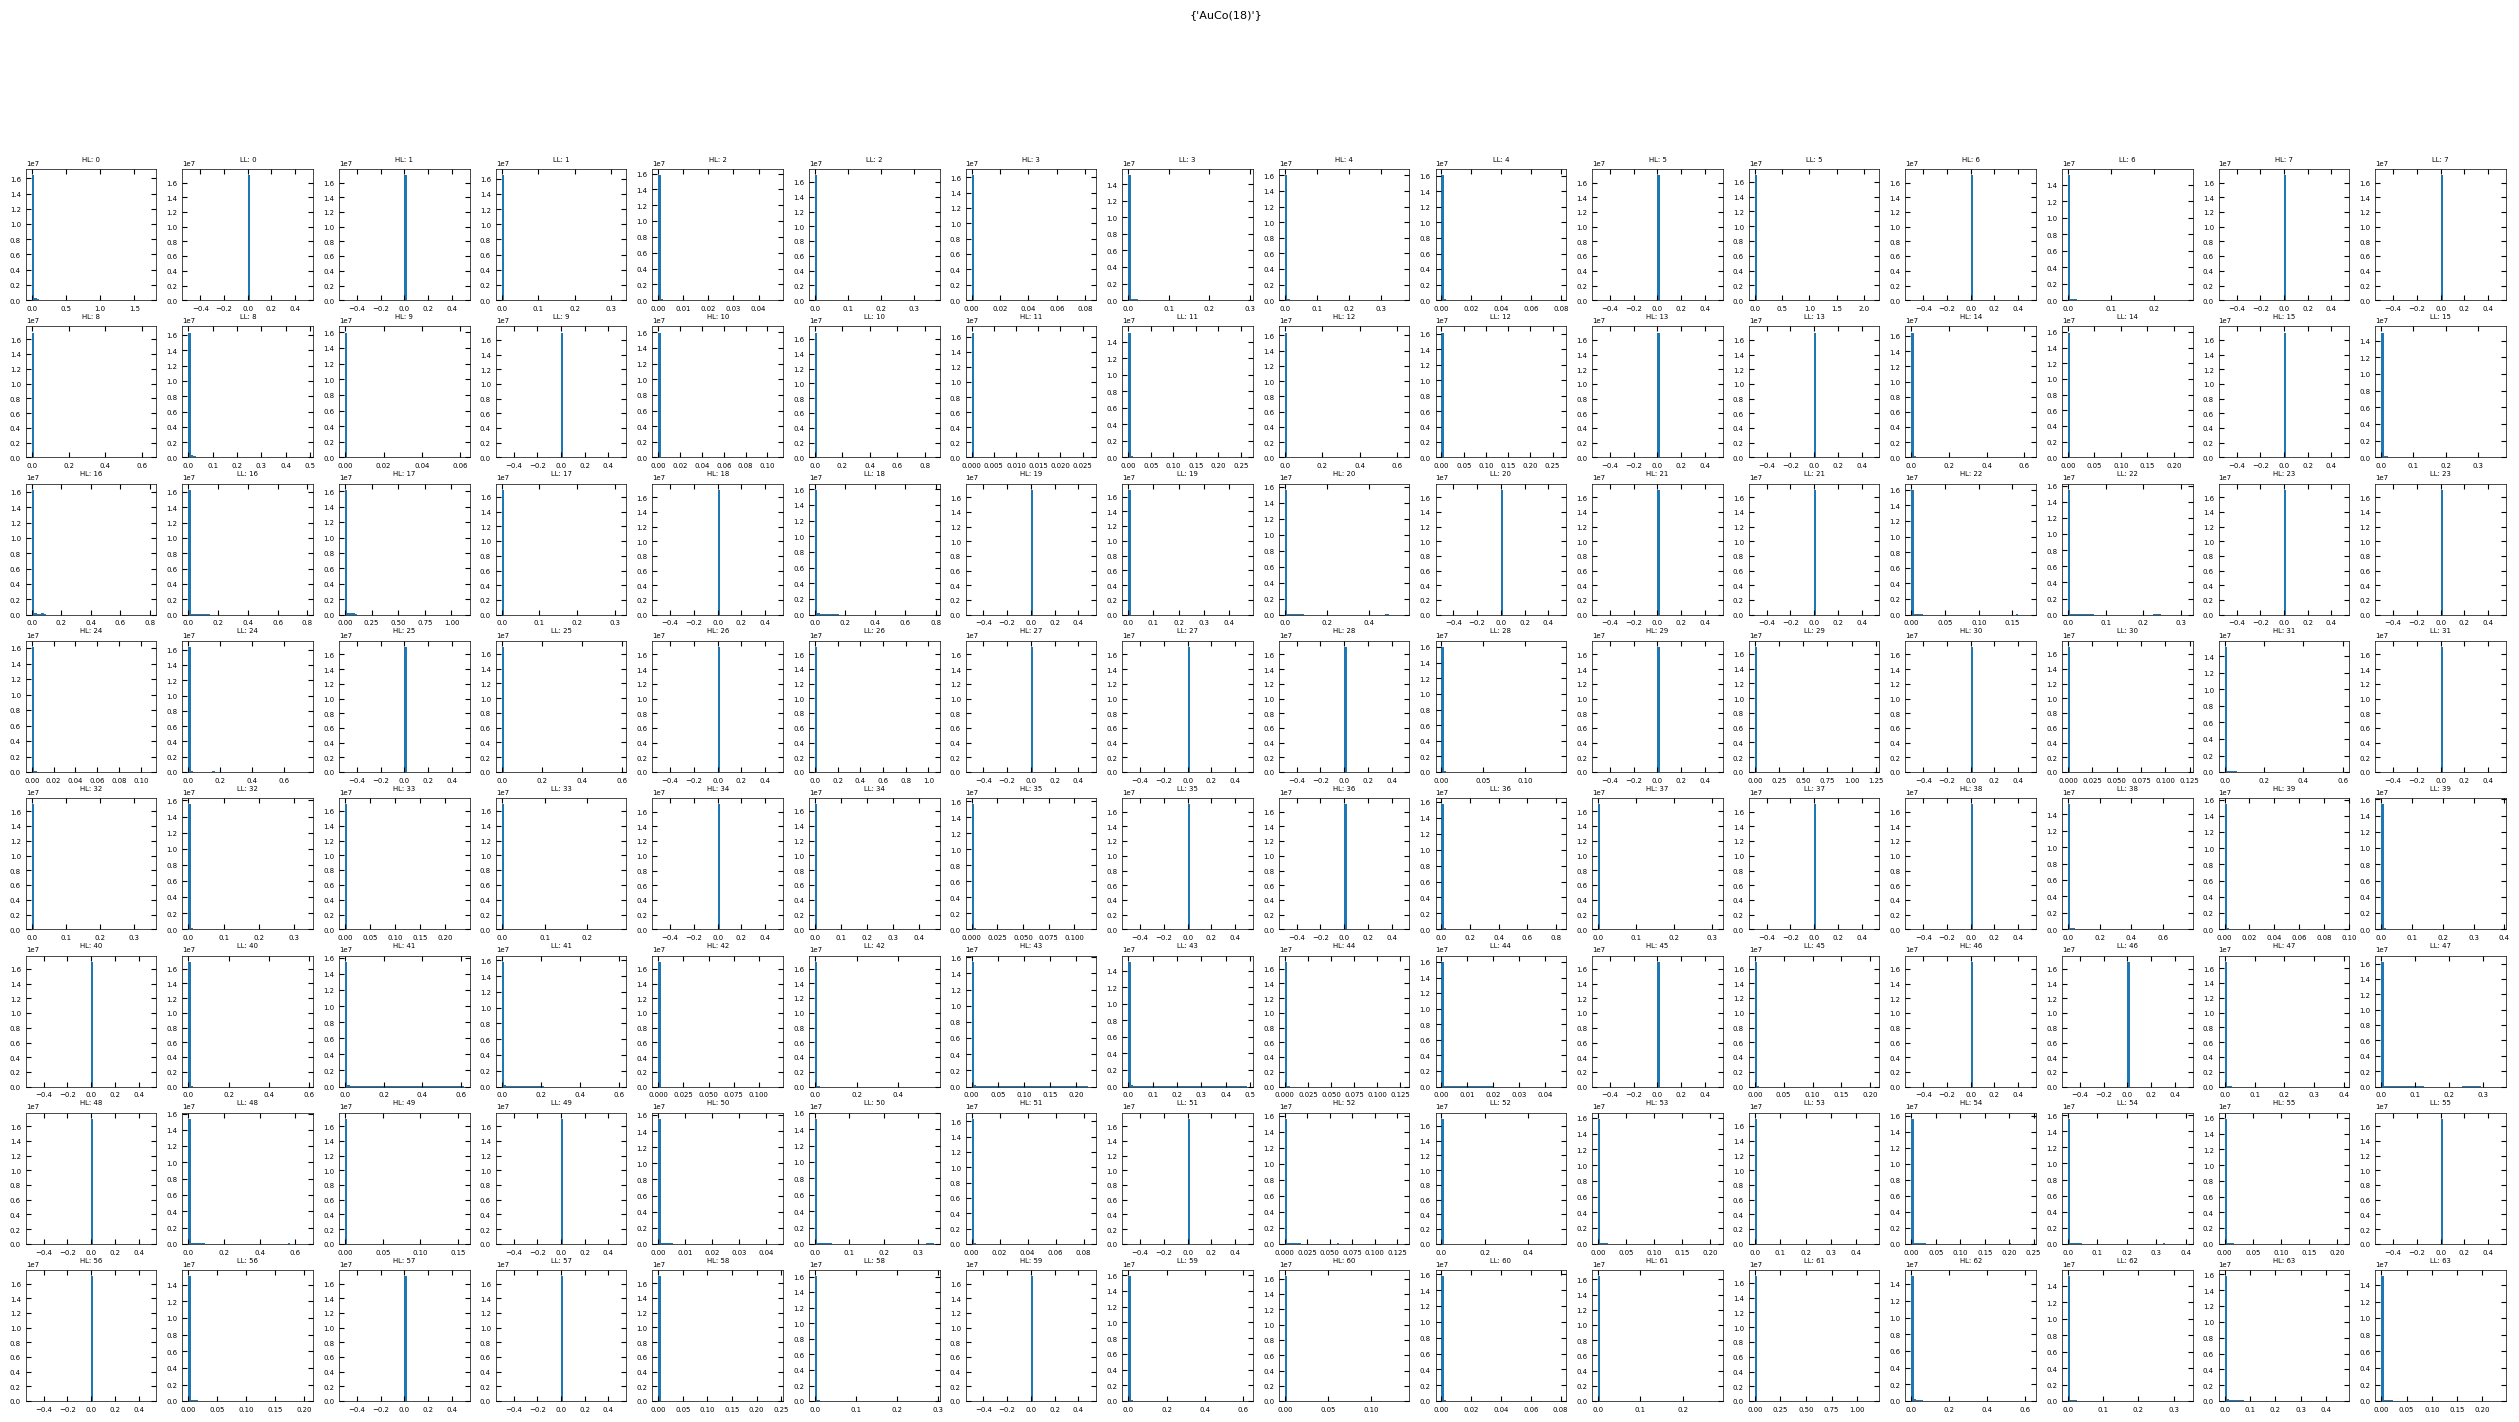

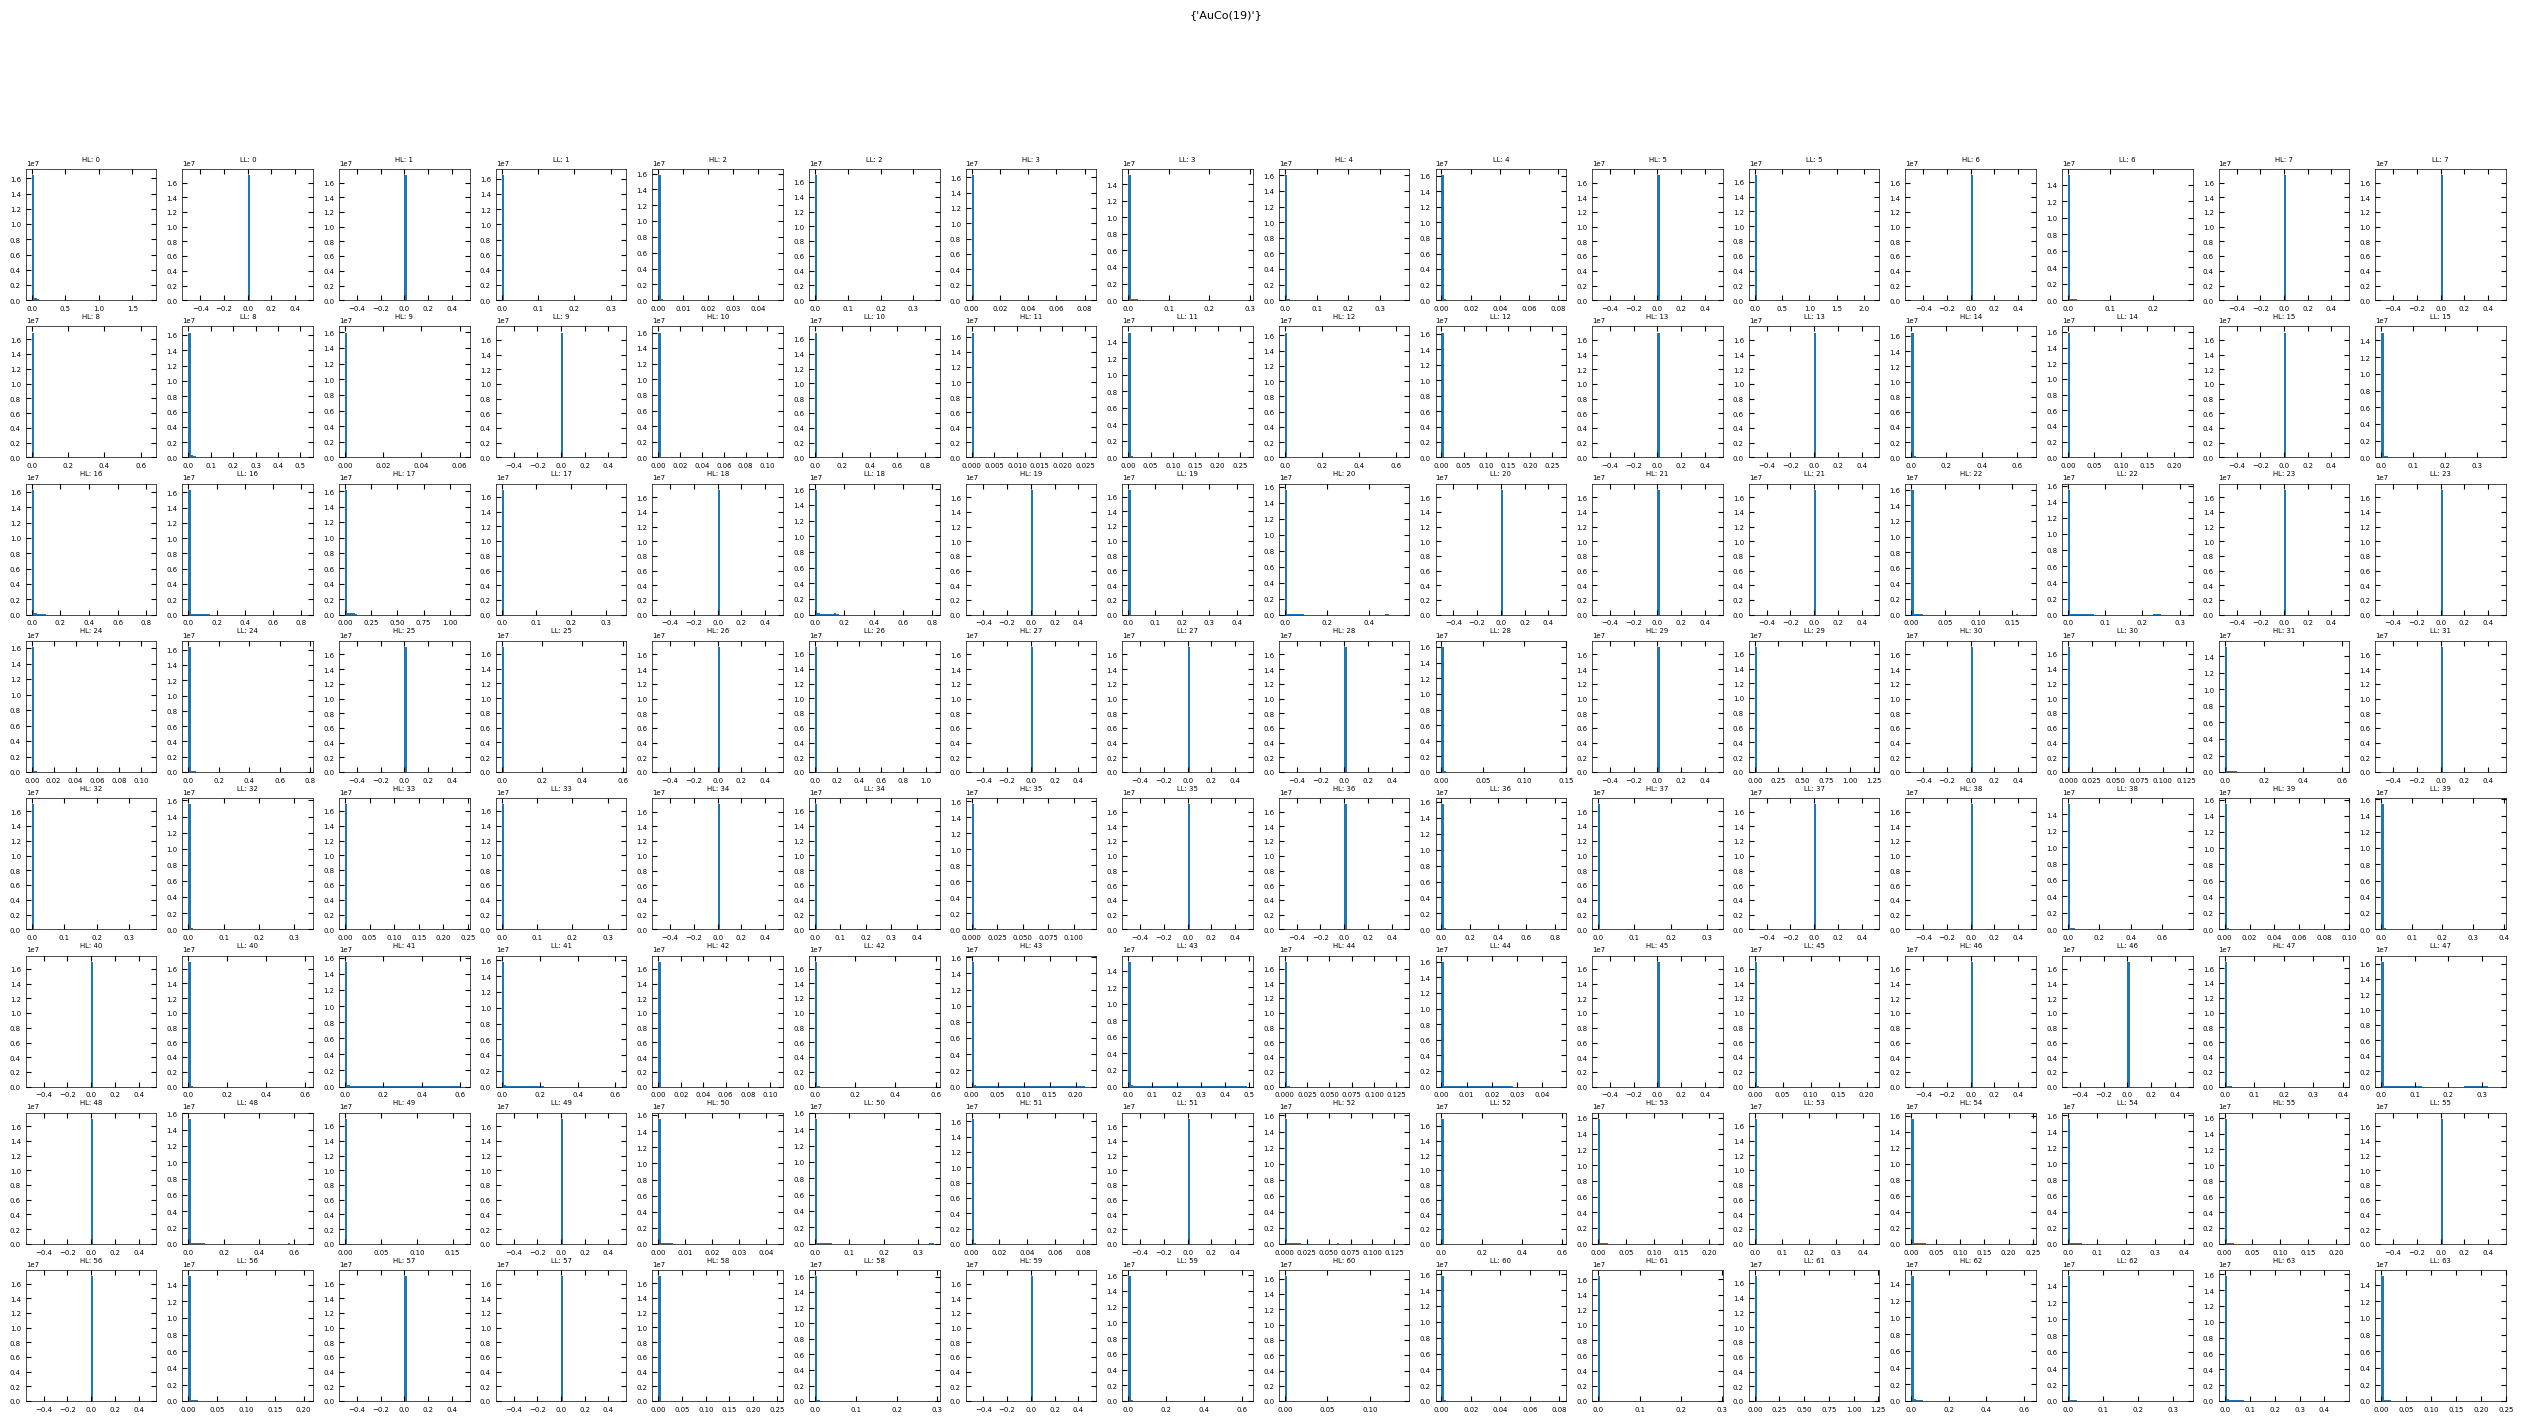

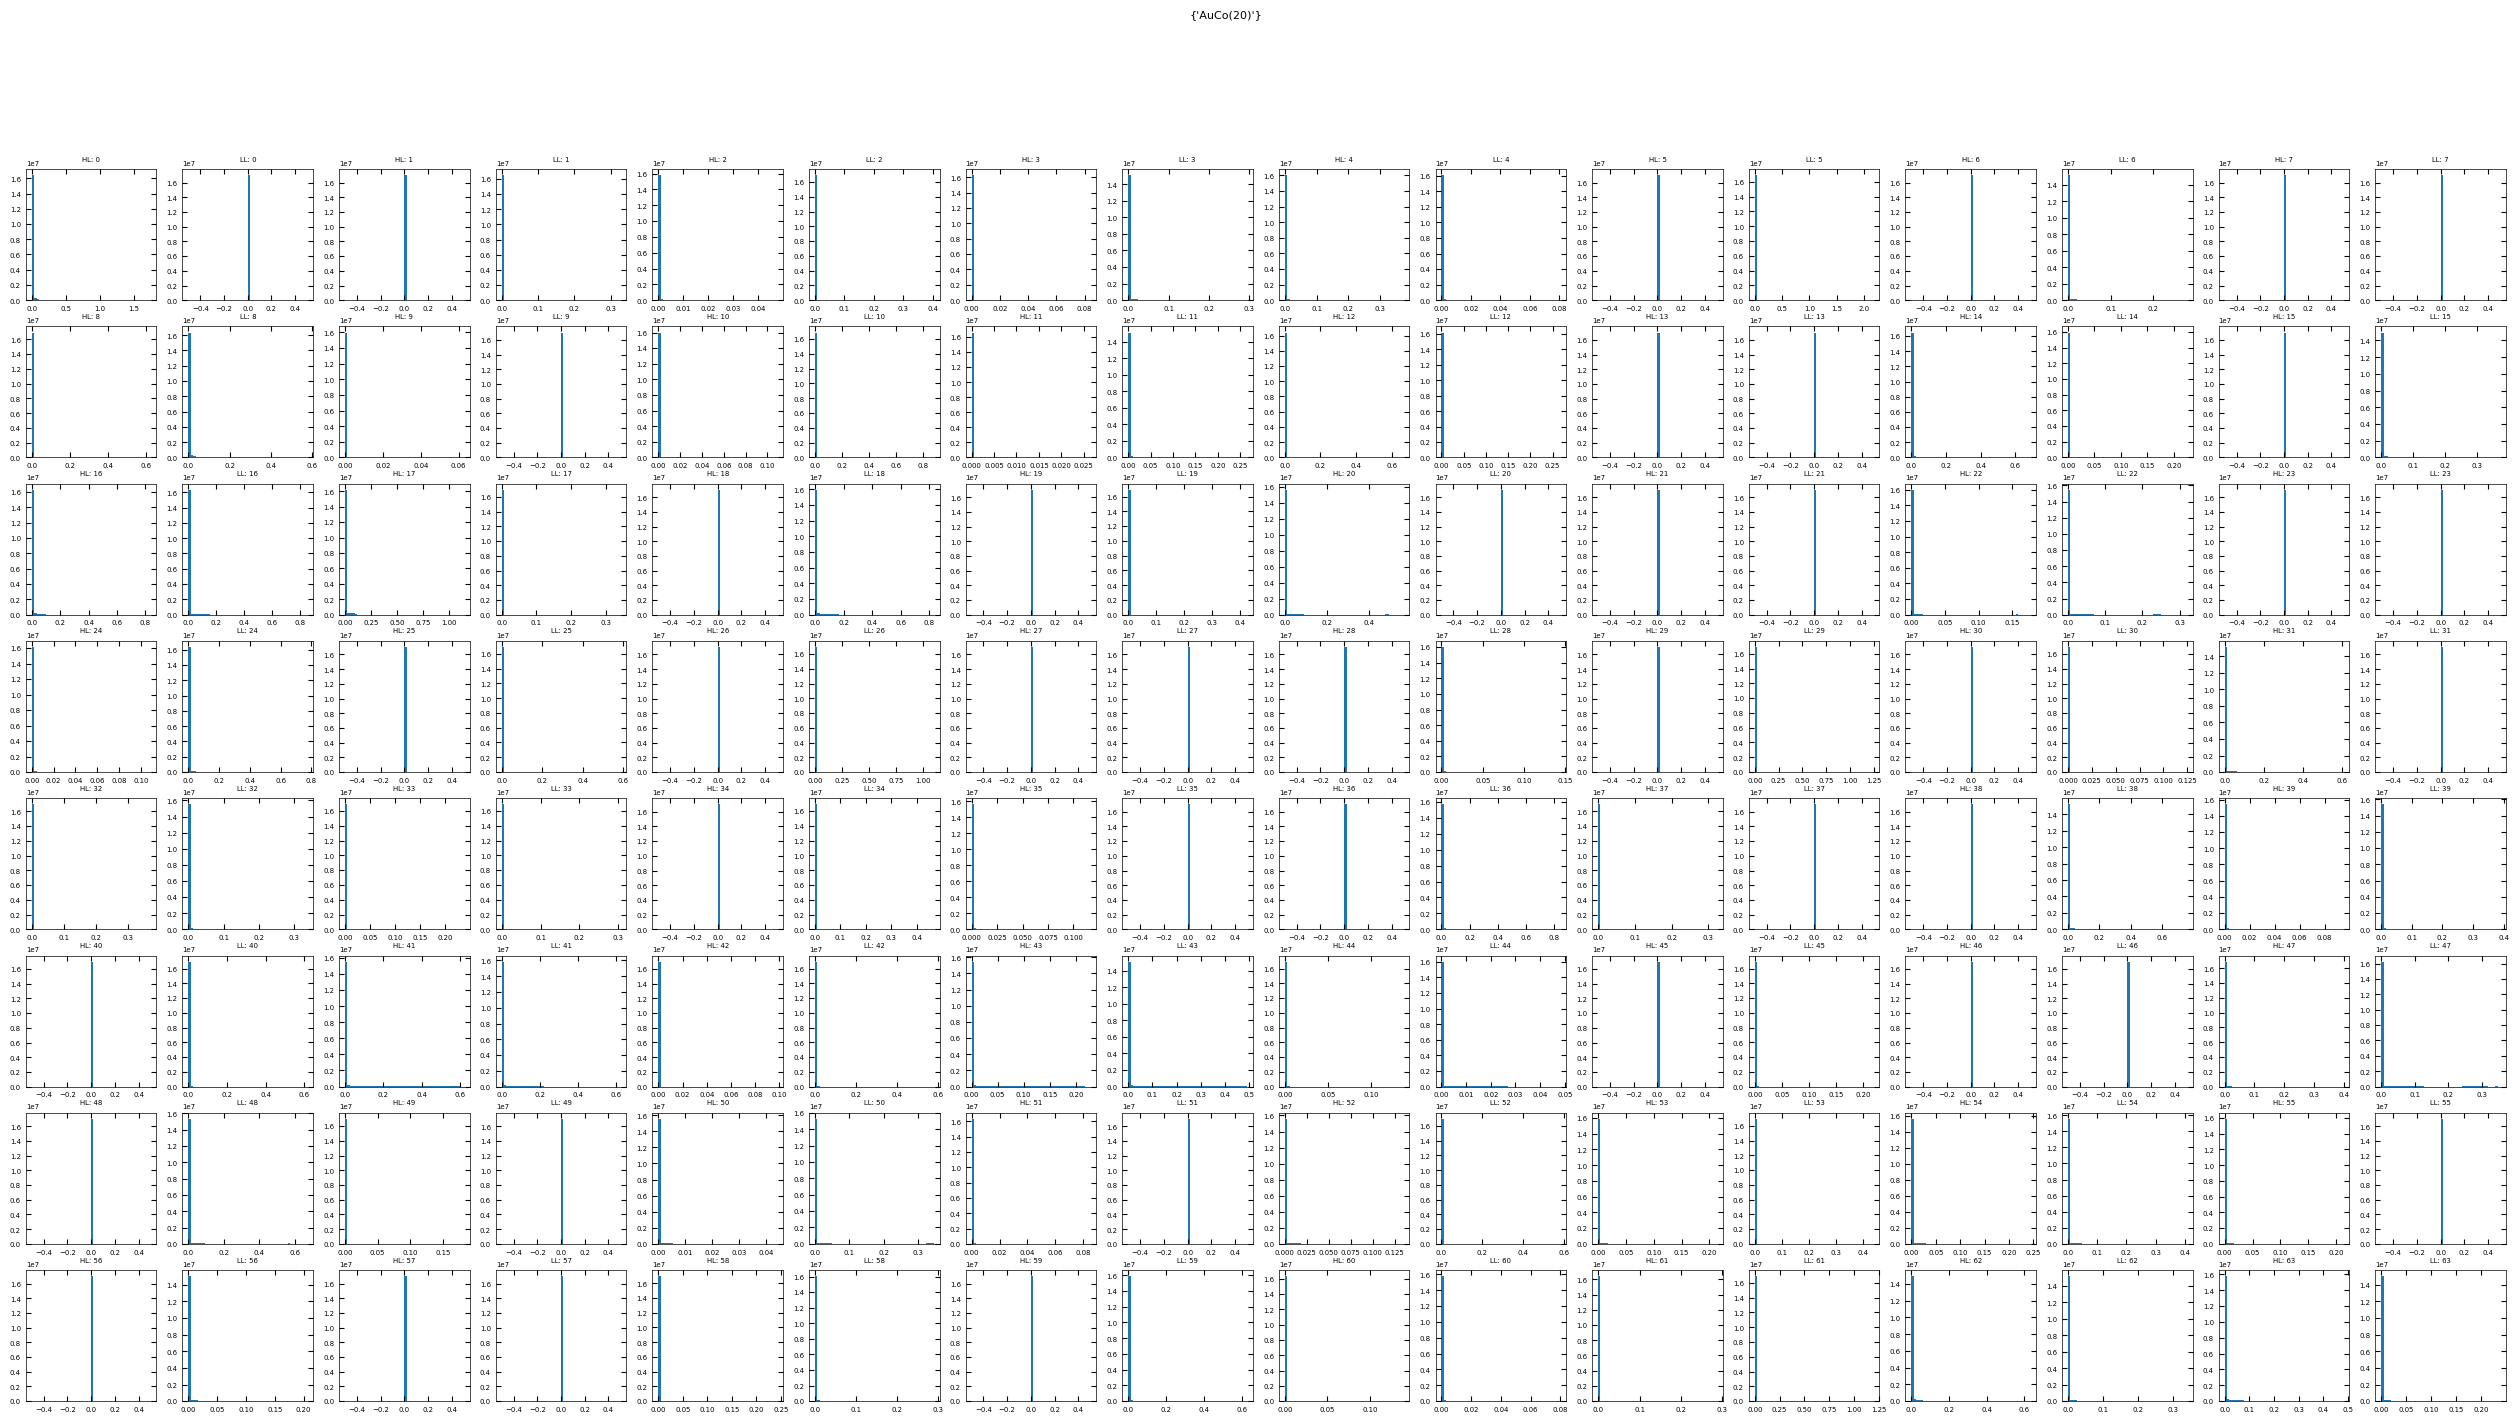

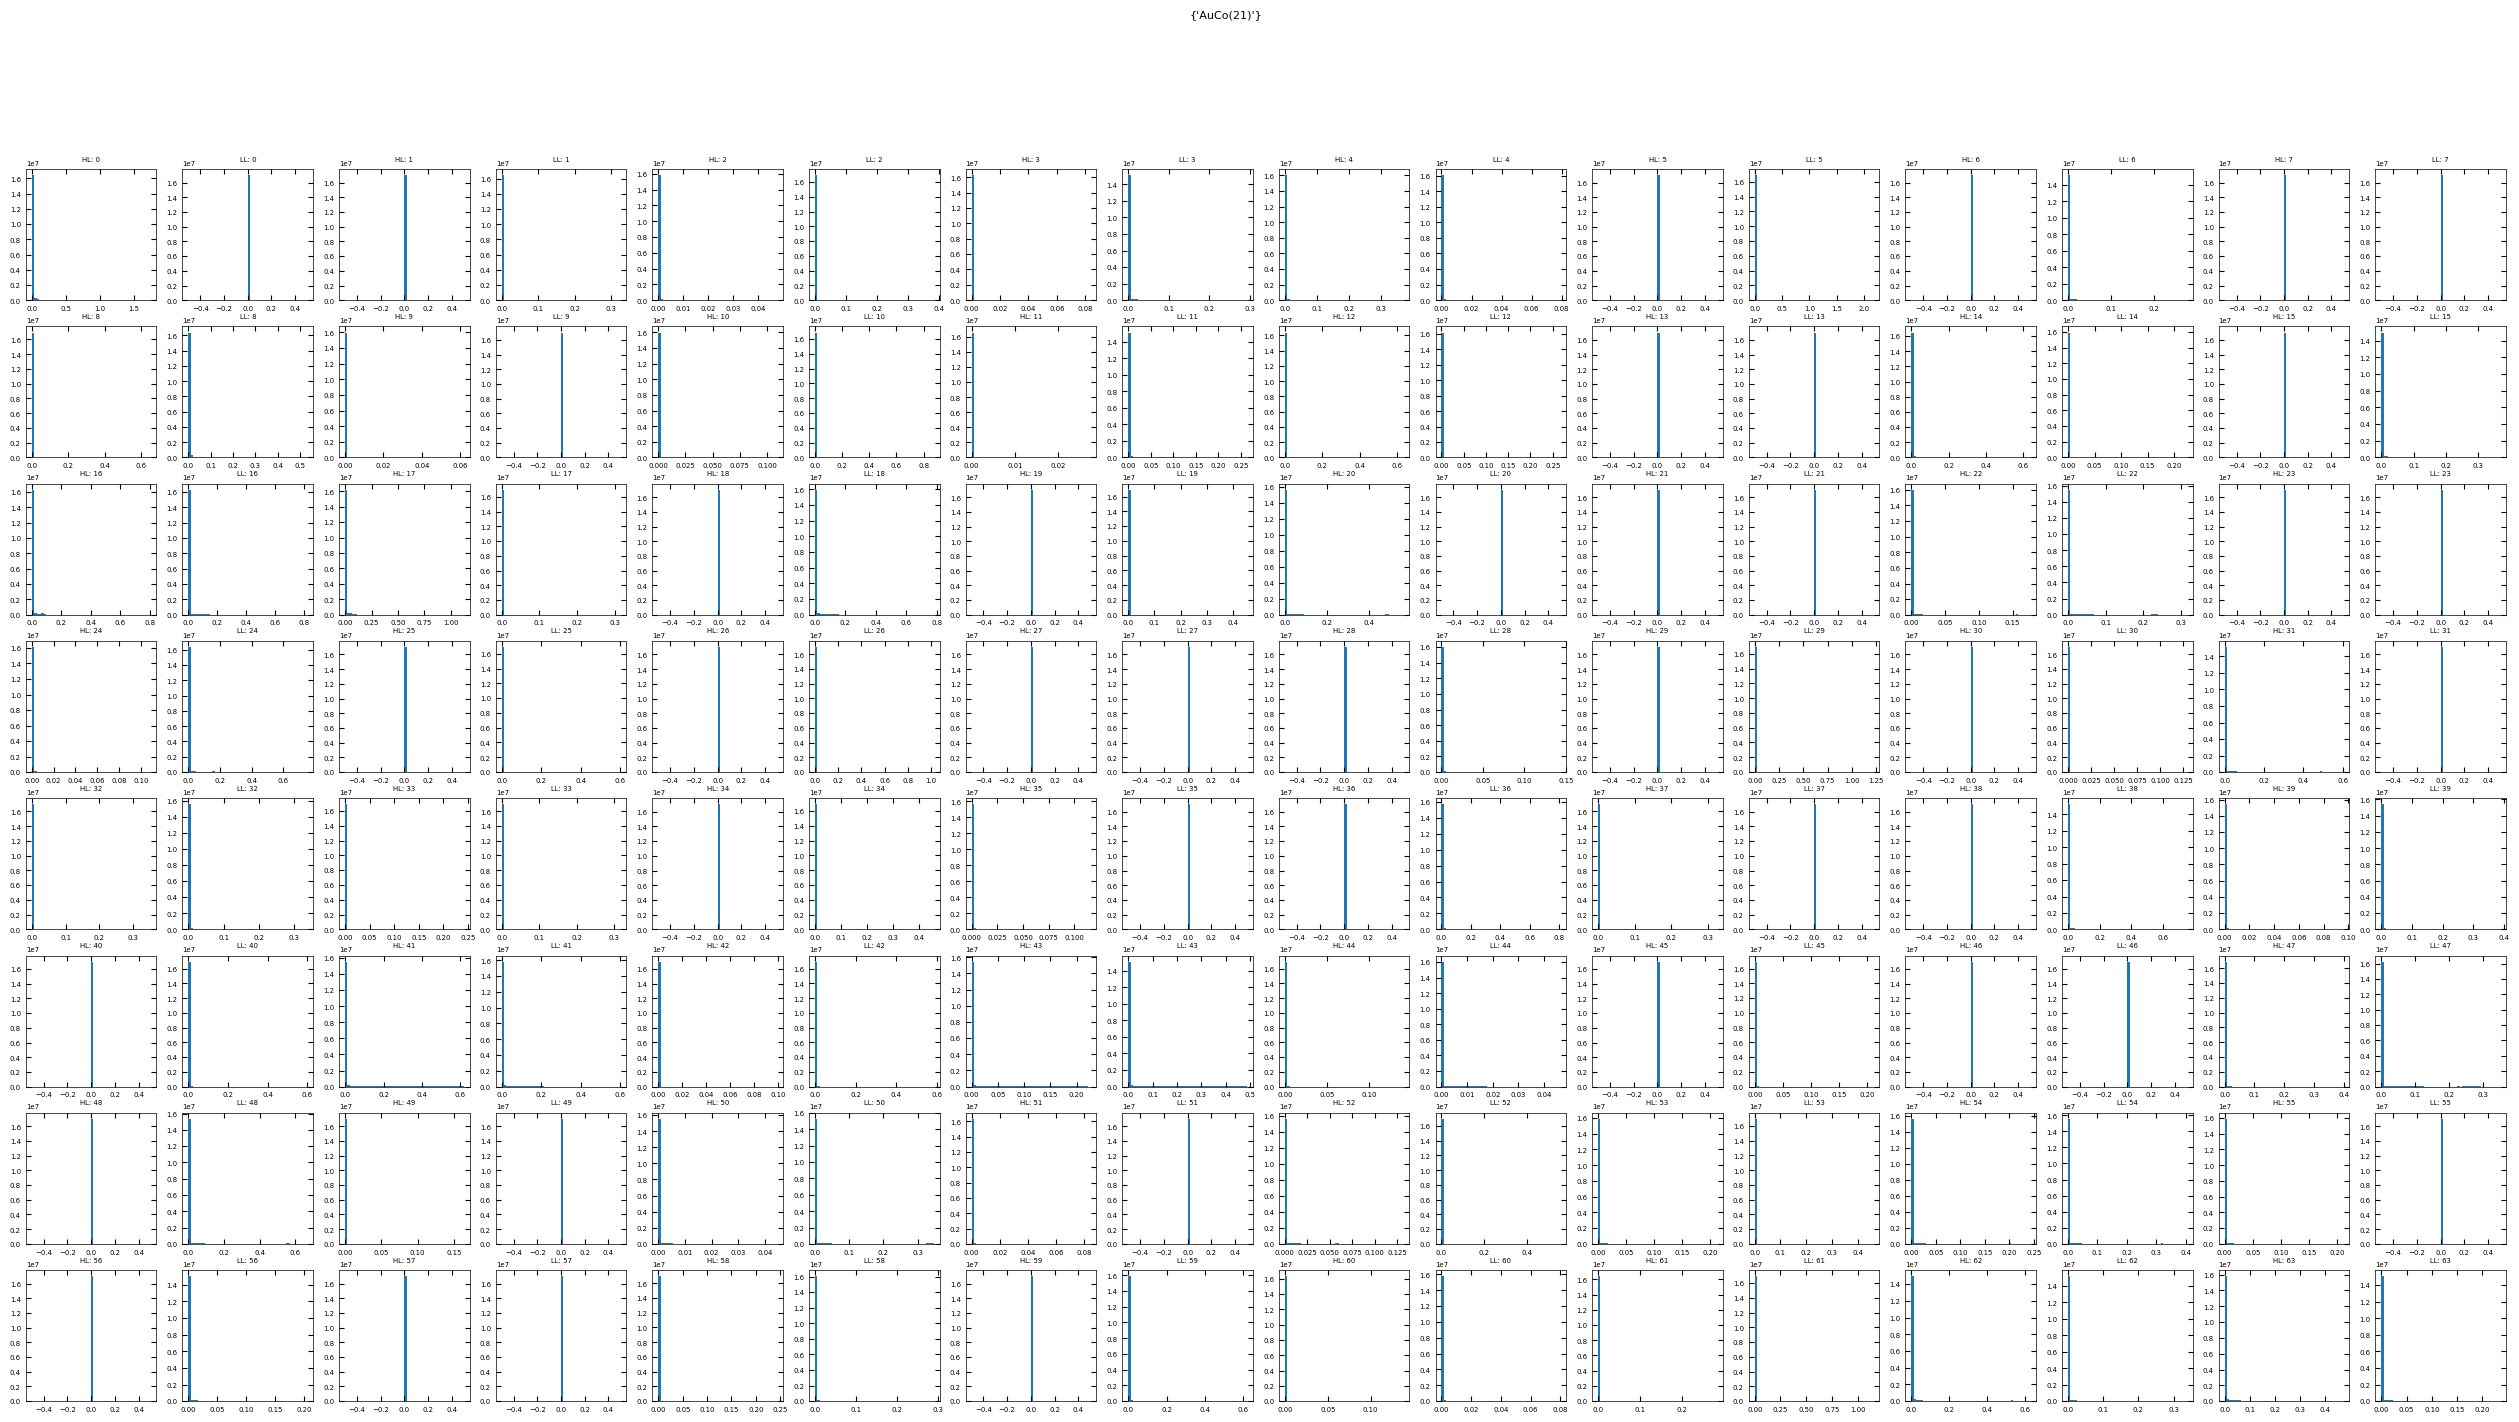

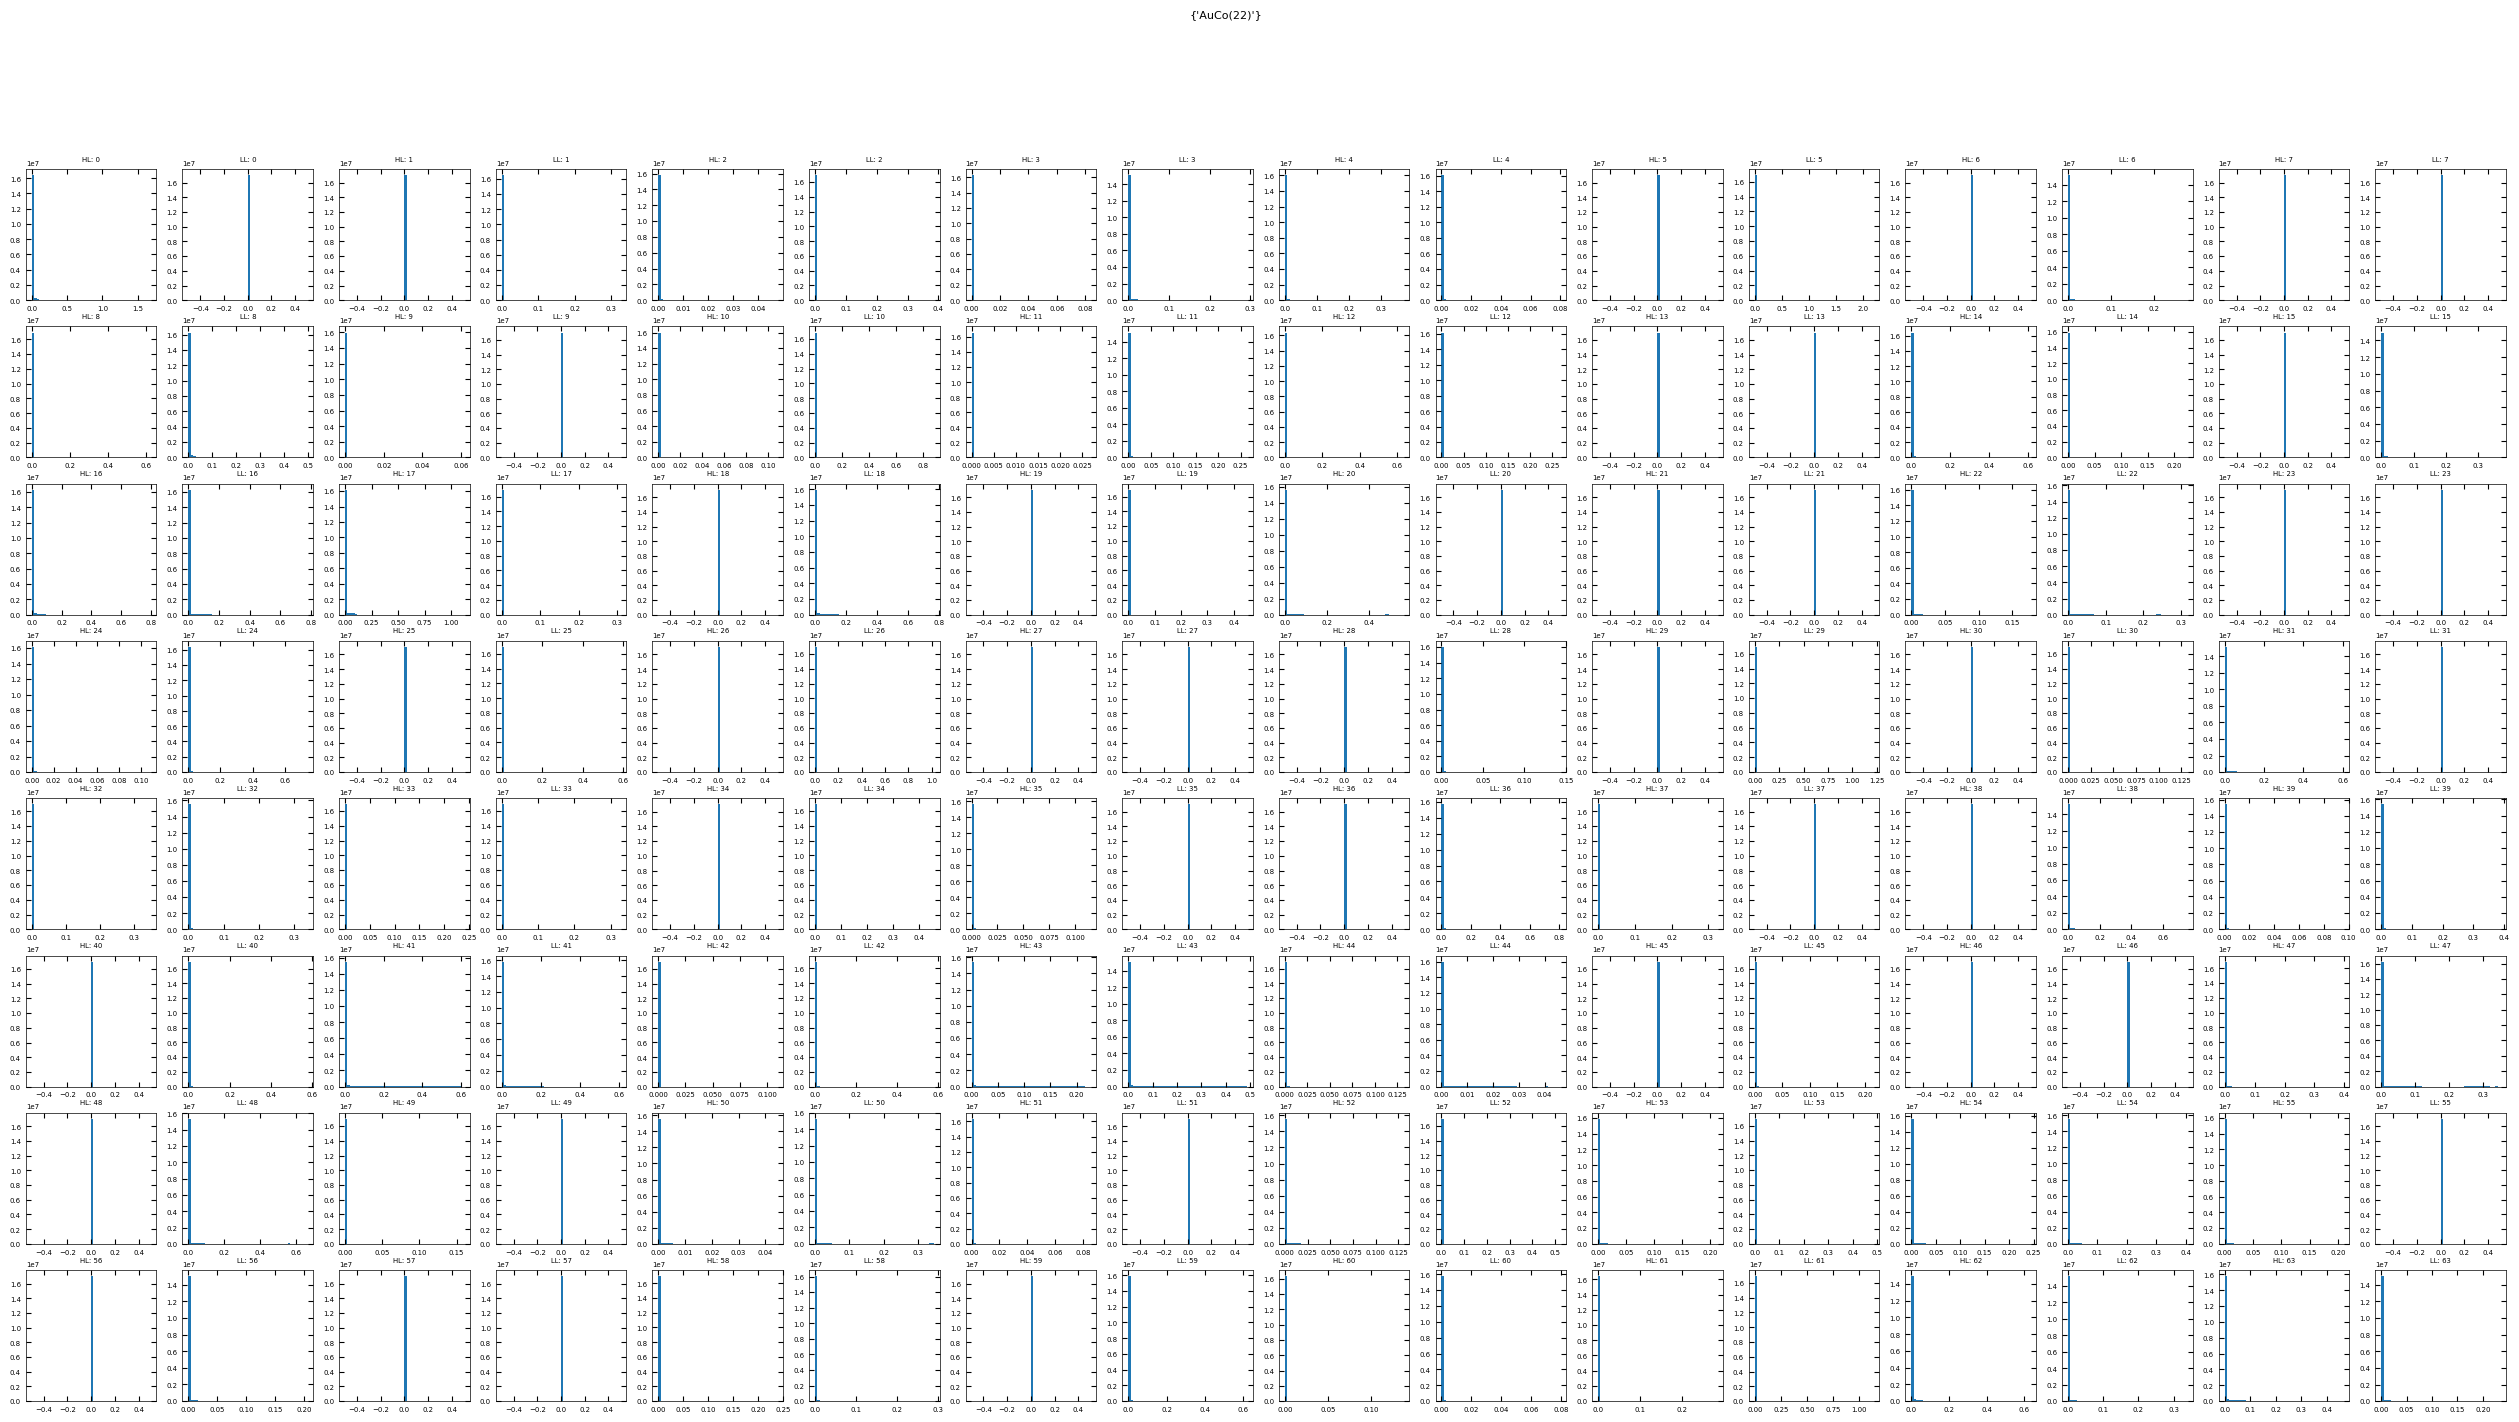

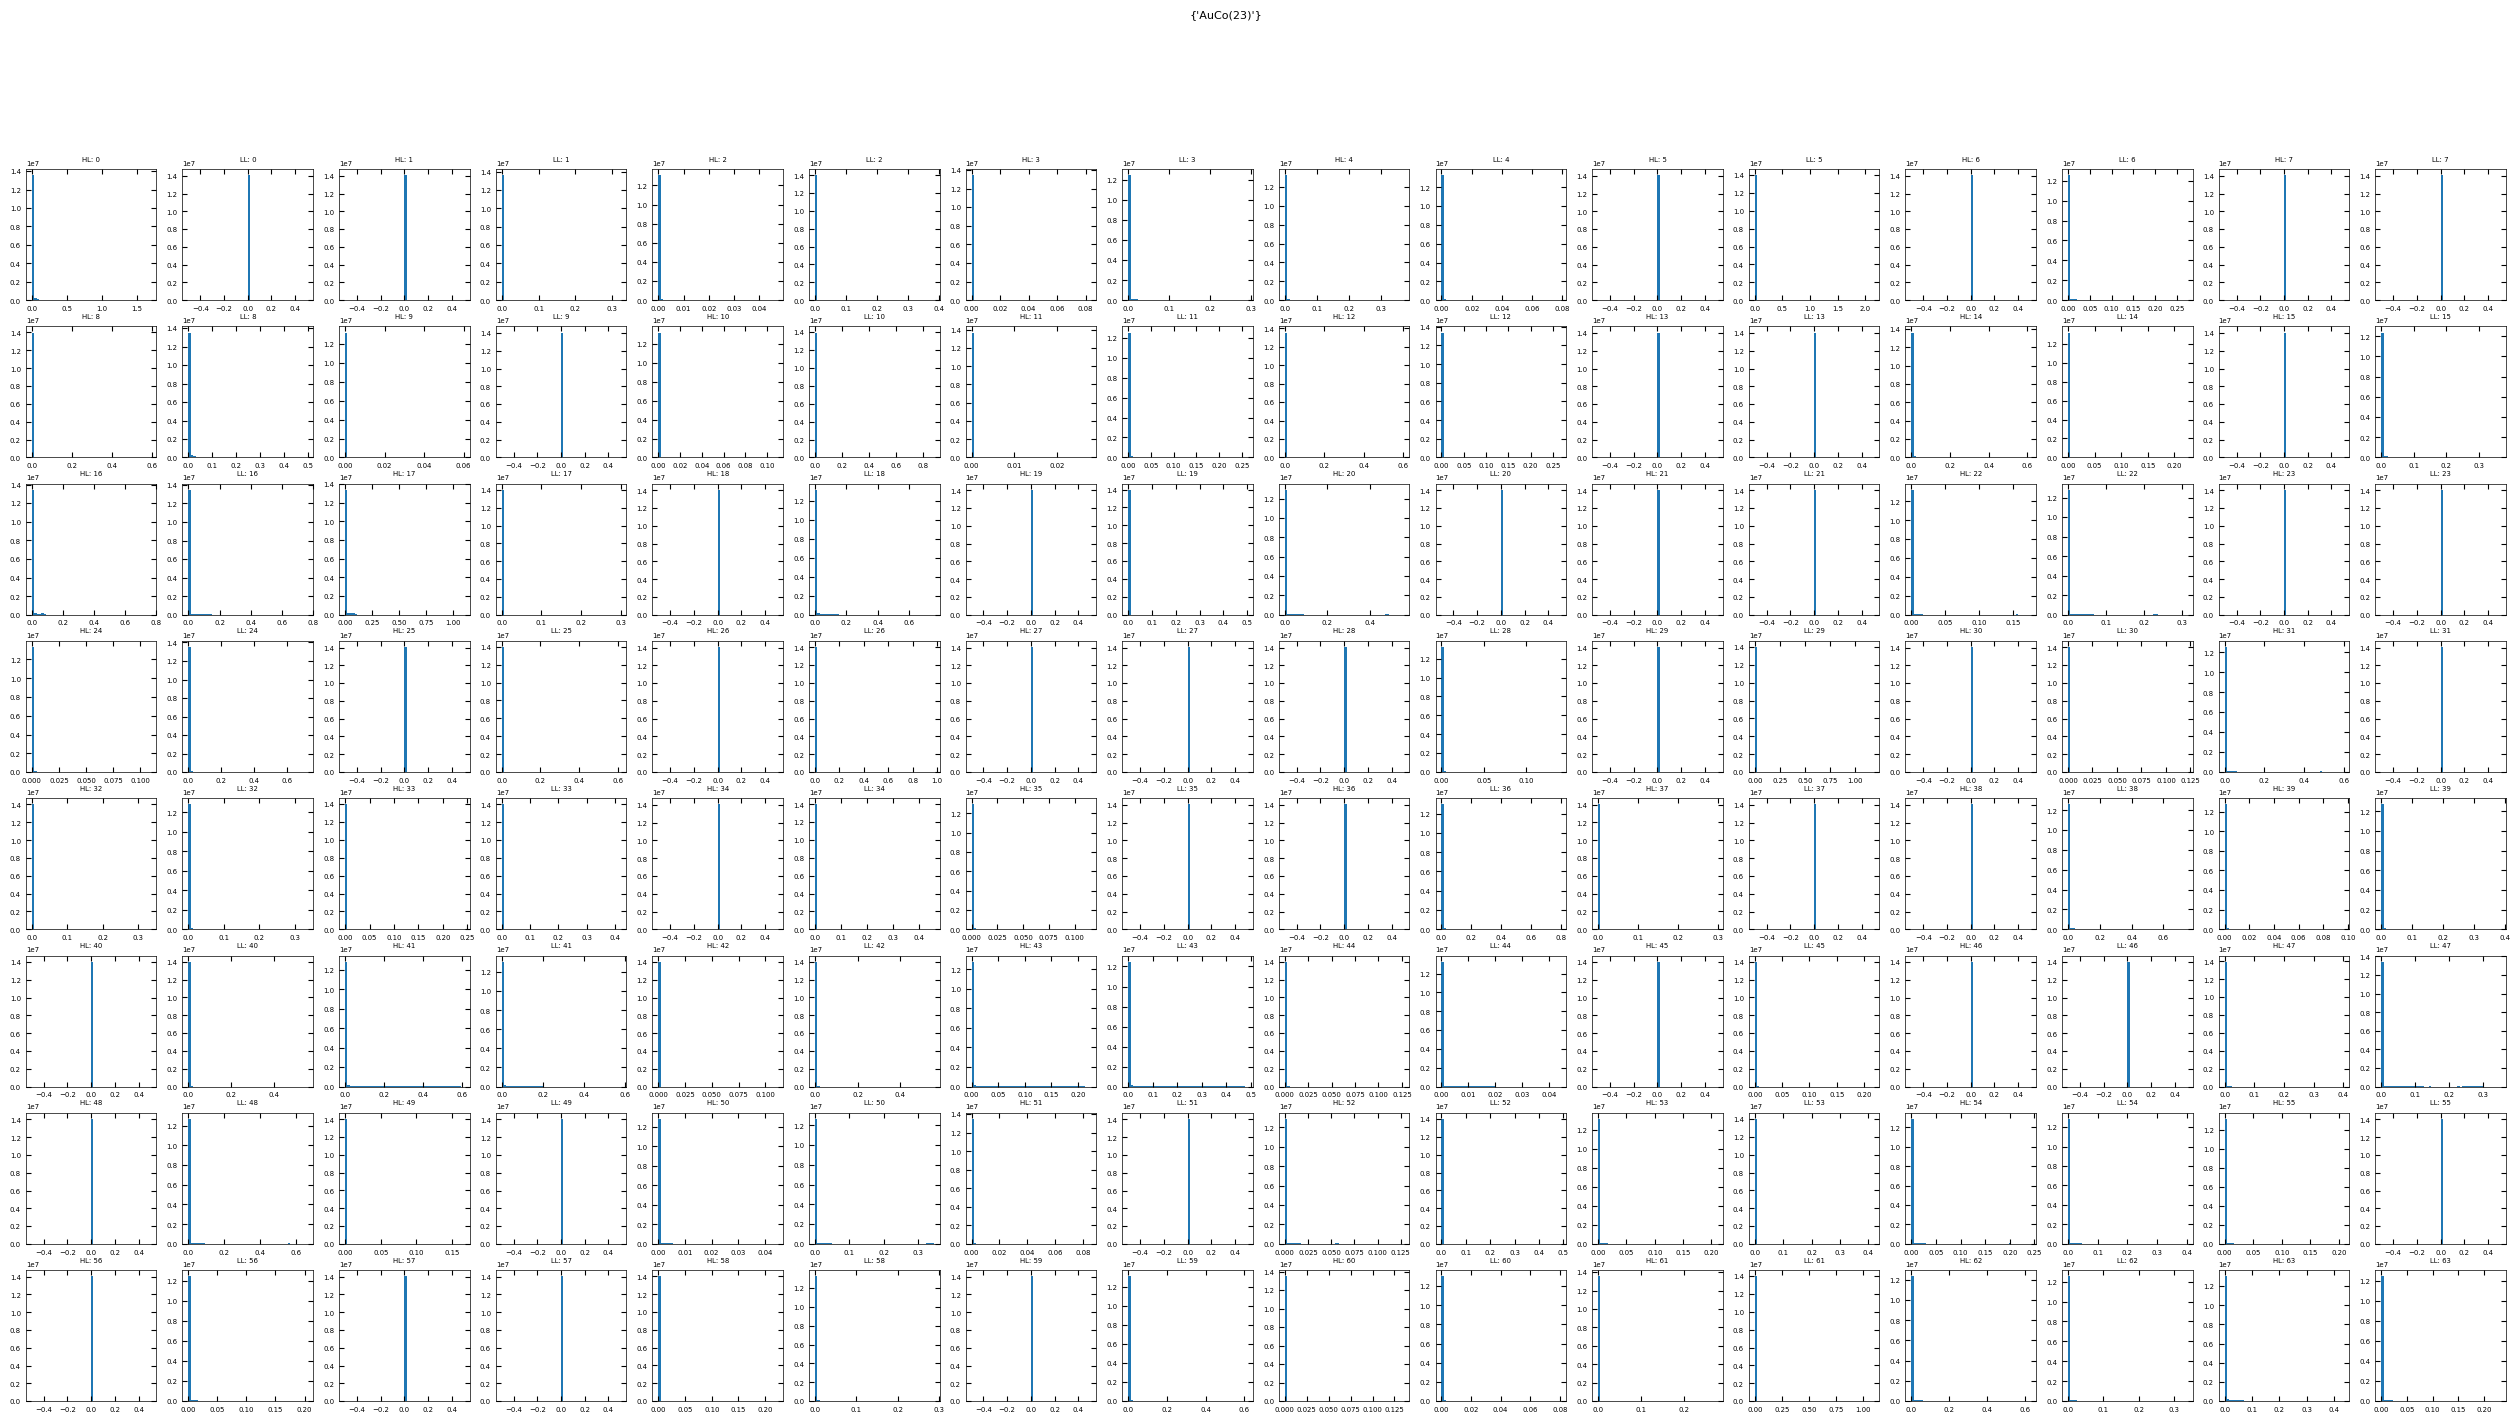

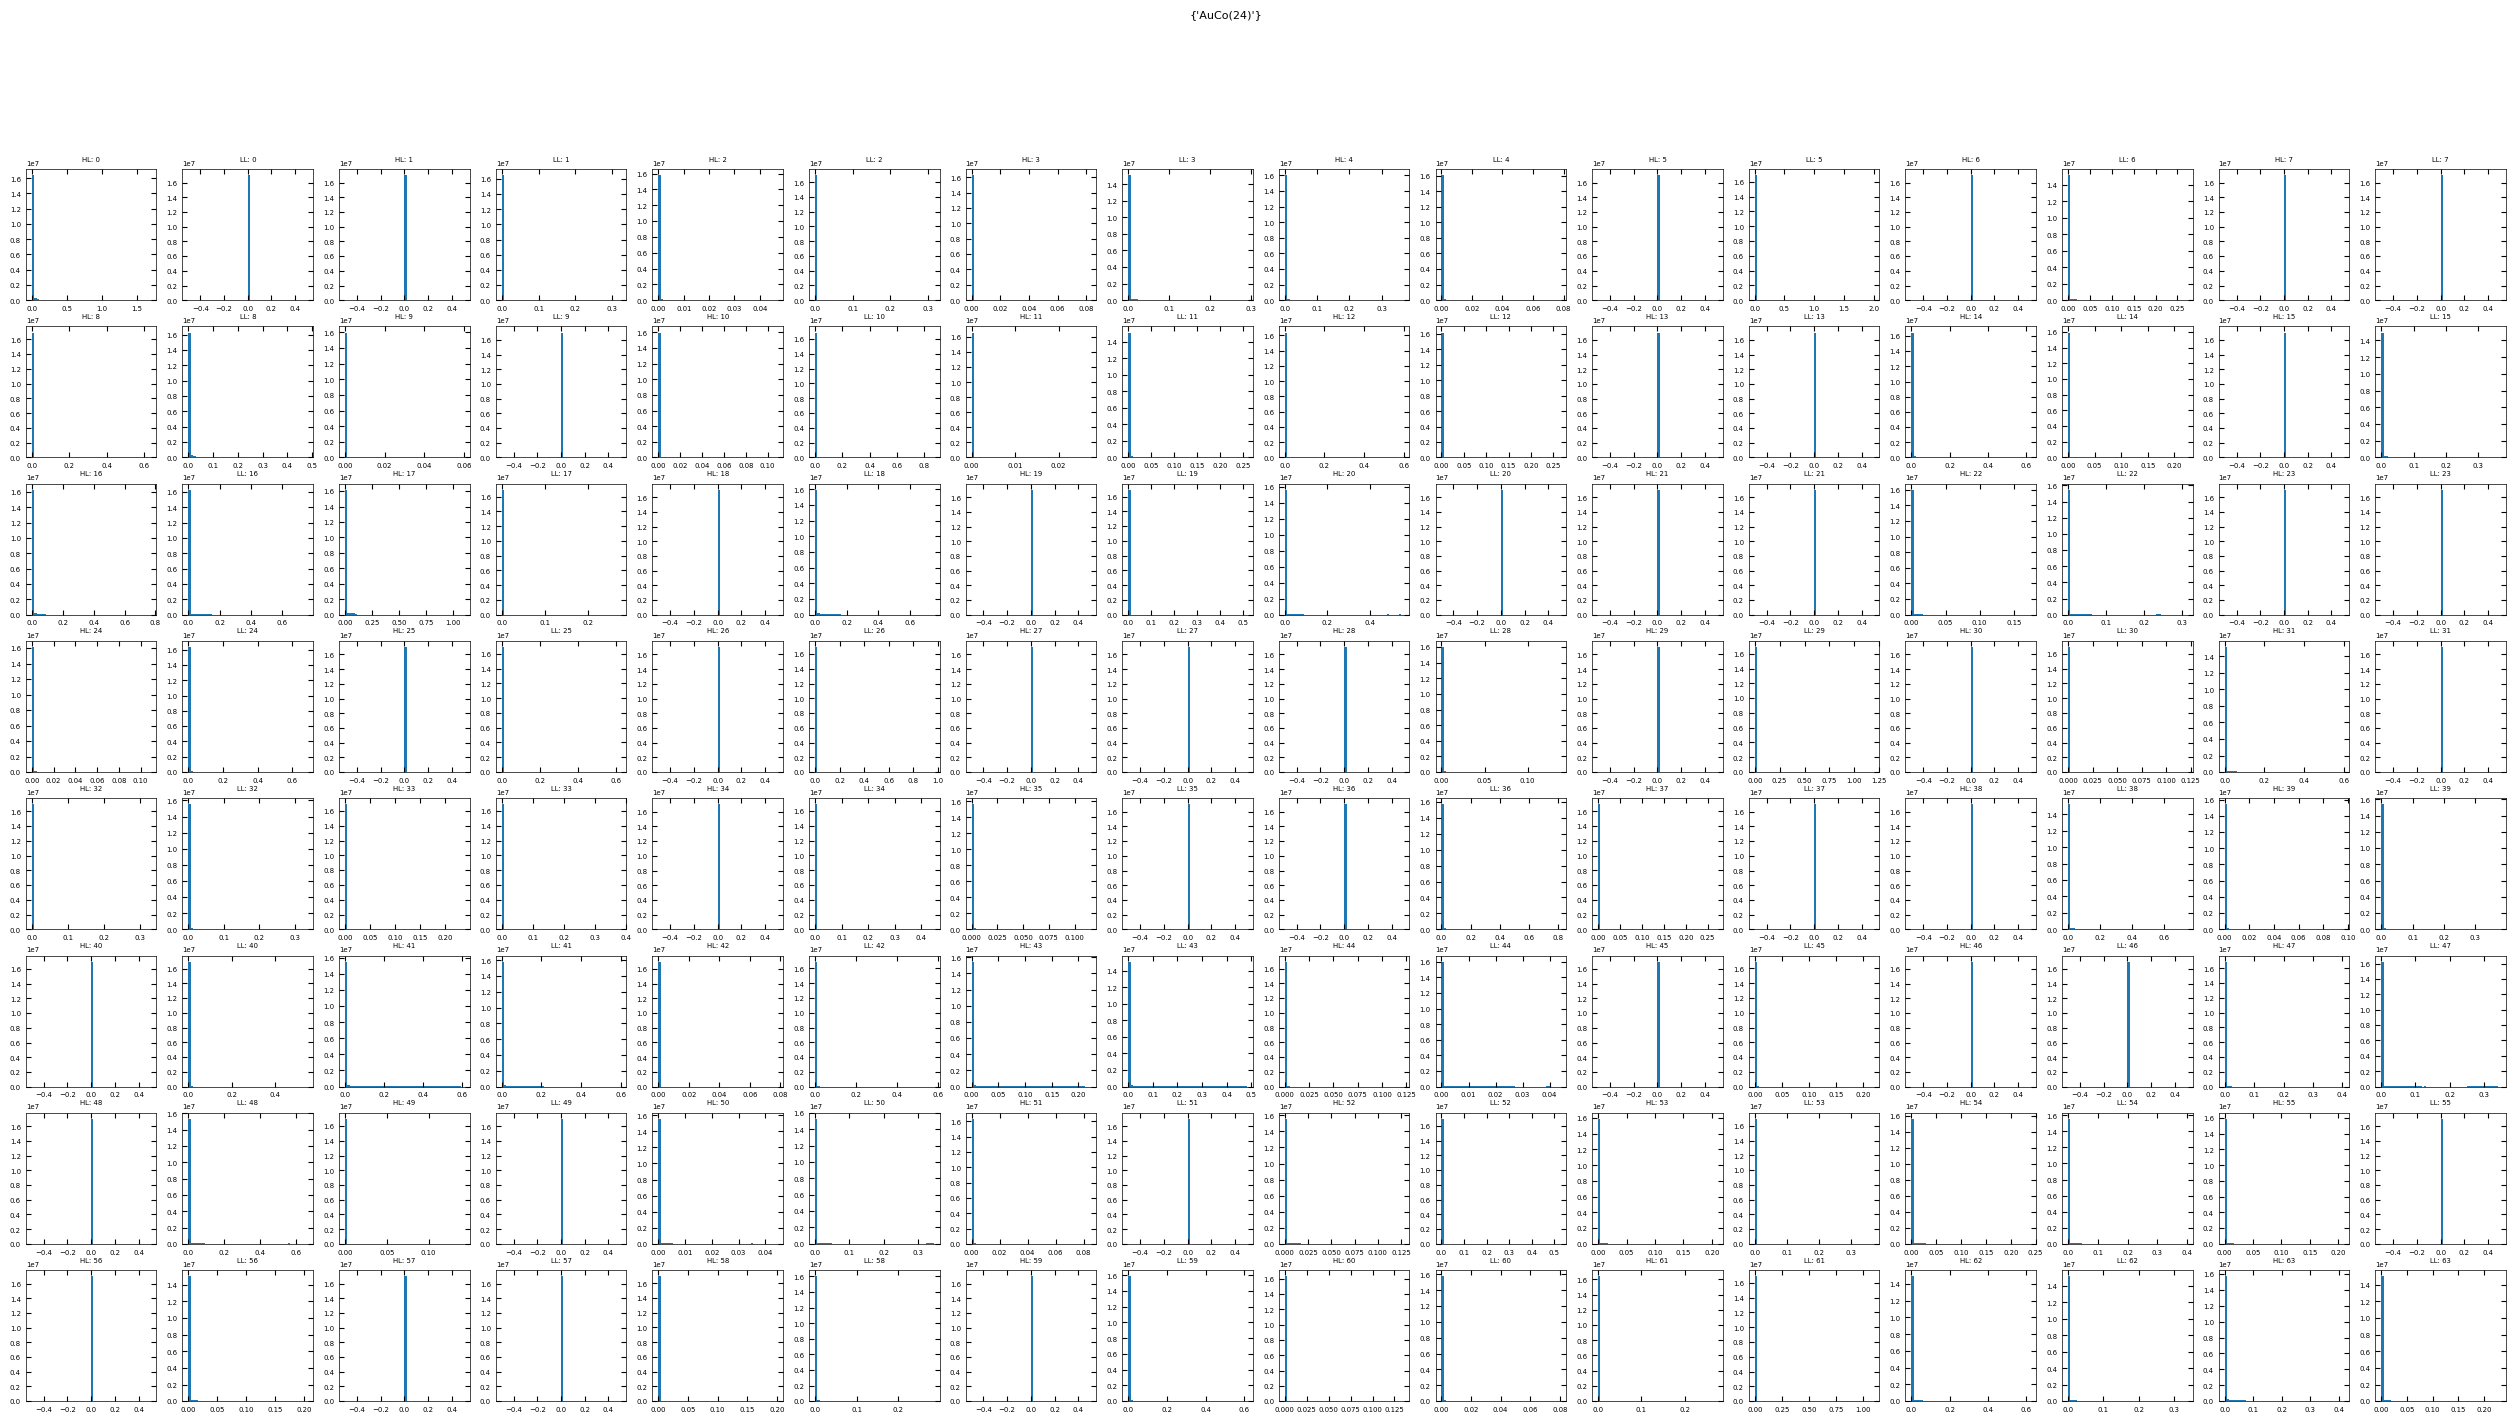

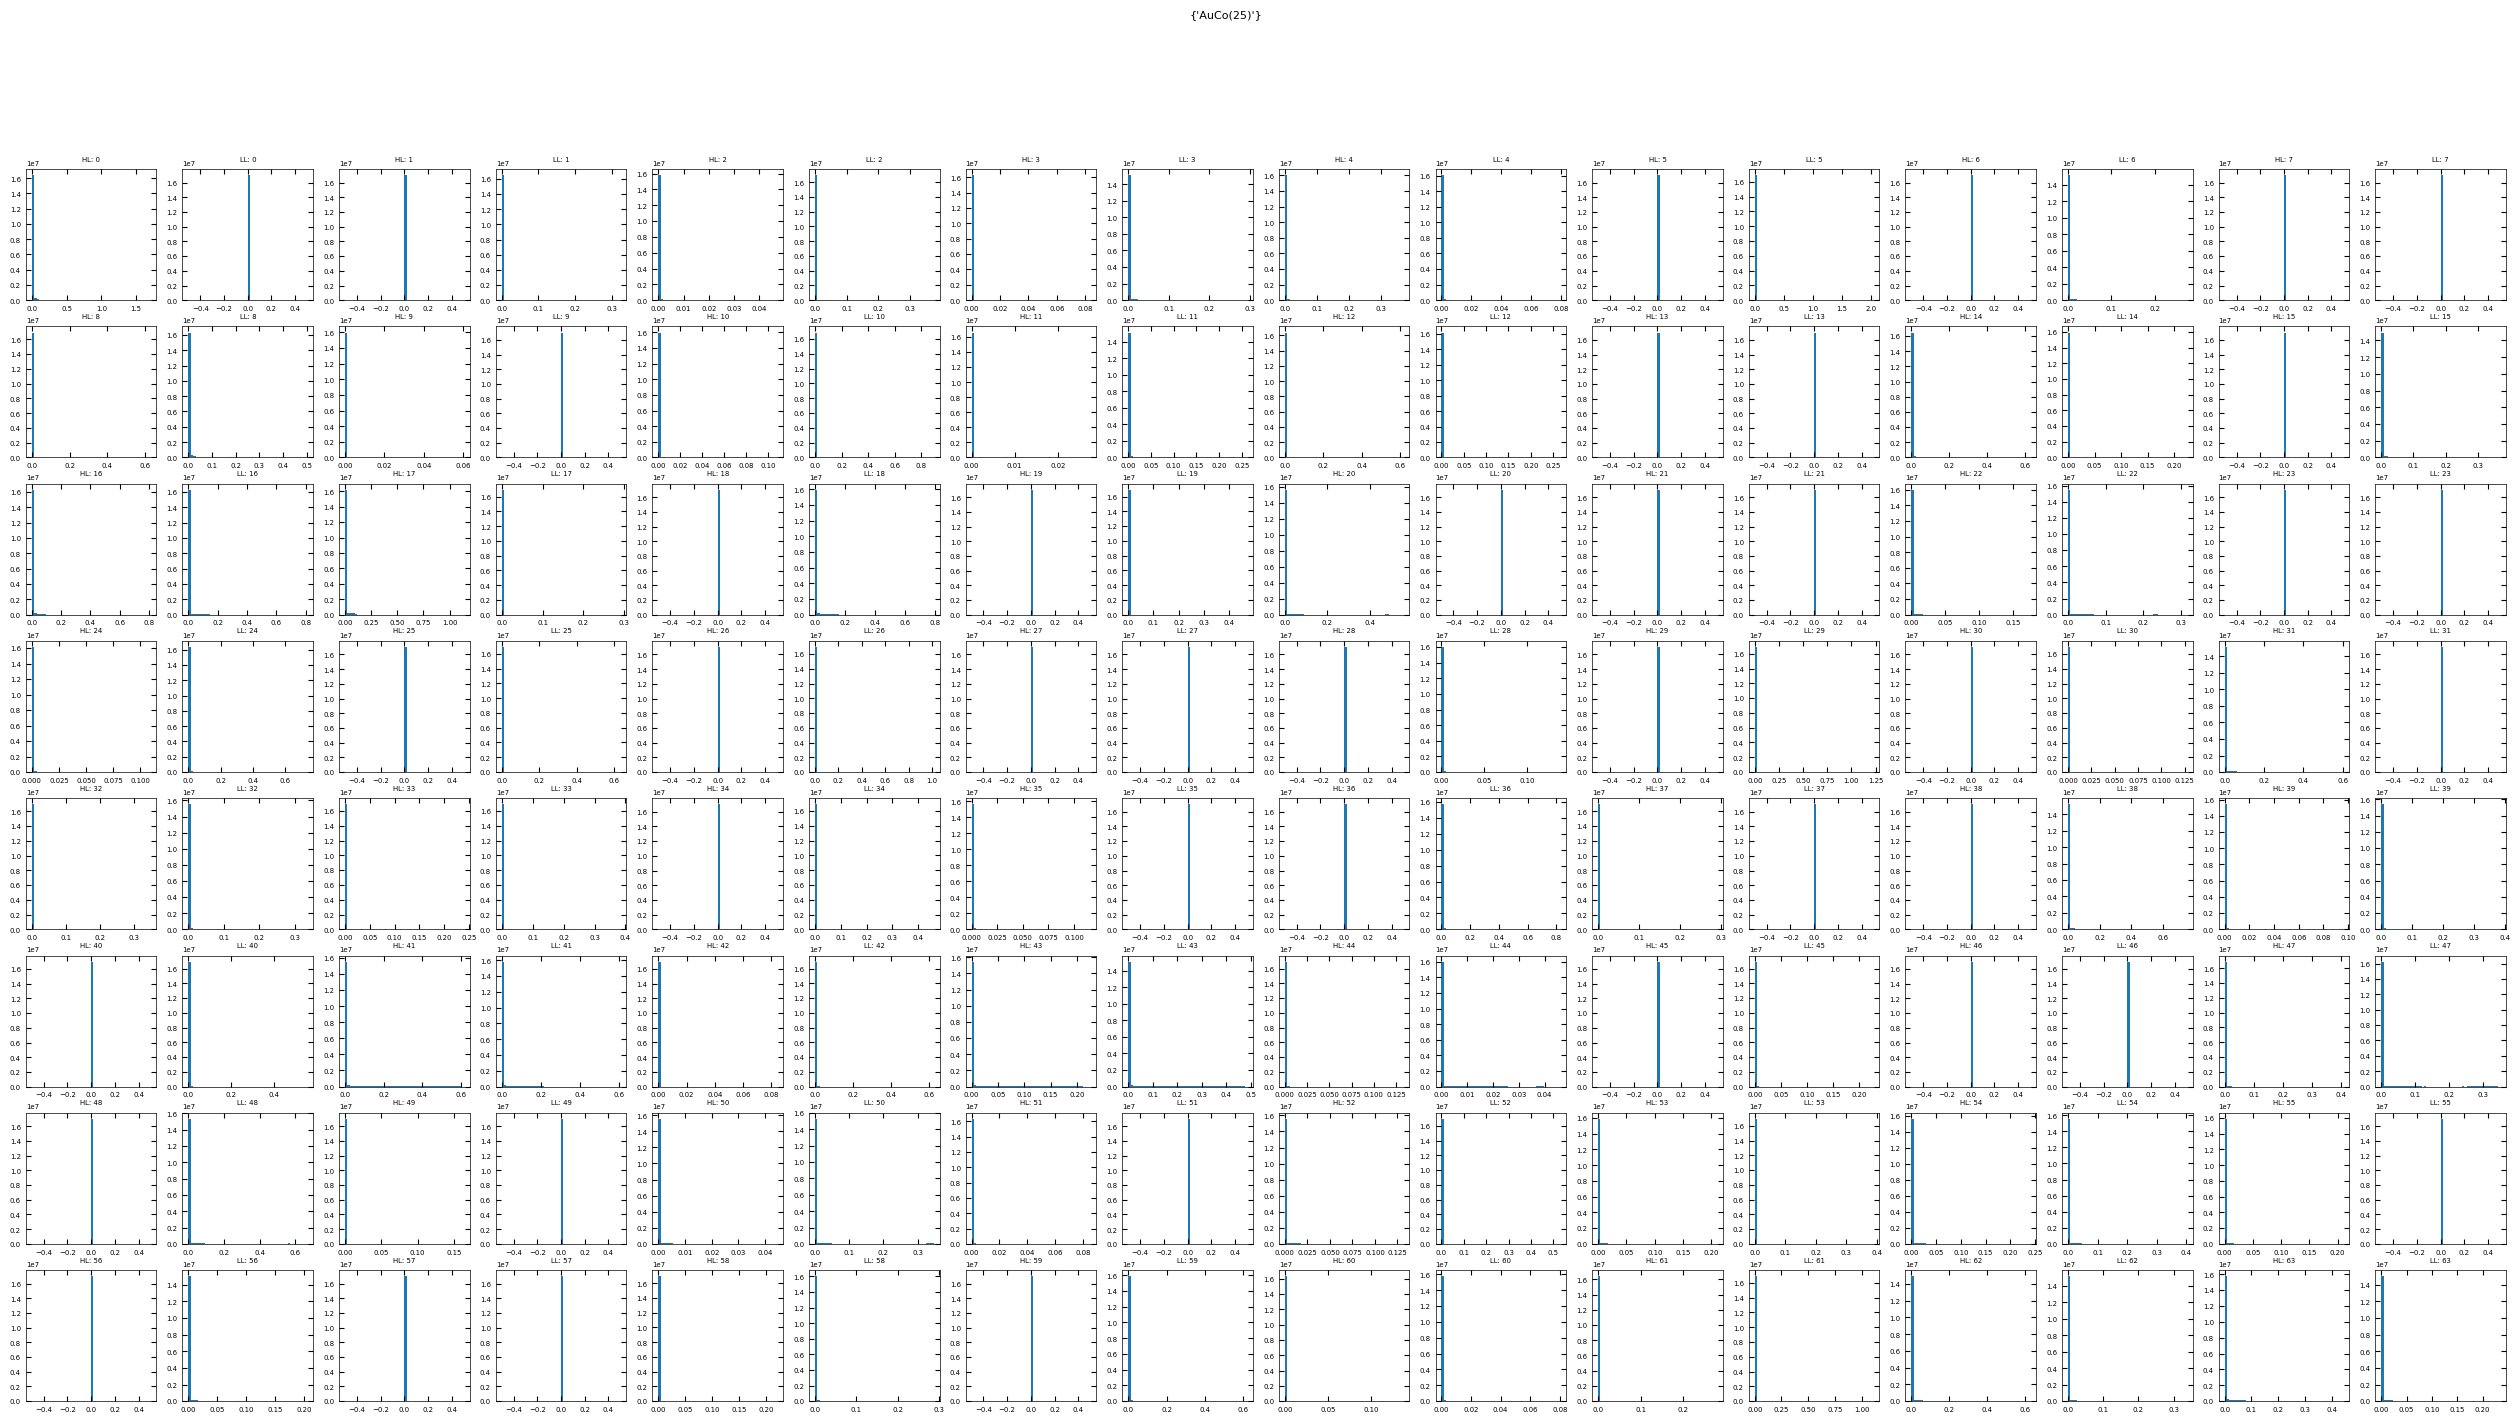

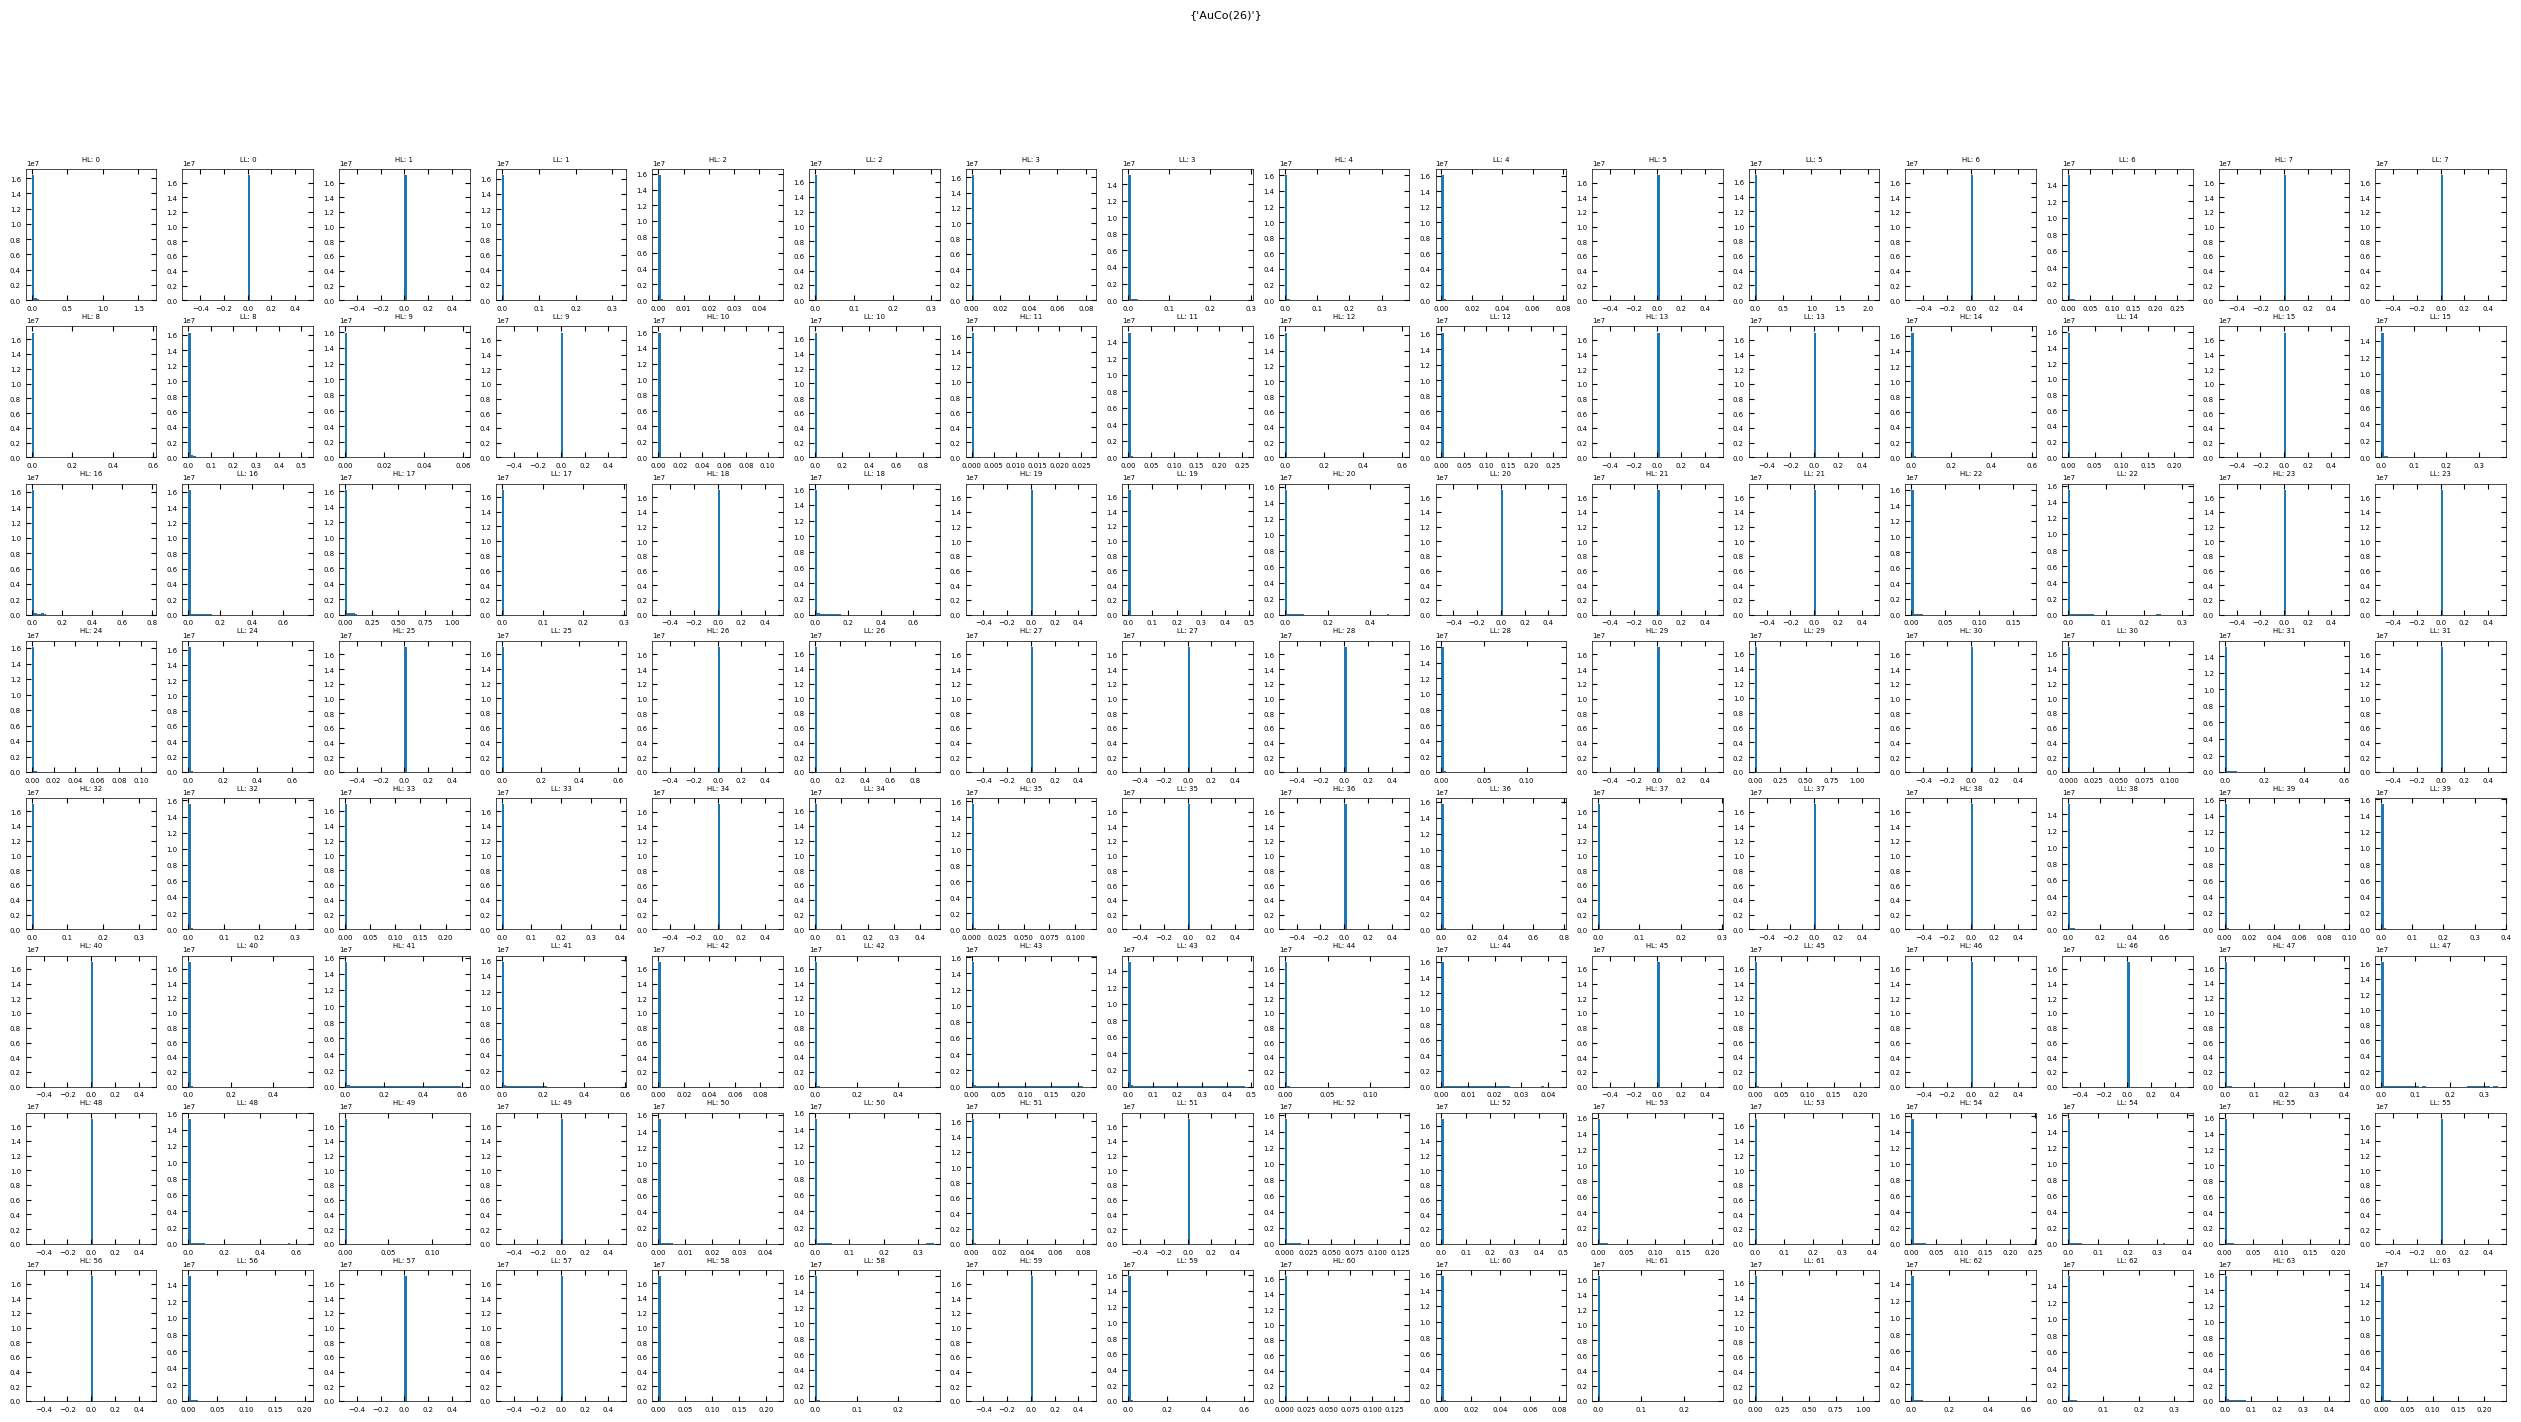

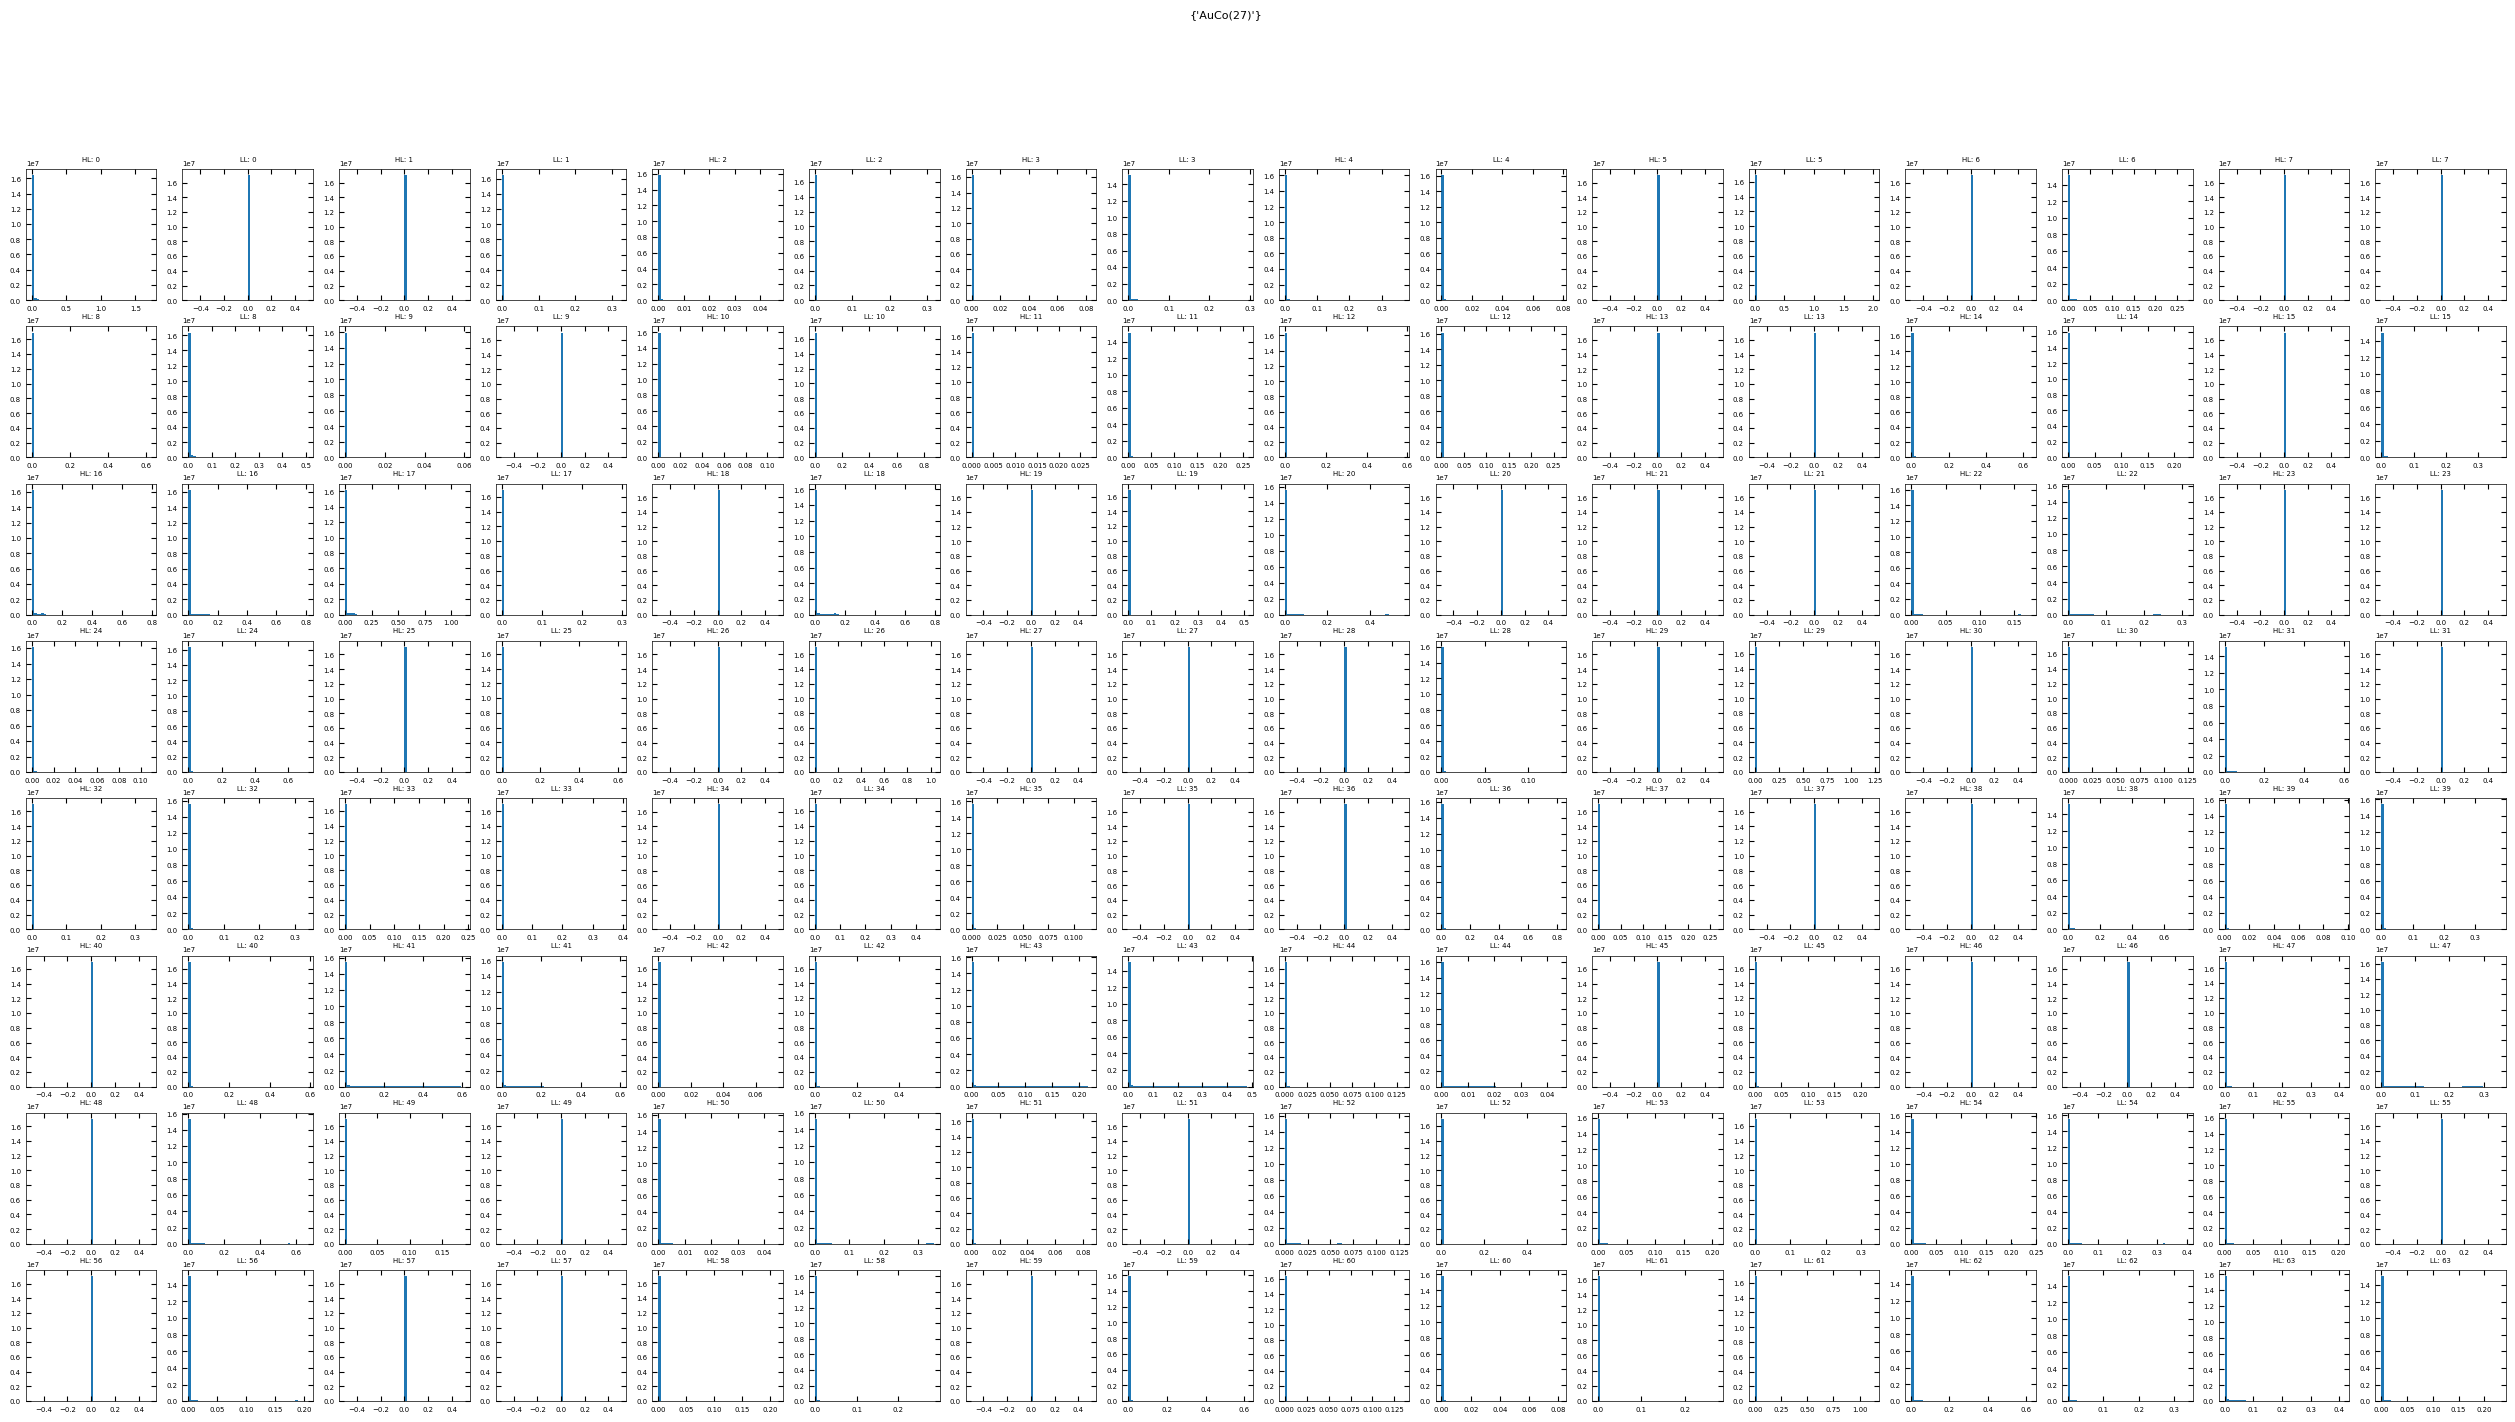

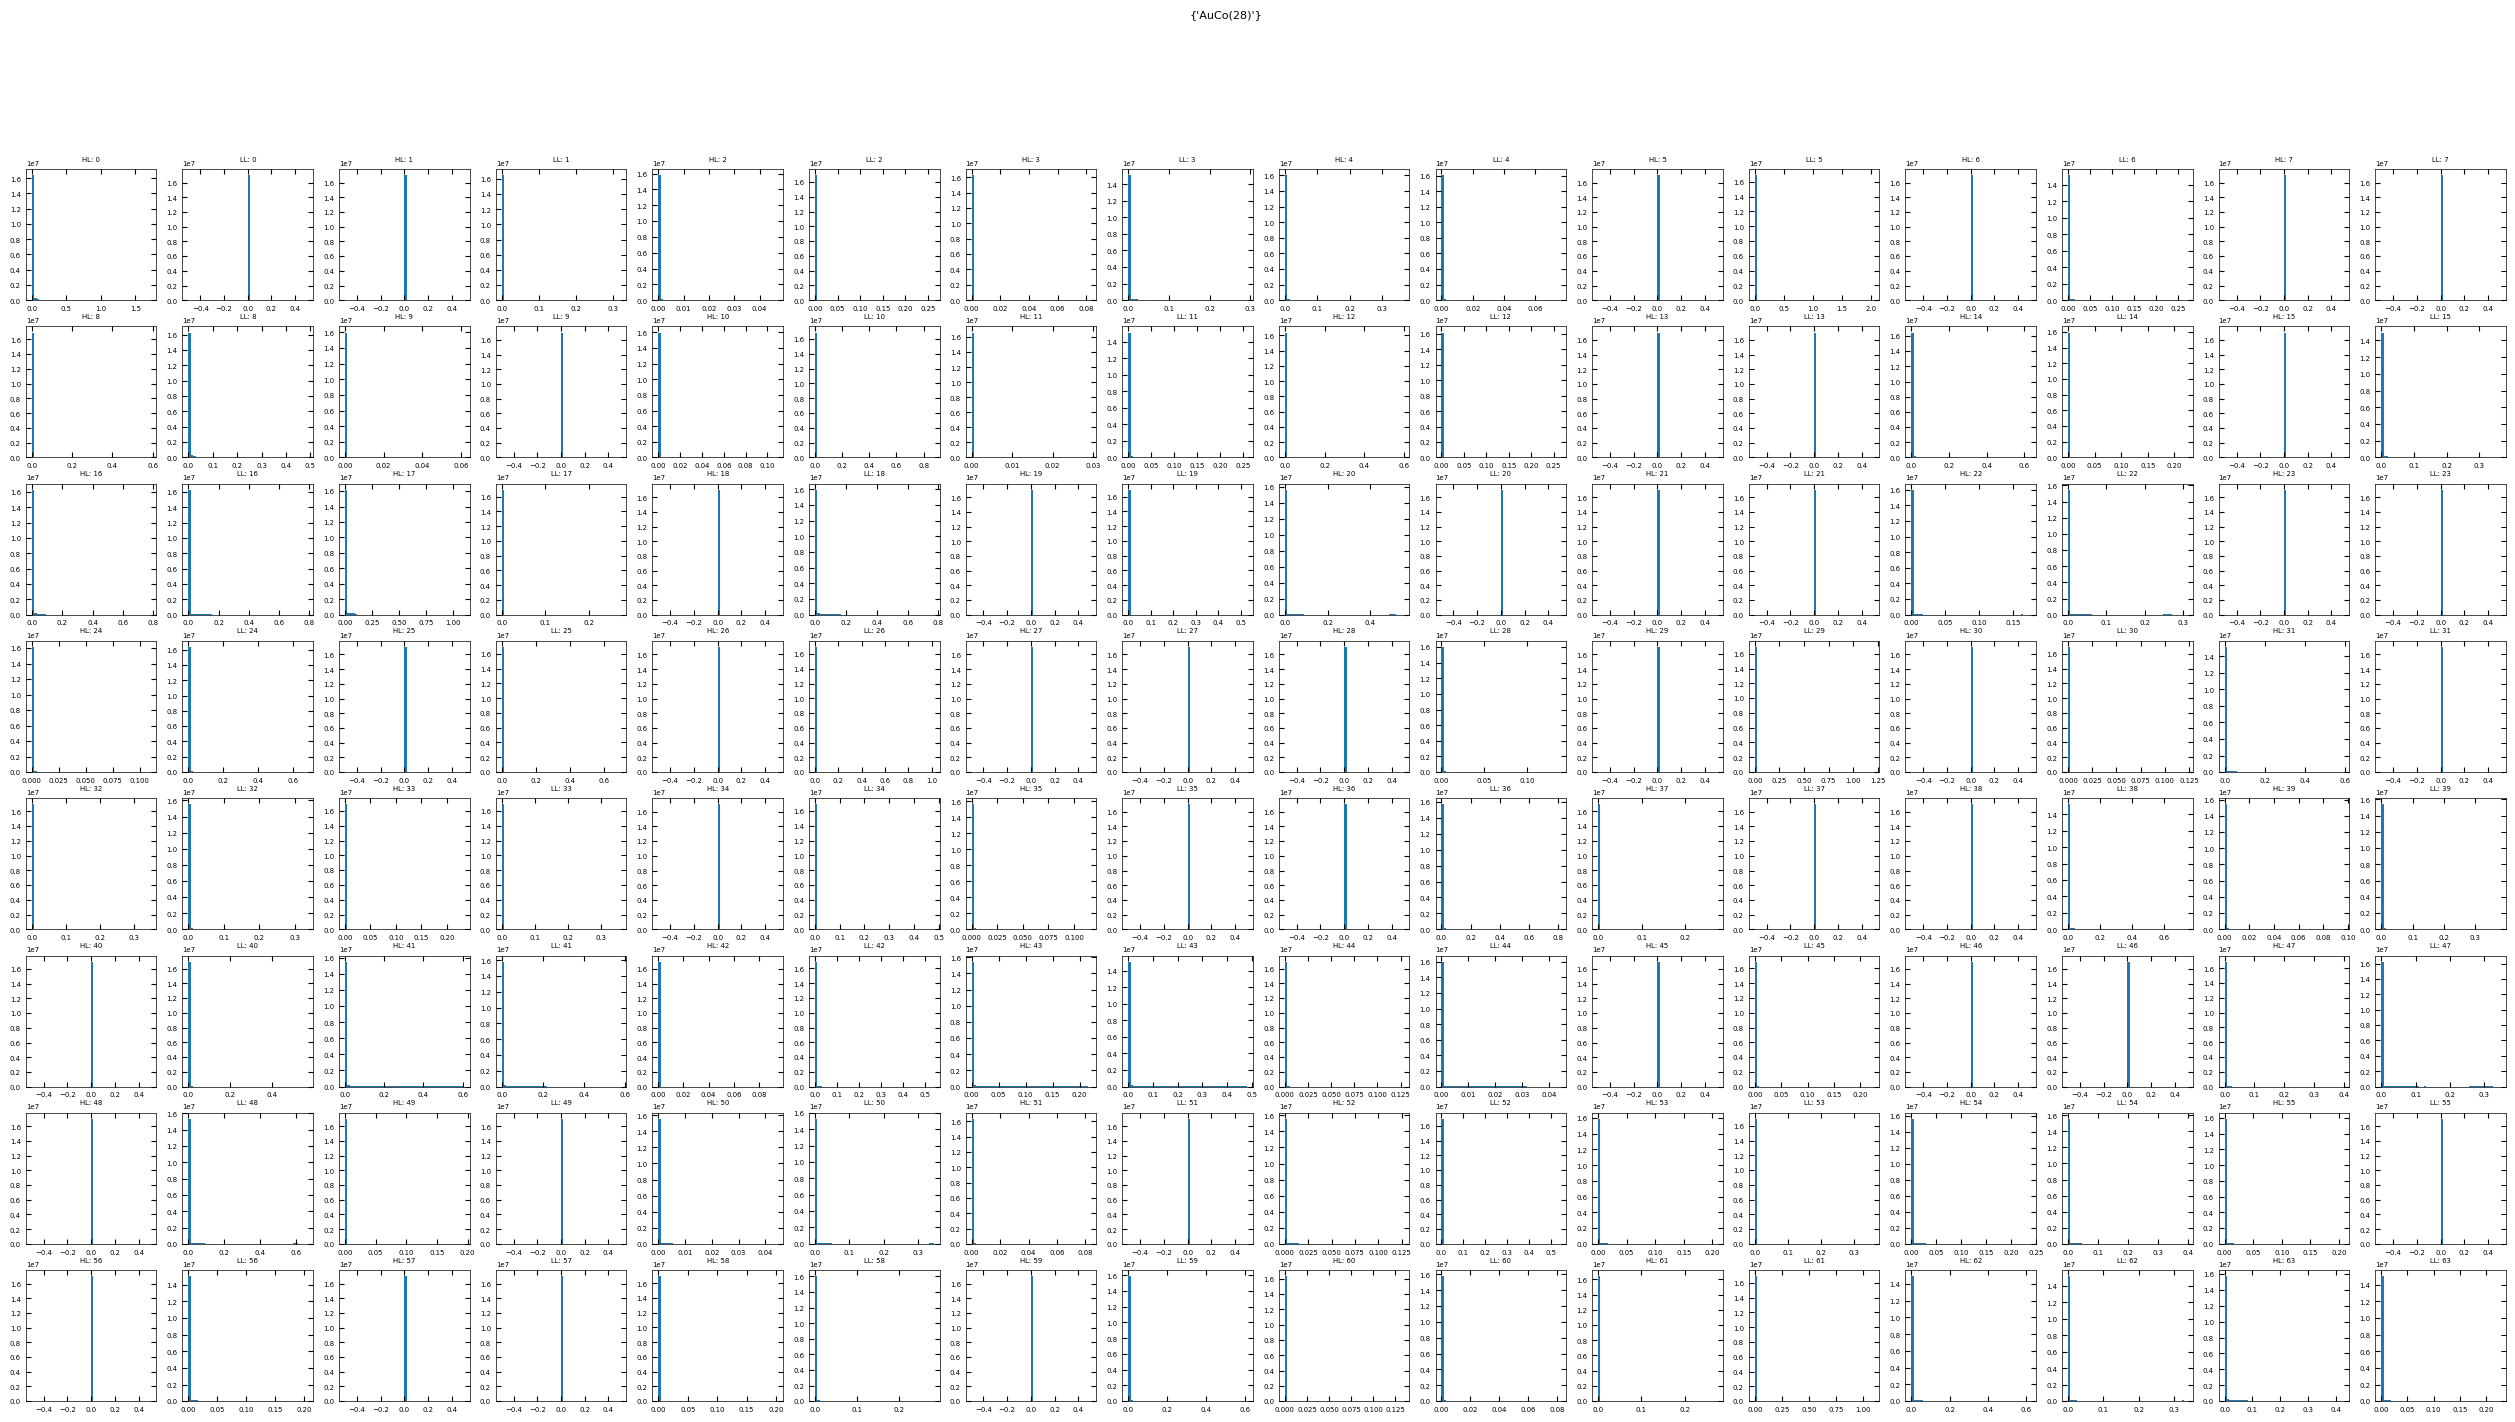

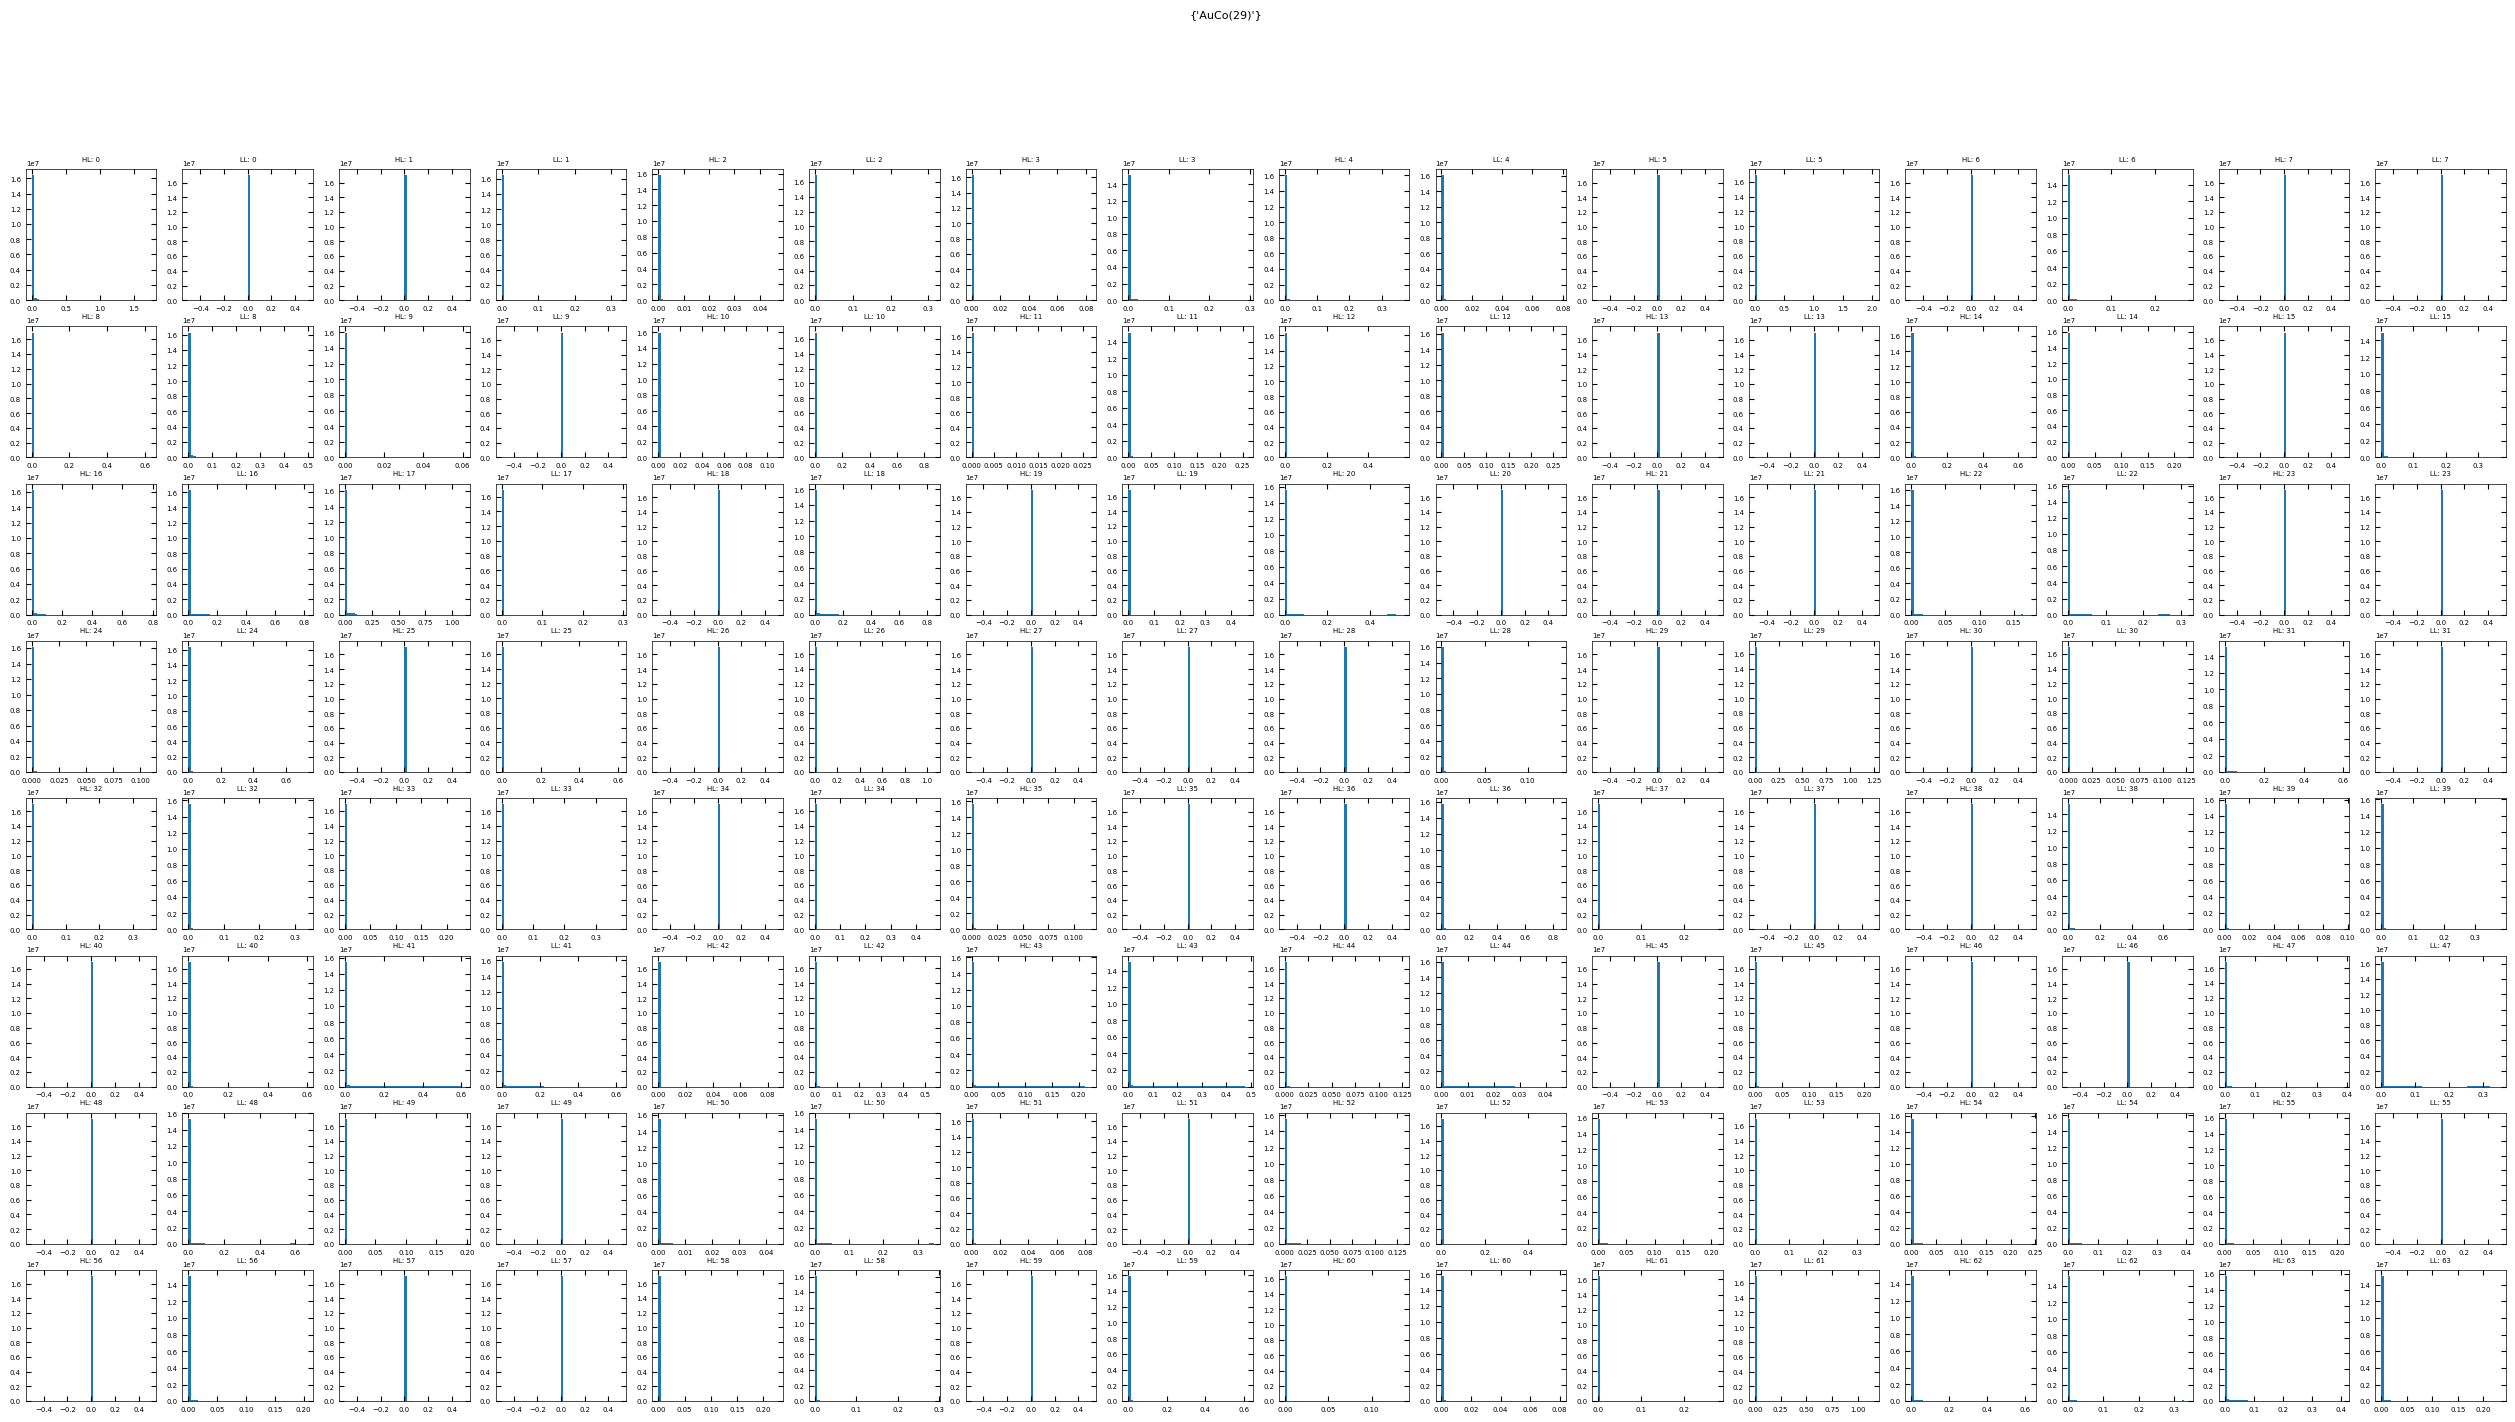

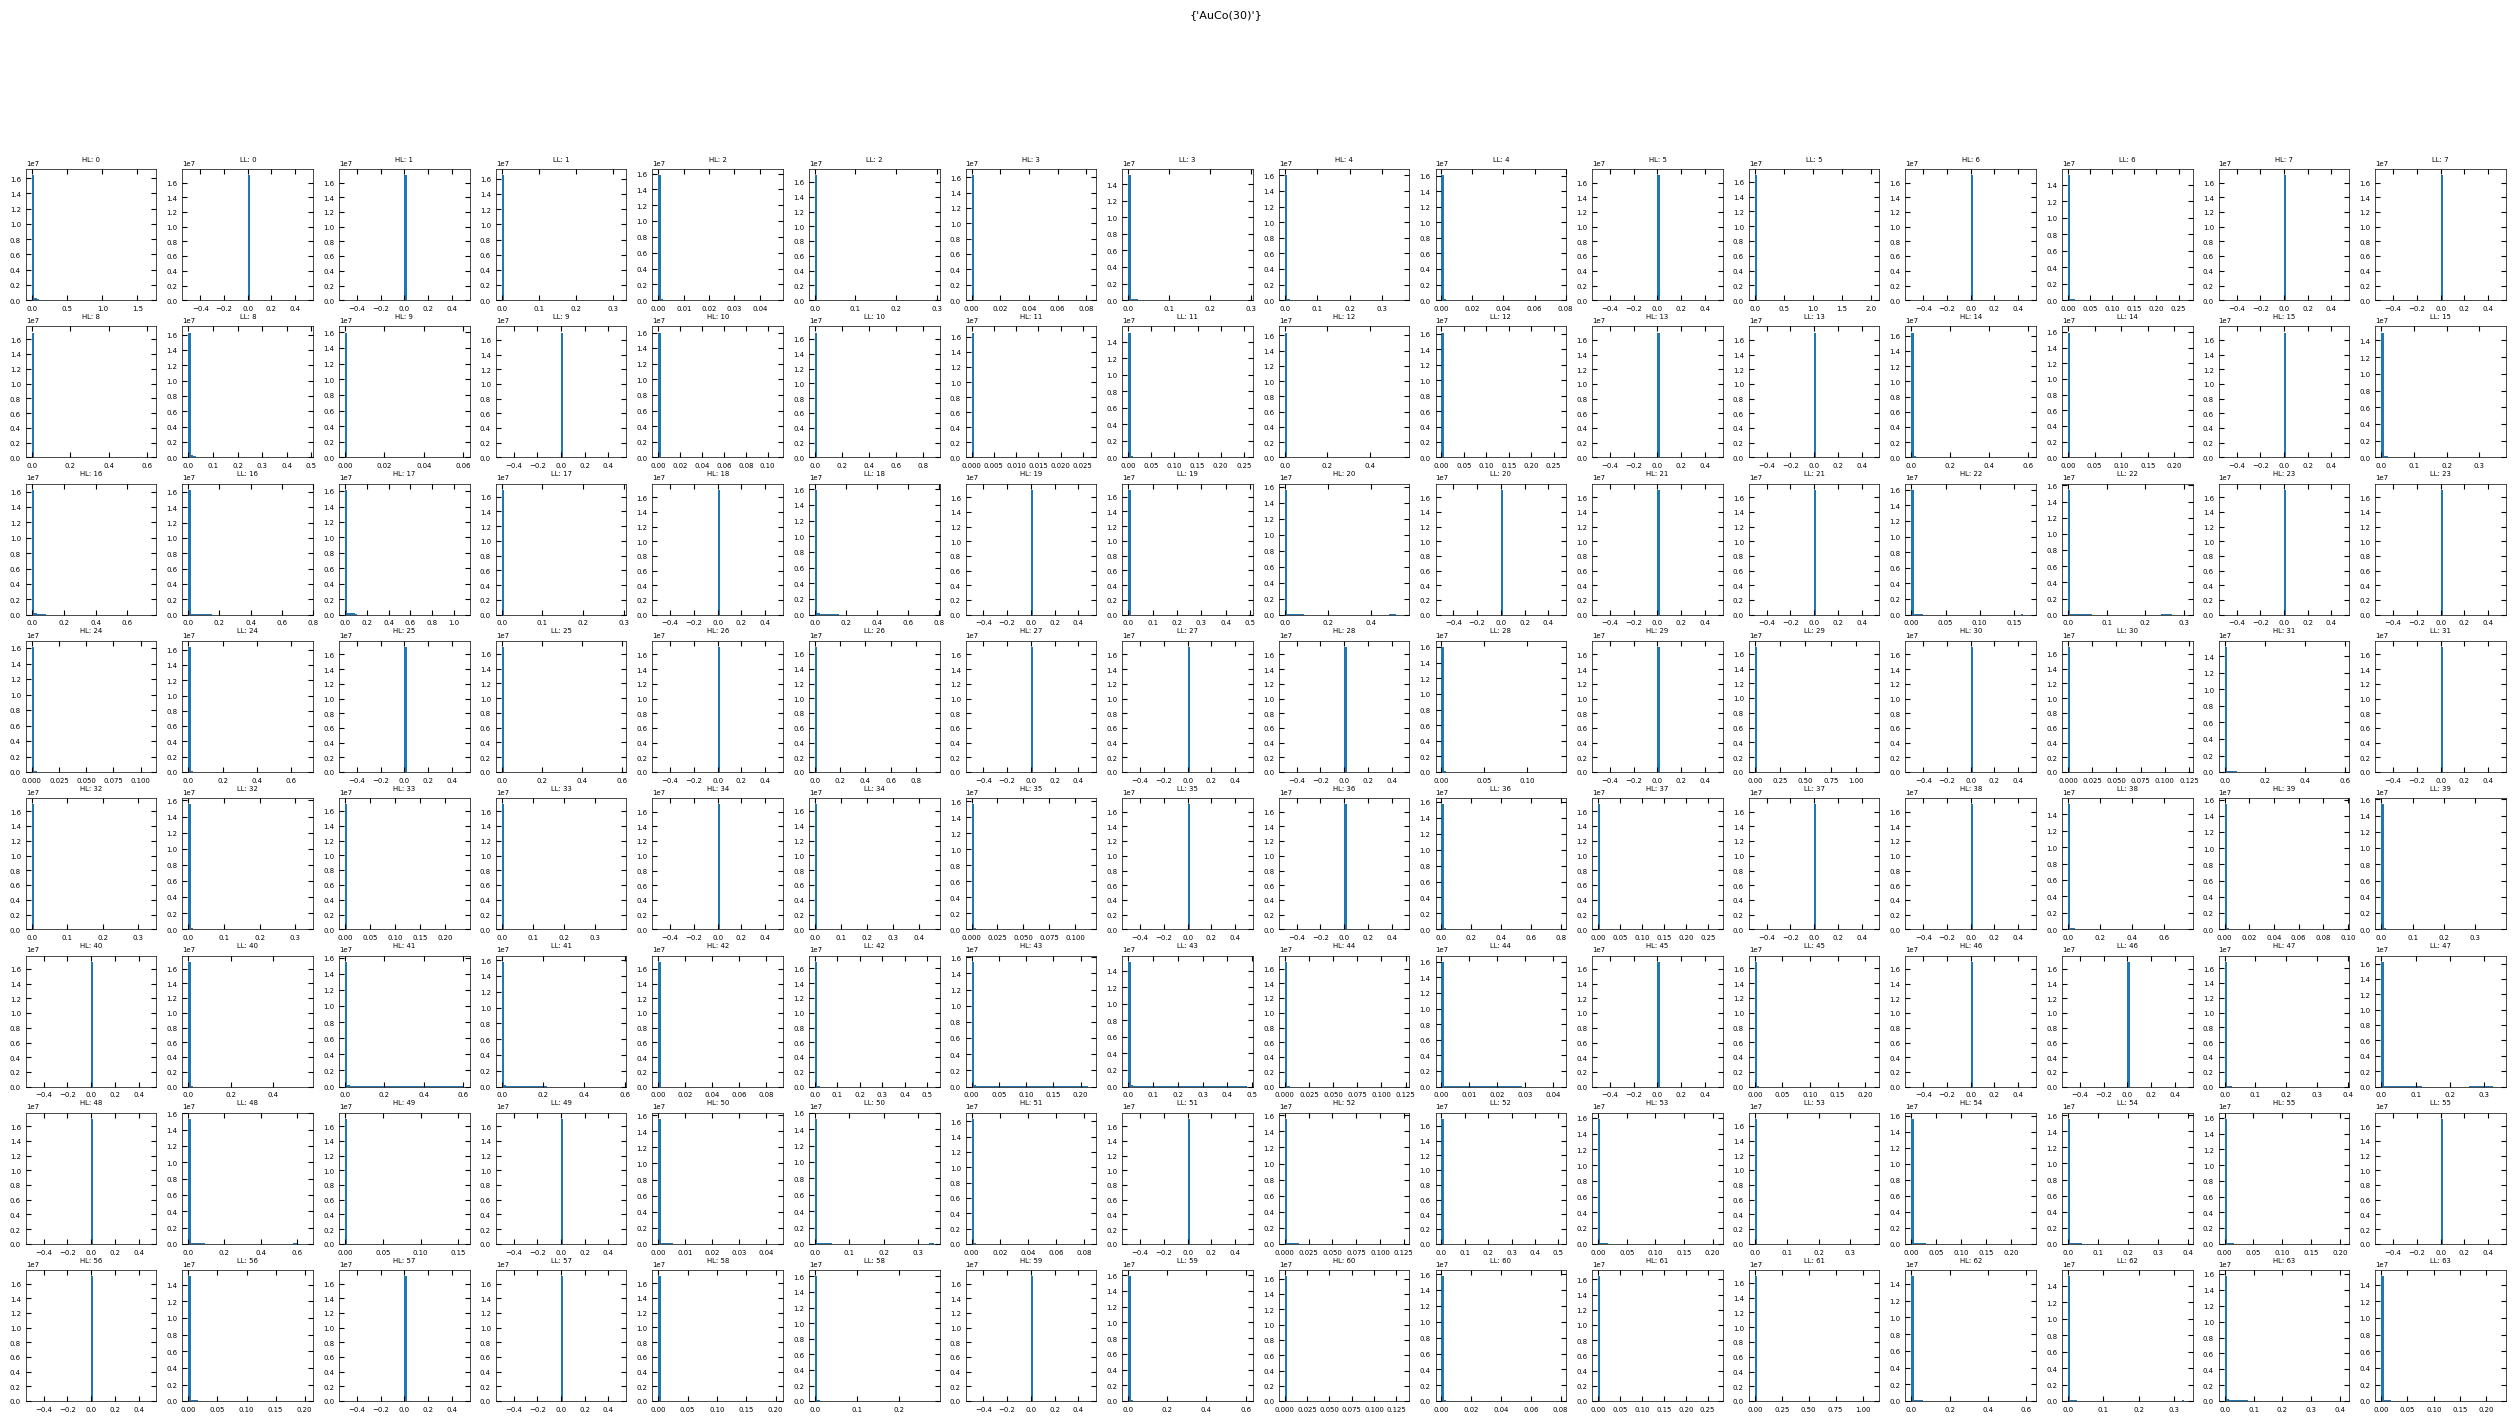

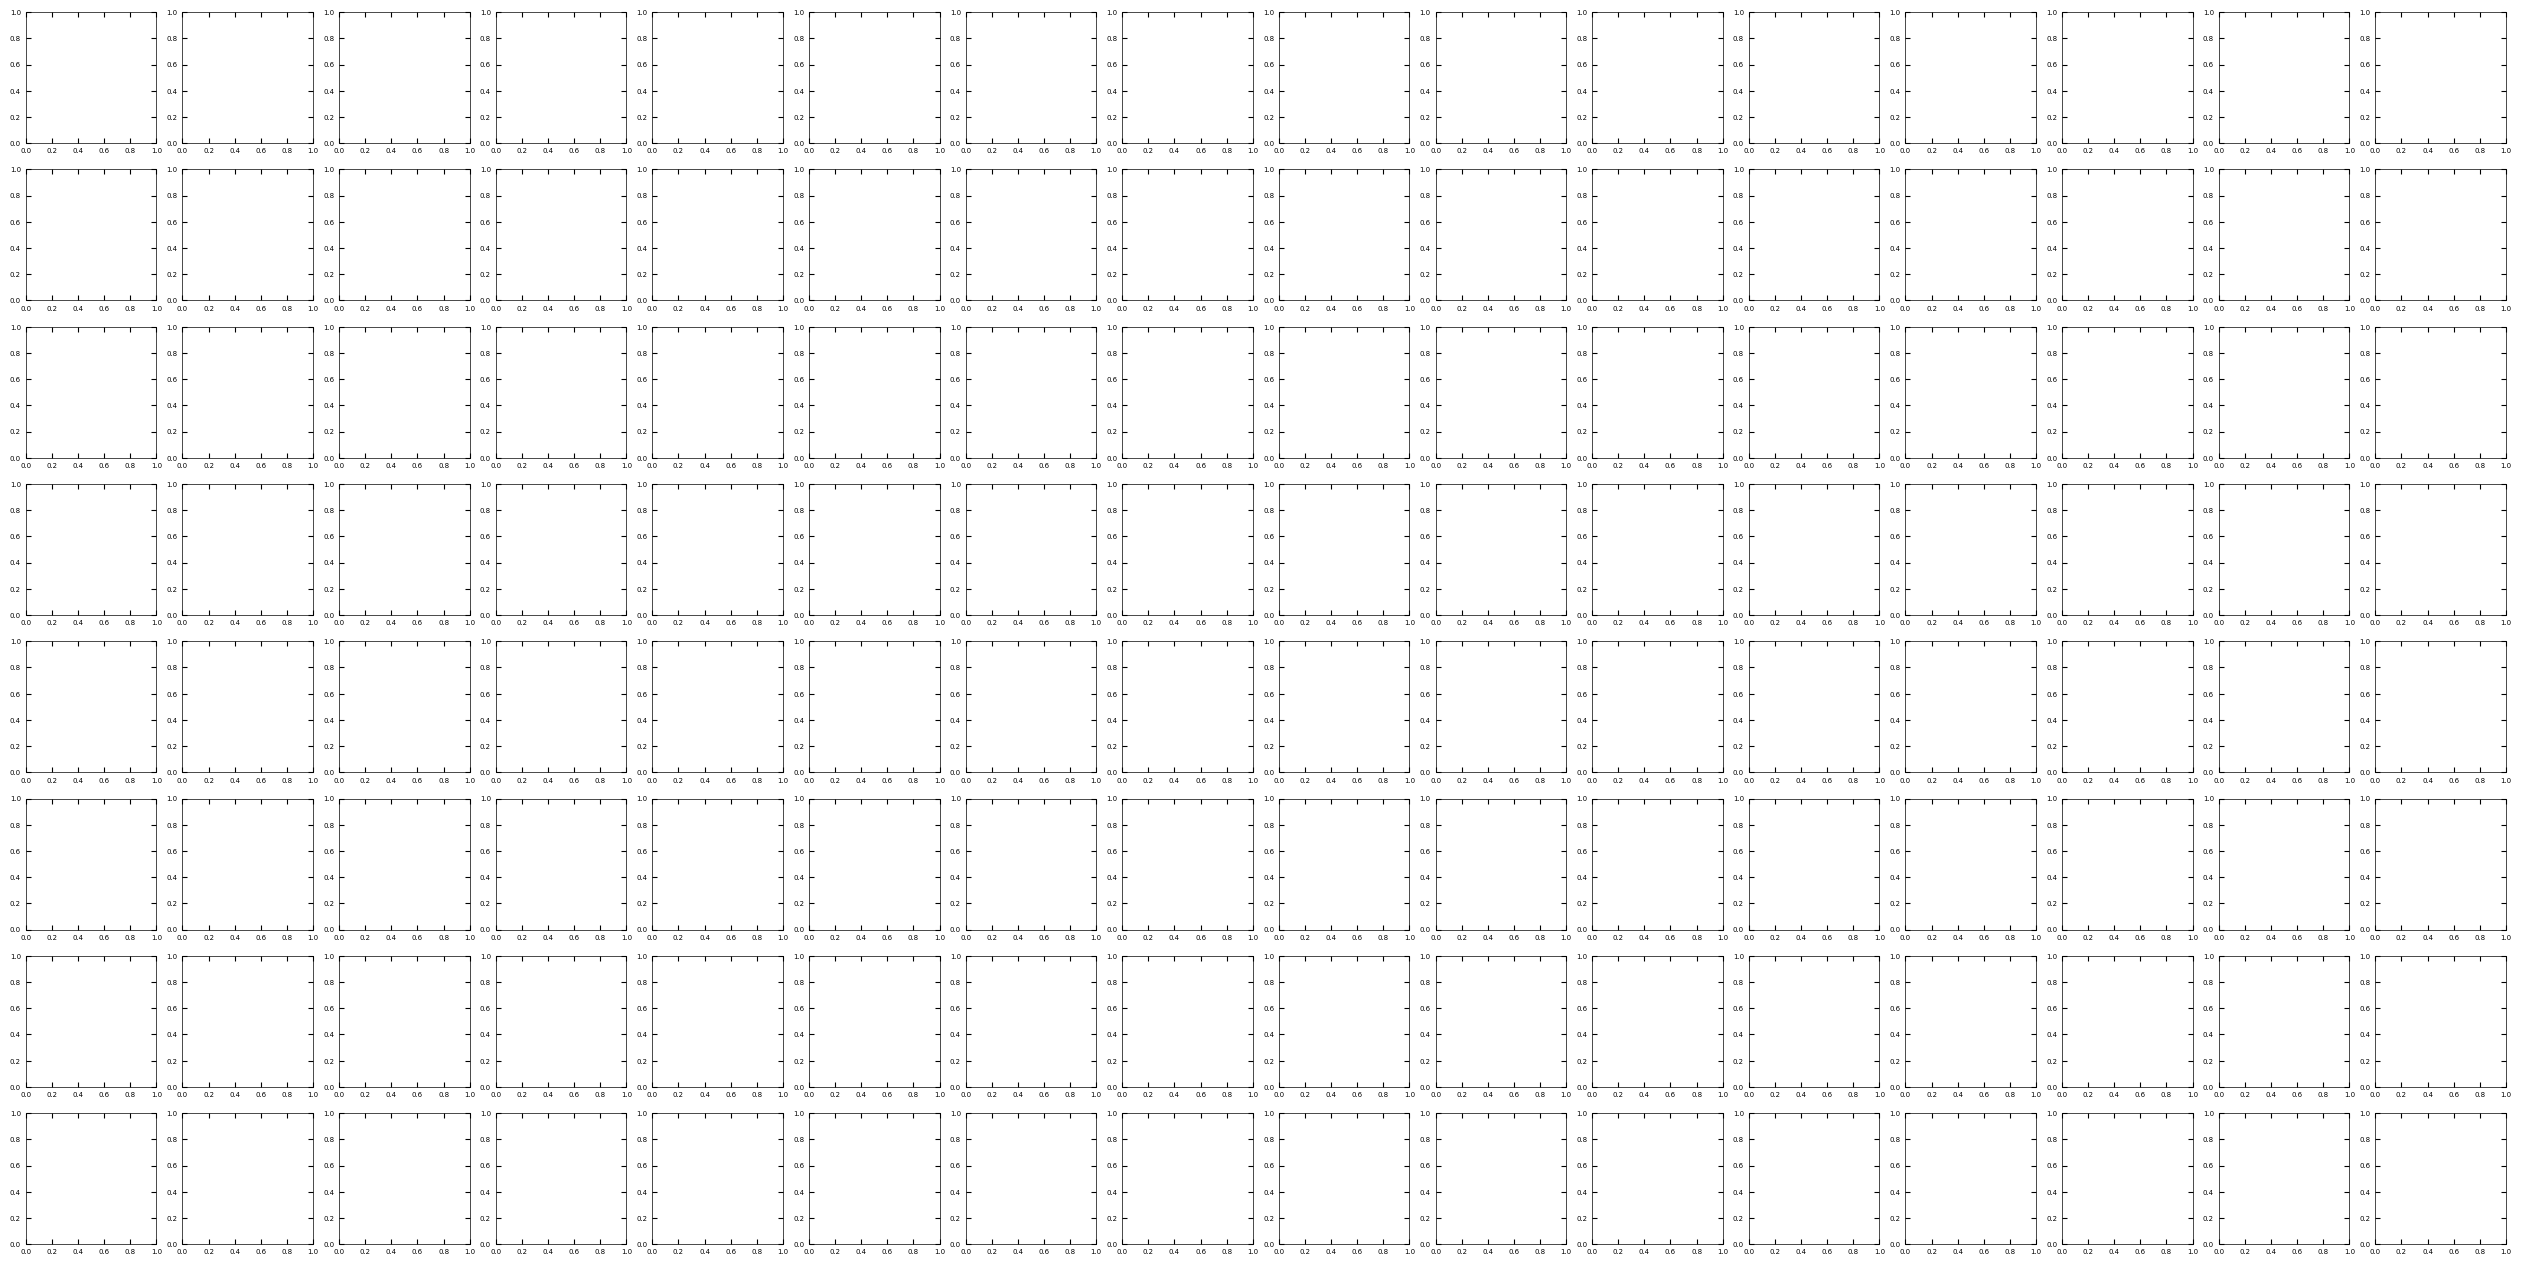

In [27]:
with h5py.File(model1D.emb_h5_path,'r+') as h:
    for p in tqdm(range(28)):
        fig, ax = plt.subplots(8,16,figsize=(32,16))
        ax = ax.flatten()

        # emb = h['embedding_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675.pkl'][dset.meta['particle_inds'][p]:dset.meta['particle_inds'][p+1]]
        fits = h['fits_(2024-07-25)_epoch:0099_l1coef:0.0000_lr:0.00000_trainloss:0.0675'][meta['particle_inds'][p]:meta['particle_inds'][p+1]]
        for i in range(64):
            ax[i*2].hist(fits[:,0,i].flatten(),bins=50)
            ax[i*2].set_title(f'HL: {i}',fontsize=5)
            ax[i*2+1].hist(fits[:,1,i].flatten(),bins=50)
            ax[i*2+1].set_title(f'LL: {i}',fontsize=5)
        fig.suptitle( {dset.meta["particle_list"][p]})
        fig.savefig(f'/home/m3learning/Northwestern/Northwestern_link/Northwestern_Multimodal_Figures/embeddings_lab_07-29/{p}_hist',format='png')

In [88]:
import matplotlib.image as mpimg

base_folder = '/home/m3learning/Northwestern/Northwestern_link/Northwestern_Multimodal_Figures/embeddings_lab_07-29'
def f(p,i):
    img = mpimg.imread(f'{base_folder}/{p}_{i}_embedding_maps.png.png')
    plt.imshow(img); plt.show()
    
interact(f, p=(0,len(meta['shape_list'])), i=(0,model1D.num_fits-1))

interactive(children=(IntSlider(value=13, description='p', max=27), IntSlider(value=31, description='i', max=6…

<function __main__.f(p, i)>

  0%|          | 0/27 [00:45<?, ?it/s]


ValueError: Image size of 7200x76800 pixels is too large. It must be less than 2^16 in each direction.

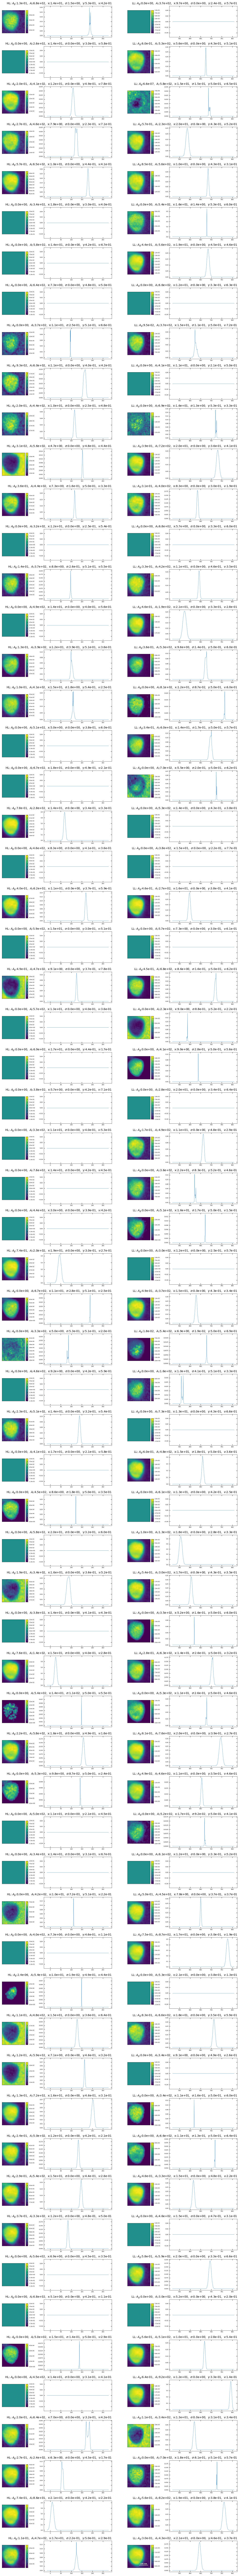

In [67]:
viz.channels = [i for i in range(model1D.num_fits)]

viz.fits_Fitter1D(model1D,
                  dset,
                  overwrite=True,
                  savefolder='embeddings_lab_07-29',
                   name="",
                   channels = viz.channels,
                   labelfigs_ = False,
                   scalebar_ = viz.scalebar_,
                   printer = viz.printer)

# viz.embeddings(
#     dset.meta,
#     mod=4,
#     scalebar_=viz.scalebar_,
#     savefolder='emb_1D_epoch_19/')

In [177]:
debug

> /home/m3learning/Northwestern/m3_learning/m3_learning/src/m3_learning/nn/STEM_AE_multimodal/Viz.py(651)<listcomp>()
    649         nchs = dset.eels_chs
    650         nfits = model.num_fits
--> 651         x_vals = [dset.raw_x_labels[i0-1:i1+1,l] for i0,i1,l in meta['eels_axis_labels']]
    652         for p,p_name in enumerate(tqdm(meta['particle_list'])): # each sample
    653             x,y,_ = meta['shape_list'][p][1]

*** NameError: name 'meta' is not defined
*** NameError: name 'meta' is not defined
*** NameError: name 'meta' is not defined
*** NameError: name 'meta' is not defined


In [ ]:
cluster_list,labels = model1.get_clusters(dset,embeddings1)                                                                             

In [ ]:
viz.clustered_images(dset,cluster_list,labels,
                     save_folder='clustered_30_epoch_6/',
                     printer = viz.printer)

In [ ]:
# folder_name = "Generator_of_epoch_6_all_ch"
model1.generate_range(dset, model1.checkpoint,
                      channels=viz.channels,
                        generator_iters=25,averaging_number=50,
                        overwrite=True)

In [ ]:
# viz.channels = [0,2,3,4,5,6,7,9,10,11,12,13,14,15,16,18,19,20,23,25,26,27,30,31]
folder_name = "Generated_1D_19"
# viz.model=model1
viz.generator_images_1D(dset,
    folder_name=folder_name,
    figsize=(4,10),
    cbar_number_format="%.02d",
    # shape_=(128,128,128,128),
    divider_=False,
    graph_layout=(len(viz.channels)*dset.eels_chs,4),
    labelfigs_=True
    )

## 2d

In [ ]:
model2 = ConvAutoencoder_2D(
            encoder_step_size_2D,
            pooling_list_1D,
            decoder_step_size_2D,
            upsampling_list_2D,
            embedding_size,
            conv_size_2D,
            device,
            attn_heads,
            learning_rate=3e-5,
        )

In [ ]:
st = 3
model2.training = True
## TODO: get rid of translation
## TODO: should I add weights for the relative contributions of spectra and diffraction?
for ep in np.arange(0,20):
    model2.Train(
        dset,
        coef_1=(1e-5*ep)//st,
        coef_2=(1e-5*ep)//st,
        epoch_=ep,
        epochs=ep+1,
        with_scheduler=False,
        folder_path="Combined_all_samples_2D",
        batch_size=16, # max 16 on h100
        save_emb_every=100
    )

In [ ]:
check = '(2024-02-20)_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:1.4993'

h[f'embedding_{check}'] = h[f'embedding_']
h[f'scaleshear_{check}'] = h[f'embedding_']
h[f'rotation_{check}'] = h[f'embedding_'] 
h[f'translation_{check}'] = h[f'embedding_']
model2.embedding = h[f'embedding_{check}']
model2.scale_shear = h[f'scaleshear_{check}']           
model2.rotation = h[f'rotation_{check}']         
model2.translation = h[f'translation_{check}']

In [ ]:
embeddings2 = model2.get_embedding(dset,train=False)

In [ ]:
# instantiates the visualization class
viz = Viz_Multimodal(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm", "channel": -1}

In [ ]:
viz.channels = [i for i in range(model2.embedding_size)]
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm"}
viz.model = model2
viz.embeddings(
    dset.meta,
    mod=4,
    scalebar_=viz.scalebar_,
    savefolder='emb_2D_epoch_01/')

In [ ]:
# Visualize affine transforms
viz.affines(
    dset.meta,
    scalebar_=viz.scalebar_,
    figsize=(5, 8),
    savefolder='emb_2D_epoch_01/'
    )

In [ ]:
cluster_list,labels = model2.get_clusters(dset,embeddings1,n_components=17,n_clusters=30)                                                                             

In [ ]:
viz.clustered_images(dset,cluster_list,labels,
                     save_folder='clustered_30_epoch_6/',
                     printer = viz.printer)

In [ ]:
# folder_name = "Generator_of_epoch_6_all_ch"
# viz.channels = 
model2.generate_range(dset, model2.checkpoint,channels=viz.channels,
                                generator_iters=25,averaging_number=50,
                                overwrite=False)

In [ ]:
folder_name = "Generator_2D_ep_1"
viz.channels = [0,5,6,10,12,14,18,19,21,23,25,26,27,28,29,31]
viz.generator_images_2D( dset,
    folder_name=folder_name,
    figsize=(7.5,4),
    cbar_number_format="%.02d",
    # shape_=(128,128,128,128),
    divider_=False,
    graph_layout=(len(viz.channels),4),
    labelfigs_=True
    )

## train 1D and 2D together

In [ ]:
model = ConvAutoencoder_Multimodal(
            encoder_step_size_1D,
            encoder_step_size_2D,
            pooling_list_1D,
            pooling_list_2D,
            decoder_step_size_1D,
            decoder_step_size_2D,
            upsampling_list_1D,
            upsampling_list_2D,
            embedding_size_1D,
            embedding_size_2D,
            embedding_size,
            channels_1D,
            conv_size_1D,
            conv_size_2D,
            device,
            attn_heads,
            learning_rate=3e-5,
        )


### Trains or Loads Pretrained Weights


In [ ]:
# load weights?
model.load_weights(
 '/home/m3learning/Northwestern/m3_learning/m3_learning/papers/Multimodal/Combined_all_samples/(2024-02-13)_epoch:0002_l1coef:0.0000_lr:0.00003_trainloss:7.2645.pkl'
 
 )

In [ ]:
for i in range(32):
    dat = model.embedding[:128*128,i]
    plt.imshow(dat.reshape(128,128))
    plt.colorbar()
    plt.show()

In [ ]:
st = 4
## TODO: get rid of translation
## TODO: should I add weights for the relative contributions of spectra and diffraction?
for ep in np.arange(0,100):
    model.Train(
        dset,
        coef_1=(1e-5*ep)//st,
        coef_2=(1e-5*ep)//st,
        epoch_=ep,
        epochs=ep+1,
        with_scheduler=False,
        folder_path="Combined_all_samples_1",
        batch_size=16, # max 16 on h100
        save_emb_every=1
    )

In [ ]:
model.checkpoint = 'm3_learning/m3_learning/papers/Multimodal/Combined_all_samples_1/(2024-02-16)_epoch:0005_l1coef:0.0001_lr:0.00003_trainloss:1.0128.pkl'

h = model.open_embedding_h()
h.keys()

In [ ]:
import glob
import pandas as pd
pathlist = glob.glob('./Combined_all_samples_1/*.pkl')
pathlist.sort()
losses = []

for path in pathlist:
    checkpoint = torch.load(path)
    losses.append(checkpoint['loss_dict'])
    print(checkpoint['loss_dict'])

In [ ]:
loss_set = pd.DataFrame(losses)
loss_set

In [ ]:
loss_set.sum(axis=1)

In [ ]:

from torch.utils.data import DataLoader
input = DataLoader(dset,batch_size=8,shuffle=True)



In [ ]:
batch = next(iter(input))

In [ ]:
batch[2].shape

In [ ]:
pred = model.autoencoder((batch[1].to('cuda:0').float(),
                                                 batch[2].to('cuda:0').float()))

In [ ]:
pred[2].shape

In [ ]:
pred[1].shape

In [ ]:
pred[2].shape

In [ ]:
for i in range(8):
    plt.imshow(batch[1][i].squeeze())
    plt.colorbar()
    plt.show()

In [ ]:
fig,ax = plt.subplots(4,4)
for i in range(4):
    ax[i][0].imshow(pred[2][i].squeeze().detach().cpu())
    ax[i][0].imshow(batch[1][i].squeeze())
    ax[i][1].plot(batch[2][i][0])
    ax[i][1].plot(pred[1][i][0].detach().cpu())
    ax[i][2].plot(batch[2][i][1])
    ax[i][2].plot(pred[1][i][1].detach().cpu())

In [ ]:
fig,ax = plt.subplots(4,4)
for i in range(4):
    ax[i][0].imshow(pred[2][i].squeeze().detach().cpu())
    ax[i][0].imshow(batch[1][i].squeeze())
    ax[i][1].plot(pred[1][i][0].detach().cpu())
    ax[i][1].plot(batch[2][i][0])
    ax[i][2].plot(pred[1][i][1].detach().cpu())
    ax[i][2].plot(batch[2][i][1])

In [ ]:
predicted_1D, predicted_2D  = model.autoencoder((batch[1].to('cuda:0').float(),
                                                 batch[2].to('cuda:0').float()))

In [ ]:

plt.plot(loss_set['contrastive'])
plt.plot(loss_set['l1'])
plt.plot(loss_set['mse_1d'])
plt.plot(loss_set['mse_2d'])
plt.plot(loss_set.sum(axis=1))

plt.legend(['contrastive','l1','mse_1d','mse_2d','total'])


In [ ]:
fig, ax = plt.subplots(5,figsize=(5,10))

ax[0].plot(loss_set['contrastive'])
ax[1].plot(loss_set['l1'])
ax[2].plot(loss_set['mse_1d'])
ax[3].plot(loss_set['mse_2d'])
ax[4].plot(loss_set.sum(axis=1))

ax[0].set_title('contrastive')
ax[1].set_title('l1')
ax[2].set_title('mse_1d')
ax[3].set_title('mse_2d')
ax[4].set_title('total')


In [ ]:
# # checkpoint = {
# #     "net": model.autoencoder.state_dict(),
# #     'optimizer': model.optimizer.state_dict(),
# #     "epoch": 0,
# #     "encoder_1D": model.encoder_1D.state_dict(),
# #     "encoder_2D": model.encoder_2D.state_dict(),
# #     'decoder_1D': model.decoder_1D.state_dict(),
# #     'decoder_2D': model.decoder_2D.state_dict(),
# # }

# # lr_ = format(model.optimizer.param_groups[0]['lr'], '.5f')
# # file_path = f'./Combined_all_samples/2023_2_1_' +\
# #     f'epoch:{0:04d}_l1coef:{0:.4f}'+'_lr:1e-4' +\
# #     f'_trainloss:{7.9609:.4f}.pkl'
# # torch.save(checkpoint, file_path)
# file_path = model.checkpoint
# h = model.embedding.file
# check = file_path.split('/')[-1][:-4]
# h[f'embedding_{check}'] = h[f'embedding_'] # combined embedding
# h[f'scaleshear_{check}'] = h[f'scaleshear_']
# h[f'rotation_{check}'] = h[f'rotation_'] 
# h[f'translation_{check}'] = h[f'translation_']
# model.embedding = h[f'embedding_{check}']
# model.scale_shear = h[f'scaleshear_{check}']           
# model.rotation = h[f'rotation_{check}']         
# model.translation = h[f'translation_{check}']
# del h[f'embedding_']         
# del h[f'scaleshear_']          
# del h[f'rotation_']          
# del h[f'translation_']
# h.flush()
# # h.close()

### Computes the Embeddings


In [ ]:
model.checkpoint

In [ ]:
h = model.open_embedding_h()
print(h.keys())
print(h['embedding_temp'].shape)
plt.imshow(h['embedding_temp'][:128*128,0].reshape(128,128))

In [ ]:
model.autoencoder.get_embeddings

In [ ]:
# run if you did not autosave embedding (takes about 1:15 minutes on h100, or 2.5 hr on titan)
model.autoencoder.get_embeddings = True
model.get_embedding(dset, batch_size=32, no_calculate=False)

### Visualizes the Embeddings


In [ ]:
viz.channels = [i for i in range(model.embedding_size)]
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm"}
viz.model = model
viz.embeddings(
    dset.meta,
    mod=4,
    scalebar_=viz.scalebar_,
    savefolder='emb_affine_epoch_6/'
    )

In [ ]:
# Visualize affine transforms
viz.affines(
    dset.meta,
    scalebar_=viz.scalebar_,
    figsize=(5, 8),
    savefolder='emb_affine_epoch_6/'
    )

### Clustering

In [ ]:
scaled_emb_affines = model.stack_emb_affines()

In [ ]:
# will create scree and elbow plots if you aren't sure how many components/clusters are needed

# cluster_list,labels = model.get_clusters(dset,scaled_emb_affines,n_components=25,n_clusters=20)

cluster_list,labels = model.get_clusters(dset,scaled_emb_affines,n_components=17,n_clusters=30)

### visualize clusters

In [ ]:
model.embedding_size


In [ ]:
viz.printer.basepath

In [ ]:
viz.clustered_images(dset,cluster_list,labels,
                     save_folder='clustered_30_epoch_6/',
                     printer = viz.printer)

### Generates Data from the Latent Space


In [ ]:
h = model.open_embedding_h()

In [ ]:
# checkpoint = '/home/m3learning/Northwestern/m3_learning/m3_learning/papers/HE_nanoparticles/Combined_all_samples/(2023-08-21)_epoch:0006_l1coef:0.0000_lr:0.00003_trainloss:0.6229.pkl'

# embedding = model.embedding
# channels = []
# for i in range(32):
#     if embedding[:,i].max()>0.03: channels.append(i)
# channels

# viz.channels = [i for i in range(32) if (model.embedding[:,i]).any()]
# ranges = []
# for c in channels:
#     ranges.append([embedding[:,c].min(),embedding[:,c].max()])
    
# model.embedding = embedding
viz.model = model
# folder_name = "Generator_of_epoch_all_ch"

In [ ]:
# # folder_name = "Generator_of_epoch_6_all_ch"
# model.generate_range(dset.meta, model.checkpoint,channels=viz.channels,
#                                 generator_iters=25,averaging_number=50,
#                                 overwrite=True)

### Visualize generated images

In [ ]:
dset.meta['particle_inds'][0]

In [ ]:
len(viz.channels)

In [ ]:
hg = model.open_generated_h()


In [ ]:
hg.keys()

In [ ]:
h=model.open_embedding_h()
h.close()
h=model.open_generated_h()
h.close()

In [ ]:
printing

In [ ]:
folder_name

In [ ]:
p_name='AuCu(40)'

In [ ]:
f'{printing.basepath}{folder_name}/{p_name}/*'


In [ ]:
existing = [item.split('/')[-1] for item in glob.glob(f'{printing.basepath}{folder_name}/{p_name}/*')]
# if p_name+'_embedding_maps.png' in existing:
#     print('skipping',savefolder+p_name+'_embedding_maps.png')
#     continue

In [ ]:
existing

In [ ]:
folder_name = "Generator_of_epoch_6_all_ch_1"
viz.generator_images( dset.meta, model.generated,
                     scaler=dset.scaler,
    folder_name=folder_name,
    figsize=(7.5,4),
    cbar_number_format="%.02d",
    shape_=(128,128,128,128),
    divider_=False,
    graph_layout=(len(viz.channels),4),
    labelfigs_=True
    )

### Builds a Movie


In [ ]:
folder_name = "Generator_of_epoch_6_all_ch"


In [ ]:
# Builds a Movie
folder = f"{fig_path}{folder_name}/"
# output_folder = "./movies_unscaled/"
output_folder = "./movies/"


for particle in dset.meta['particle_list']:
    # particle=particle.replace('_',' ')
    print(particle)
    make_movie(f"Generator {particle}", f'{folder}{particle}/', 
               output_folder, "png", 3)

### Generate from specified embedding range

In [ ]:
g_folder = str(channels).replace(', ','_')[1:-1]

In [ ]:
g_folder

In [ ]:
fig_path

In [ ]:
# Builds a Movie
folder = f"{fig_path}/generator_{g_folder}"
output_folder = "./movies/"

In [ ]:
'generator_[1, 3, 8, 10, 11, 13, 15, 17, 22, 26]'

In [ ]:
# Builds a Movie
folder = f"{fig_path}/generator_{g_folder}"
output_folder = "./movies/"

# function to make the movie
make_movie("Domain Generator", folder, output_folder, "png", 3)